# Mario Bros Preprocessing

In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import string
from IPython.display import display
from itertools import product
from os.path import isfile
from os import listdir, remove

In [2]:
original_folder = "modified/"
crop_folder = "crop/"
work_folder = original_folder
symbols_folder = "symbols/"
maps_folder = "maps/"

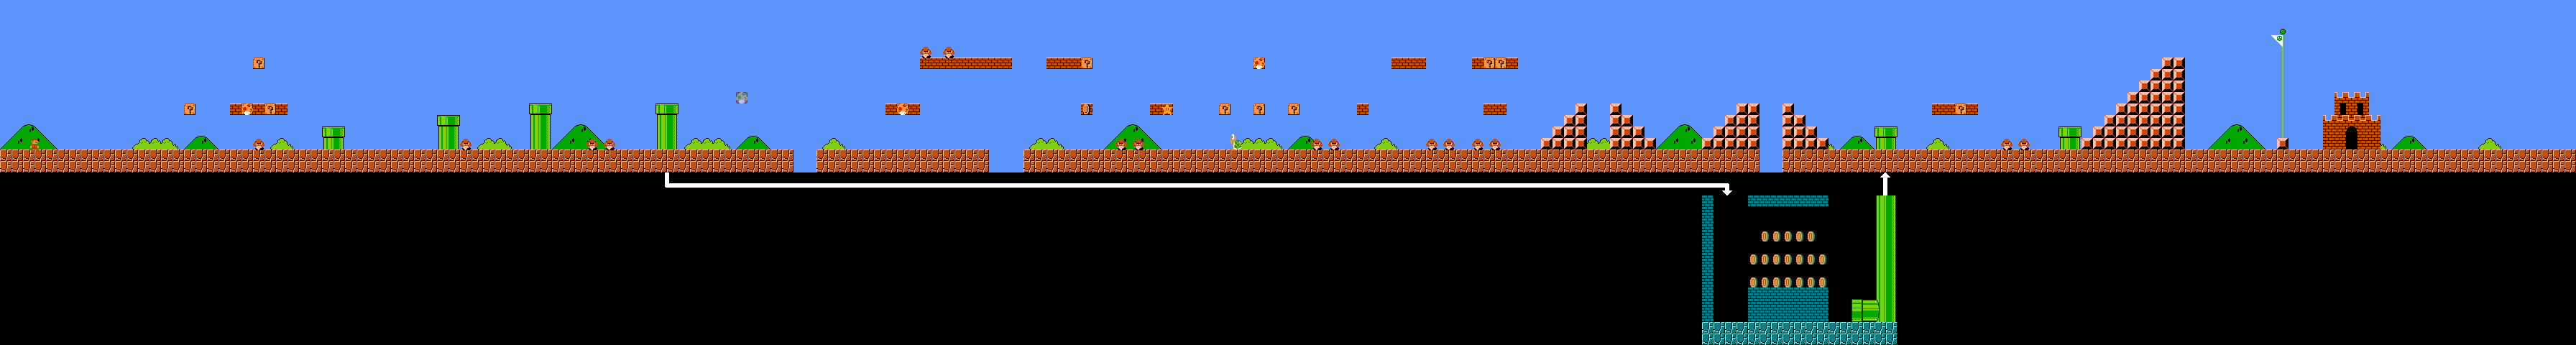

In [3]:
Image.open(original_folder + "1-1.png")

## Preprocessing

In [4]:
block_size = 16

In [5]:
images = listdir(original_folder)

### Crop Image

In [6]:
def crop(name):
    """
    Variables
    """
    img = Image.open(original_folder + name).convert("RGB")

    pixel_width, pixel_height = img.size
    block_width = pixel_width // block_size
    block_height = pixel_height // block_size

    """
    Crop
    """
    dark_pixel = (0, 0, 0)
    # we suppose that 2 blocks is enough
    consecutive_blocks = 2

    # if we have 16 consecutive dark pixels, then we have reach the under ground
    for block in range(block_height):
        pixel = block * block_size

        # if the first pixel is dark, then, maybe is a dark block
        if img.getpixel((0, pixel)) == dark_pixel:
            # check all pixels from consecutive_blocks
            check = True
            for i in range(pixel + 1, pixel + block_size * consecutive_blocks):
                if img.getpixel((0, i)) != dark_pixel:
                    check = False
                    break

            if check:
                # left, top, right, bottom
                img = img.crop((0, 0, pixel_width, pixel))
                break

    img.save(crop_folder + name)

#for img in images:
#    crop(img)

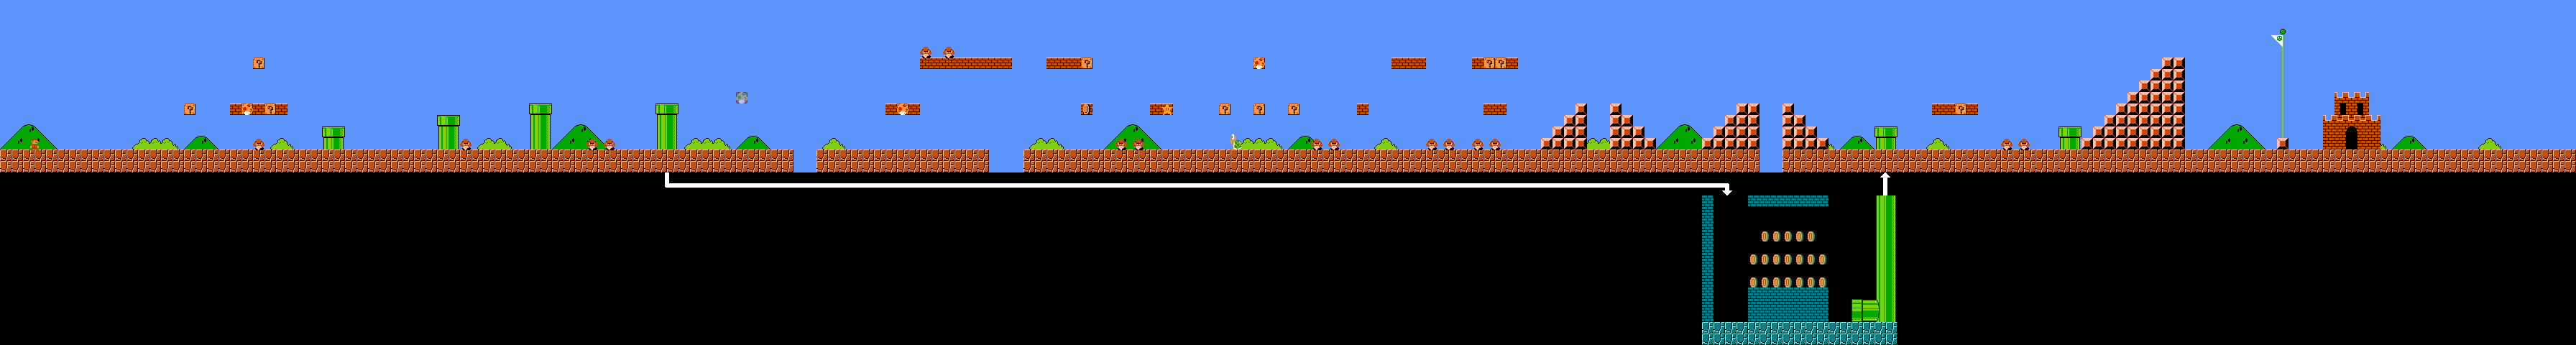

In [7]:
Image.open(work_folder + "1-1.png")

### RGB to Symbols and Join

#### Associate color with a letter

In [8]:
colors_vocab = list(string.ascii_letters)

In [9]:
colors = {}

def new_colors():
    for img in images:
        for i, c in enumerate(Image.open(work_folder + img).convert("RGB").getcolors()):
            color = c[1]
            if color not in colors:
                colors[color] = colors_vocab.pop(0)

    with open("colors.txt", "w") as f:
        for k, v in colors.items():
            f.write(f"{k}-{v}\n")
    return colors

def load_colors():
    with open("colors.txt", "r") as f:
        for line in f.readlines():
            k, v = line.split("-")
            colors[eval(k)] = v.replace("\n", "")
    return colors
            
new_colors()

{(255, 255, 255): 'a',
 (252, 188, 176): 'b',
 (0, 68, 0): 'c',
 (252, 152, 56): 'd',
 (0, 168, 0): 'e',
 (252, 252, 252): 'f',
 (172, 200, 252): 'g',
 (216, 40, 0): 'h',
 (200, 76, 12): 'i',
 (172, 150, 154): 'j',
 (156, 252, 240): 'k',
 (146, 112, 132): 'l',
 (136, 112, 0): 'm',
 (128, 208, 16): 'n',
 (92, 148, 252): 'o',
 (46, 158, 126): 'p',
 (46, 74, 126): 'q',
 (0, 128, 136): 'r',
 (0, 0, 0): 's',
 (24, 60, 92): 't',
 (188, 188, 188): 'u',
 (126, 76, 28): 'v',
 (116, 116, 116): 'w',
 (100, 38, 6): 'x',
 (94, 94, 94): 'y',
 (58, 58, 58): 'z',
 (132, 149, 203): 'A',
 (69, 111, 189): 'B',
 (119, 130, 192): 'C',
 (228, 0, 88): 'D',
 (168, 240, 188): 'E',
 (252, 116, 180): 'F',
 (32, 56, 236): 'G',
 (60, 188, 252): 'H',
 (0, 84, 0): 'I',
 (126, 126, 126): 'J',
 (0, 64, 68): 'K'}

In [10]:
blocks_dict = {}

In [11]:
gens = list(product(string.ascii_lowercase, repeat=3))
blocks_vocab = []
for i in gens:
    blocks_vocab.append(''.join(i))
print(blocks_vocab[:10])
print(len(blocks_vocab))

['aaa', 'aab', 'aac', 'aad', 'aae', 'aaf', 'aag', 'aah', 'aai', 'aaj']
17576


##### Clean maps folder

In [12]:
for file in listdir(maps_folder):
    try:
        remove(maps_folder + file)
        remove(symbols_folder + file)
    except FileNotFoundError:
        continue

In [13]:
def write_symbols(name, symbols):
    f = open(symbols_folder + name + ".txt", "w")
    for s in symbols.transpose():
        for i in s:
            f.write(i)
        f.write("\n")

In [14]:
new_blocks = []

def create_maps(name):
    """
    Variables
    """
    img = Image.open(work_folder + name).convert("RGB")

    pixel_width, pixel_height = img.size
    block_width = pixel_width // block_size
    block_height = pixel_height // block_size

    """
    RGB to Symbols
    """
    symbols = np.zeros((pixel_width, pixel_height), dtype=object)
    
    for w in range(pixel_width):
        for h in range(pixel_height):
            symbols[w, h] = colors[img.getpixel((w, h))]
            
    write_symbols(name, symbols)
    
    """
    Join Blocks
    """
    map_ = np.zeros((block_width, block_height), dtype=object)
    
    for w in range(block_width):
        for h in range(block_height):
            w_ = w * block_size
            h_ = h * block_size

            # join pixels and transform them to string
            block = "".join(str(s) for s in symbols[w_:w_+block_size, h_:h_+block_size].flatten())
            
            try:
                # if the block exists on our db
                map_[w, h] = blocks_dict[block]
            except KeyError:
                # if not, create a new entry
                blocks_dict[block] = blocks_vocab.pop(0) + "-"
                map_[w, h] = blocks_dict[block]
                new_blocks.append(block)
                
    f = open(maps_folder + name + ".txt", "w")
    #for b in map_.transpose():
    for b in map_:
        for i in b:
            f.write(i)
        f.write("\n")
        
    f.close()

for img in images:
    create_maps(img)
    
new_blocks = list(set(new_blocks))
print("New blocks:", len(new_blocks))

New blocks: 767


In [15]:
# save blocks dict
with open("blocks_dict.txt", "w") as f:
    for k, v in blocks_dict.items():
        f.write(f"{v}_{k}\n")

### Show blocks

hooooooooooooooodooooooooooooooodooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


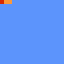

GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGffffGdGGGGGGGGGffuuffduGGdGGGGGuffffudduudfGdGuffuuffuddddfGdduffffffuudddfGdduuffffuuuufffGdduuuuuuuuuufffGGduuuuuuuuuuuffGGduuuuuffuuuuufGGGduuufffuuuuufGGGGGuffffuuuuuuGGGGGfffffuuuuuGGGGGGfffffuuuuddGGGGGfffffGddddG


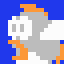

sddddddsssssssssddedddddssssssssfddddssssdsssssdffddssddddddssddfddddddddfffffddddddddffffedeffddddbbbeededeeefdbbbbeeeeedeeeeffbbbedeeededeeedfbsseededeeededefbbbeeedeeeeedeefssseededeeededffsssedefededeeefdsssseeffedeeeffdssssseeededeefsdsssssssssssssfss


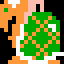

GGGGGGffGGdddGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG


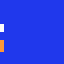

GGffGGdddGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG


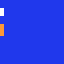

sfhdhhddhssssssssfhdddddhssssssssfhdddddhssssssssfhdssddhssssssssfhssshdhssssssssfhssshdhssssssssfhssshdhssssssssfhssshdhssssssssfhdhhddhssssssssfhdddddhssssssssfhdddddhssssssssfhdssddhssssssssfhssshdhssssssssfhssshdhssssssssfhssshdhssssssssfhssshdhsssssss


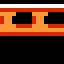

uussssssssssssooffssssssbbssssoofssbssssbbbssssofsbssssbbbbssssofsbsssssbbbssssofsbsssibbbsssssufsbsssibbssssssufsbssssiissssssufssssssssssssssufffibiiiiiiiifuufsbssssssssssssufsbssssssssssssuffffffffffffuuoofffffffffffuuoooffffffffuuuooooouuuuuuuuoooooooo


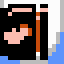

sssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssiiiiiisssssssssiiriiiiissssssssbiiiissssisssssibbiissiiiiiissiibiiiiiiiibbbbbiiiiiiiibbbbrirbbiiiisssrririrrrbissssrrrrrirrrrbb


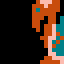

biisiiisiiisiiisbiisiiisiiisiiisbiisiiisiiisiiisbiisssssiiisssssbiisiiisiiisiiisbiisiiisiiisiiisbiisiiisiiisiiisbsssiiisssssiiisbiisiiisiiisiiisbiisiiisiiisiiisbiisiiisiiisiiisbiisssssiiisssssbiisiiisiiisiiisbiisiiisiiisiiisbiisiiisiiisiiisbsssiiisssssiiis


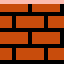

oooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooonnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnoooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


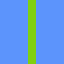

sssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssshssssssssssssssshssssssssssssssshsssssssssssssshhshsssssssssssshhshhsssssssssshhhhhhhssssssssshhhhhhhssssssssshhhhhhsssssssssshdhhhhssssssss


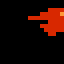

sssssssvvvvssssssxxxxvvvvvvvxxxssxsxvvIIIvvIxsxssxxvvIIIIIvIxxxssxvvvIIIIIvIJJJssvvvvIIIIIvJJJJJvvvvvvIIIvvJJJJJvvvvvvvvvvvJJJJJvvIIvvvvvvvJJJJJvIIIIvvvvvvJJJJvsIIIIvvvvvvJJvvJsxIIIvvvvvvIJJJssxxIvvvIIvvIxxxssxsxvvvIIIvIxsxssxxxxvvvIIvvxxxssssssssvvvvsssss


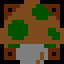

ooooodddddooooooooohhhhddooooooofhhhhhhhooooooooffhhhhhhhoooooooffhhhhhhfoooooooffhhhhhhffoooooohhhhhhhfffoooooohhhhhhffffooooooffhhhhffffoooooofffhhdddffoooooohffhddddfoooooooffhddhhdfooooooohffdhoodooooooooffodoooooooooooooooooooooooooooooooooooooooooooo


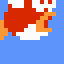

ehhdddddmmhhhheeehhmmdmdmhhdhhheeehddmmdemmhhhhmeeheddmdemmmdhhmeshsddmeemmdddemsssssdeeeemdddeeesssseeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee


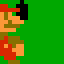

sddddddddddddddsshhddddddddddddsshhhdddddddddddsshhhdddddddddddsshhhdddddddddddsshhhdddddddddddsshhhddddhhhhdddsshhhddhhhhhhhhdsshhddhhhhhhhhhhssddddhhhhhhhhhhssddddhhhhhhhhhhssddddhhhhhhhhhhssddddhhhhhhhhhhssdddddhhhhhhhhdssdddddddhhhhdddssdddddddddddddds


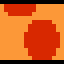

sfhssshdhssssssssfhssshdhssssssssfhdhhddhssssssssfhdddddhssssssssfhdddddhssssssssfhdssddhssssssssfhssshdhssssssssfhssshdhssssssssfhssshdhssssssssfhssshdhssssssssfhdhhddhssssssssfhdddddhssssssssfhdddddhssssssssfhdssddhssssssssfhssshdhssssssssfhssshdhsssssss


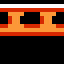

biisiiisiiisiiisbiisiiisiiisiiisbiisiiisiiisiiisbiisssssiiissssssiisiiisiiisiiissiisiiisiiisiiissiisiiisiiisiiisbsssiiisssssiiisbiisiiisiiisiiissiisiiisiiisiiissiisiiisiiisiiissiisssssiiissssssiisiiisiiisiiissiisiiisiiisiiisbiisiiisiiisiiisbsssiiisssssiiis


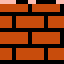

GGGGGGGGGGGGGGGGfGGGGGGGGGGGGGGGfGGGGGGGGGGGGGGGfGGGGGGGGGGGGGGGfGGGGGGGGGGGGGGGfGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG


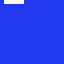

sdhhhhhhhhhhhhsssdhhhhhhhhhhhhsssdhhhhhhhhhhhhsssdhhhhhhhhhhhhsssdhhhhhhhhhhhhsssdhhhhhhhhhhhhsssdhhhhhhhhhhhhsssdhhhhhhhhhhhhsssdhhhhhhhhhhhhsssdhdhdhdhdhdhdsssdhhdhdhdhdhdhsssdhdhdhdhdhdhdsssdhhdhdhdhdhdhsssdhdddddddddddsssdhdddddddddddsossssssssssssssso


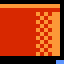

sssssssssssessddssssssssssefeeddsssssssssefffffdssssssssseefffddssssssssseeeeeddssssssssseeeeeffssssssssssefeeddsssssssssseefeedsssssssssssseeefsssssssssssssssesssssssssssssssessssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss


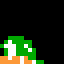

fffffsooooooooooffffffsoooooooooffffffsooooooooofffffsoooooooooofffffsoooooooooosfffsoooooooooooosffsooooooooooooosooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


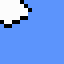

ooooooooooooooooooooooooooooooofooooooooooooofofooooooooooofoffeoooooooooooffedeooooooooooedeeeeoooooooooooeedeeooooooooooooooedoooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


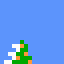

GGGGGfffffhhhhhGGGGGGfffffhhhhddGGGGGfffffGddddGGGGGGGffGGdddGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG


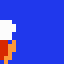

ssdddfsfssssssssssdfssssssssssssesdssdddfsssssssessddddddsssssssfesddddddsssssssfefddddddsssssssfdssddddssssssssfddfsdeeeessssfsfdddsfeeeeessffsffddeeeeeeeedffseffeeeeeeeeeeddseeffffffeeeeeddffeeeefffffeeeedffdeeeeeeeffeeeddddeeeeeeeeffedddeeeeffeeeeffeddf


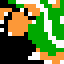

uuuuuuuussssssssffffffffuuusddddffffffffffffeeeffffffffffffffffffffffffffffffffffffffffffffdddddffffffffffffddddffffffffffffffuuffffffffffffffufffffffffffffffffffffffffffffffddfffffffffffffdffffffffffffffffffffffffffffffffffffffffffuffffsffuuuuuuuussffssss


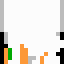

GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGdGGGGGGGGGGGGGGGdGGGGGGGGGGGGGGGdGGGGGGGGGGGGGGGdGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG


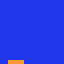

ooooooodhhhhhhhhooooooddhhhhhhhhooooooddhhffffhhooooooddhffffffhoooooodohffhhffhooooooooohffffhdoooooooooffhhffdooooooooooffffodoooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


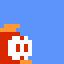

GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGfhdddddhGGGGGGGGfhdGGddhGGGGGGGGfhGGGhdhGGGGGGGGfhGGGhdhGGGGGGGG


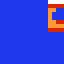

oooooooddddddoooooodddddedddddoooffeeefddddoooodffffffffddooddddoffffffddddddddfooddddddddddffffoooddddddoooeedeooooooooooeeeeedooooooffffeeedeeoooofffdddffdeeeoooffddfffdfeeeeooffdfffffffdeeeoffffffffffeedeeffffffffoffeeeddffffoffoffoeedeeoffooooooooooooo


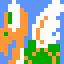

sssssssssssssssssssssssssssssdddsssssssssssffhhhsssssdddddffffffsssddddddddfffffssdddiiiiiiiddddssddidddddddddddssddiddddddddsddssdddssssssssdddsssddddddddddddssssssddddddddsssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss


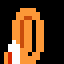

uuuuuuuussssssssffffffffuuusssssfffffffffffuusssffffffffffffuussfffffffffffffuusfffffffffffffuuuffffffffffffffuuffffffffffffffuuffffffffffffffuuffffffffffffffuufffffffffffffuuufffffffffffffuuuffffffffffffuussfffffffffffuusssffffffffuuusssssuuuuuuuussssssss


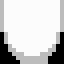

sssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssshhhhssssss


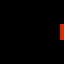

GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGfGGGGGGGGGGGGGGGfGGGGGGGGGGGGGGGfGGGGGGGGGGGGGGGfGGGGGGGGGGGGGGGfGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG


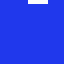

GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGffffGdGGGGGGGGGffhhffdhGGdGGGGGhffffhddhhdfGdGhffhhffhddddfGddhffffffhhdddfGddhhffffhhhhfffGddhhhhhhhhhhfffGGdhhhhhhhhhhhffGGdhhhhhffhhhhhfGGGdhhhfffhhhhhf


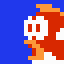

shhdddhhsssssssssshhdddhsssssssssshhdddhhsssssssshhdfddhsssssssssshdfdhhsssssssssshdfdhssssssssssssdfdhsssssssssssshhfhsssssssssssshhhssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss


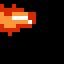

uuuwuuuwuuuwuuuwuuuwuuuwuuuwuuuwuuuwuuuwuuuwuuuwuuuwwwwwuuuwwwwwuuuwuuuwuuuwuuuwuuuwuuuwuuuwuuuwuuuwuuuwuuuwuuuwwwwwuuuwwwwwuuuwuuuwuuuwuuuwuuuwuuuwuuuwuuuwuuuwuuuwuuuwuuuwuuuwuuuwwwwwuuuwwwwwuuuwuuuwuuuwuuuwuuuwuuuwuuuwuuuwuuuwuuuwuuuwuuuwwwwwuuuwwwwwuuuw


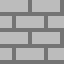

oooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooosooooooooooooooosooooooooooooooosooooooooooooooooooooooooooooooooooooooooooooooo


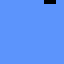

ssssssshhiisiiisssssssshhiisiiisssssssshhiisiiisssssssshhiisssssdddsssshhiisiiissssdddfhhiisiiissssssffhhiisiiisssssssshhsssiiisssssssshhiisiiissssssffhhiisiiissssdddfhhiisiiisdddsssshhiisssssssssssshhiisiiisssssssshhiisiiisssssssshhiisiiisssssssshhsssiiis


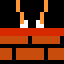

szzzzzzzzzzzzzzszyyyyyyyyyyyyyyzzyzyyyyyyyyyyzyzzyyyvvvvvvvvyyyzzyvvvvvvvvvvvvyzzvvvxxxxxxxxvvvzzvvxvvvvvvvvsvvzzvvxvvvvvvvvsvvzzvvvssssssssvvvzzsvvvvvvvvvvvvszzsssvvvvvvvvssszzyssssssssssssyzzyyyssssssssyyyzzyzyyyyyyyyyyzyzzyyyyyyyyyyyyyyzszzzzzzzzzzzzzzs


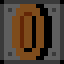

oooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooodddooooooooooooooddddoooooooooooodddddoooooooooo


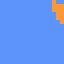

sssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssshhssssssssssssssdhhsssssssssssssddhhsssssssssssshhhhshhhhssssssshsshhhddhhsssssshshhhdfddhhsssssssshdfdhhhhsshhhshshdddhsshshhddssshhdhhshshhdfd


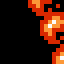

sssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssfhdddddhssssssssfhdssddhssssssssfhssshdhssssssssfhssshdhssssssssfhssshdhssssssssfhssshdhsssssss


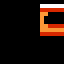

ufwwwwwwwwwwwwuuufwwwwwwwwwwwwuuufwwwwwwwwwwwwuuufwwwwwwwwwwwwuuufwwwwwwwwwwwwuuufwwwwwwwwwwwwuuufwwwwwwwwwwwwuuufwwwwwwwwwwwwuuufwwwwwwwwwwwwuuufwfwfwfwfwfwfuuufwwfwfwfwfwfwuuufwfwfwfwfwfwfuuufwwfwfwfwfwfwuuufwfffffffffffuuufwfffffffffffuouuuuuuuuuuuuuuuo


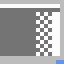

fuuuuuwshhddfdhhfuuuuuwsfhhddhhswwwwwwwsfuhhhhwsssssssssfuuhuuwhffffffwsfuuuhuhhfuuuuuwsfuuhuuhdfuuuuuwswwwhhhhdfuuuuuwsssshhddffuuuuuwsffffhhddfuuuuuwsfuuuuhhhwwwwwwwsfuuuuuwsssssssssfuuuuuhsffffffwsfuuuuuwhfuuuuuwsfuuuuuhsfuuuuuwswwwwwwhhfuuuuuwssssssshh


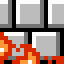

oBBBBBBBBBBBBBBoBCCCCCCCCCCCCCCBBCBCCCCCCCCCCBCBBCCCAAAAAAAACCCBBCAAAAAAAAAAAACBBAAACCCCCCCCAAABBAACAAAAAAAABAABBAACAAAAAAAABAABBAAABBBBBBBBAAABBBAAAAAAAAAAAABBBBBBAAAAAAAABBBBBCBBBBBBBBBBBBCBBCCCBBBBBBBBCCCBBCBCCCCCCCCCCBCBBCCCCCCCCCCCCCCBoBBBBBBBBBBBBBBo


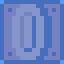

ssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssfhdddddhssssssssfhdssddhssssssssfhssshdhssssssssfhssshdhssss


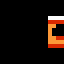

wfuuuuuuuuuuuuwwwfuuuuuuuuuuuuwwwfuuuuuuuuuuuuwwwfuuuuuuuuuuuuwwwfuuuuuuuuuuuuwwwfuuuuuuuuuuuuwwwfuuuuuuuuuuuuwwwfuuuuuuuuuuuuwwwfuuuuuuuuuuuuwwwfufufufufufufwwwfuufufufufufuwwwfufufufufufufwwwfuufufufufufuwwwfufffffffffffwwwfufffffffffffwswwwwwwwwwwwwwwws


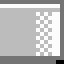

oooooooooooooooooooooodooooooooooooooddoooooooooddoodddoooooooooffffdddoooooooooedeffddooooooooodeeefdooooooooooeeeeffoooooooooodeeedfooooooooooededefooooooooooeedeefooooooooooededffoooooooooodeeefddoooooooooeeeffddooooooooodeefoddoooooooooooofoodooooooooo


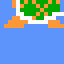

ssfffGGGGGGGGGGGfsffffffffffGGGGsfuffufufuGGGGGGsfufGGGGGGGGGGGGfsfffffffffGGGGGGffufufuGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG


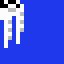

ddddddoooooooooodedddddoooooooodddddoooodoooooddfddooddddddoodddddddddddfffffddddddddffffedeffddddoooeededeeefdooooeeeeedeeeeffofffeeedeedeeedfodddffdeeeededefofffdfeeeeeedeefofffffdeeeededffoffffeedeedeeefddfoffeeeddeeeffddoffoeedeedeefoddoooooooooooofood


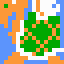

ooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooodddooooooooooooooddooooooooooooooddoooooffffooohhhhooooffffffhhhhhhoooofffffffhhhhh


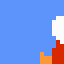

hfhhhhhhhhhhoooohhhhhhhhhhhddooohhhhhhhhhhhddooohhhhhhhhfhhhoooohhhhhhhffhhdoooohhhhhhffhhddoooohdhhhhhhdhoooooooddhddhddoooooooooooddoooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


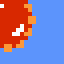

oooooobbbbbbbbbboooobbssssssssssoobbssssssssssssbbsssiiiiiiiiissssssiiiibbbbiiisssssiibbiiibiiisssssibbiiiibbbisssssibbbbbbbibisssssibbbbbbbibisssssibbiiiibbbisssssiibbiiibiiisssssiiiibbbbiiisiisssiiiiiiiiissooiissssssssssssooooiiisssssssssoooooooiiiiiiiii


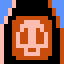

ssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa


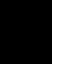

eeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeefehheeeeeeeeeeehfhfheeeeeefffffhfhhheeeeeeedddfdhfhhdeeeeeeeddddhhfddeeeeeeeeddhhhhfdeeeeeeffhhhfdhhfeeeeffdddhffddhfeeffdddddhfdddhfeeeedddddhddddhfeeeeeeddhhhddhhfeeeeeeeeffhhhhff


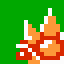

oooooooooooooooooooooouuuuuoodddoooooufffffffeeeooooufffffffffffooouffffffffffffooouffffffffddddoouffffffffffdddooufffffffffffuuooufffffffffffuuooufffffffffffuuoooufffffffffuuuoooufffffffffuuuooooufffffffuuoooooooufffffuuooooooooouuuuuooooooooooooooooooooo


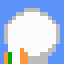

GGGduuufffuuuuufGGGGGuffffuuuuuuGGGGGfffffuuuuuGGGGGGfffffuuuuddGGGGGfffffGddddGGGGGGGffGGdddGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG


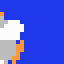

ssssssssssssssssEeeeeeeeeeeEeEEsEeeeeeeeeeEeEEEsEeeeeeeeeeeEeEEsEeeeeeeeeeEeEEEsEeeeeeeeeeeEeEEsEeeeeeeeeeEeEEEsEeeeeeeeeeeEeEEsEeeeeeeeeeEeEEEsEeeeeeeeeeeEeEEsEeeeeeeeeeEeEEEsEeeeeeeeeeeEeEEsEeeeeeeeeeEeEEEsEeeeeeeeeeeEeEEsssssssssssssssssssssssssssssssso


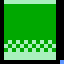

rkkkkkkkkkskkkkrkrrrrrrrrrskrrrskrrrrrrrrrrskrrskrrrrrrrrrrskrrskrrrrrrrrrrrskrskrrrrrrrrrrrskrskrrrrrrrrrrrskrskrrrrrrrrrrrsssrkrrrrrrrrrsskkkksssssssssskkrrrsrkkkkrkkkkrrrrrskrrrsskrrrrrrrrstrrrrskrrrrrrrrstrrrrskrrrrrrrrstrrrrskrrrrrrrssrssssrsssssssssr


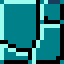

cneeeeeeeeeeeecccneeeeeeeeeeeecccneeeeeeeeeeeecccneeeeeeeeeeeecccneeeeeeeeeeeecccneeeeeeeeeeeecccneeeeeeeeeeeecccneeeeeeeeeeeecccneeeeeeeeeeeecccnenenenenenencccneenenenenenecccnenenenenenencccneenenenenenecccnennnnnnnnnnncccnennnnnnnnnnncscccccccccccccccs


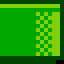

rkkkkkkkkkskkkkrkrrrrrrrrrskrrrskrrrrrrrrrrskrrskrrrrrrrrrrskrrskrrrrrrrrrrrskrskrrrrrrrrrrrskrskrrrrrrrrrrrskrskrrrrrrrrrrrsssrkrrrrrrrrrsskkkksssssssssskkrrrsrkkkkrkkkkrrrrrskrrrsskrrrrrrrrskrrrrskrrrrrrrrskrrrrskrrrrrrrrskrrrrskrrrrrrrssrssssrsssssssssr


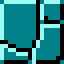

sssssrrssssssssssssrrirsssssssssssrrirrsssssssssssrrirrssssssssssssrirrsssssssssssssrrssssssssssrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrssssssssssssrrsssssssssssssrirrsssssssssssrrirrsssssssssssrrirrssssssssssssrrirssssssssssssssrrsssssssssssssssssssssssssssssssss


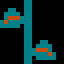

oooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooossssooooooooooosbssssooooooooosbsbssssooooooosbbbssssssooooossssssssssssoooossssssbbssssooossbssssbbbssssoosbssssbbbbssssoosbsssssbbbssssoosbsssibbbsssssoosbsssibbsssssso


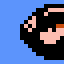

ssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssshhhhssssssssssshhddhhsssssssssshddfdhsssssssssshhddfdssssssssssshhhddssssssssshssshdhssssssssssshshhhsssssssssshshhss


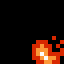

sssfhhfhhhhhhhhhsssfhfhhhhhhhhhhssfhhhffhhhhhhhhsfhhhhhhhhhhhhhhfhhhhhhhhhhhhhhhsfffhhhfhhhhhhhhssssfhhfhhhhhhhhssssfhfhhhhhhhhhsssfhhfhhhhhhhhhsssfhfhhhhhhhhhhssfhhhffhhhhhhhhsfhhhhhhhhhhhhhhfhhhhhhhhhhhhhhhsfffhhhfhhhhhhhhssssfhhfhhhhhhhhssssfhfhhhhhhhhh


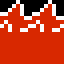

sssssssssssssssssssssssssssssssssssssssssssssssshssssssssssssssssshhhsssssssssssshhdhhssssssssssshdddhsssssssssshhdfdhssssssssssddfdhhsssssssssshddhhssssssssssshhhhssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss


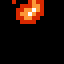

ibbbbbbbbbsbbbbibiiiiiiiiisbiiisbiiiiiiiiiisbiisbiiiiiiiiiisbiissiiiiiiiiiiisbissiiiiiiiiiiisbissiiiiiiiiiiisbisbiiiiiiiiiiisssibiiiiiiiiissbbbbssssssssssbbiiissbbbbibbbbiiiiissiiissbiiiiiiiissiiiisbiiiiiiiissiiiisbiiiiiiiisbiiiisbiiiiiiississssisssssssssi


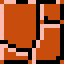

ooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooodddooooooooooooooddddoooooooooooodddddo


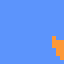

ssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssdddfsssssssssssdsdddffssssssssssddddssssssssssssefdddfssssssssseeffedffsssssssffffeedessssssssfffeeddfsssf


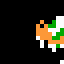

sssssssssssssssssssshssssssssssssssshssssssssssssssshsssssssssssssshhshsssssssssssshhshhsssssssssshhhhhhhssssssssshhhhhhhssssssssshhhhhhsssssssssshdhhhhsssssssssshdhdhhhsssssssshhhhdhhhsssssssshhhhdhhhsssssssshhdhdhhssssssssshhdddhshsssssssshhdddhhhsssssss


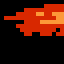

oooooeeooooooooooooeedeoooooooooooeedeeoooooooooooeedeeooooooooooooedeeoooooooooooooeeooooooooooeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeooooooooooooeeoooooooooooooedeeoooooooooooeedeeoooooooooooeedeeooooooooooooeedeooooooooooooooeeooooooooooooooooooooooooooooooooo


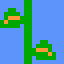

hhhfffoooooooooohhffffoooooooooohhffffoooooooooohdddffooooooooooddddfooooooooooodhhdfooooooooooohoodoooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


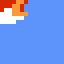

sssssaaaaaassssssssssaaaaaassssssssssaaaaaassssssssssaaaaaassssssssssaaaaaassssssssssaaaaaassssssssssaaaaaassssssssssaaaaaassssssaaaaaaaaaaaaaasssaaaaaaaaaaaasssssaaaaaaaaaasssssssaaaaaaaasssssssssaaaaaasssssssssssaaaasssssssssssssaasssssssssssssssssssssss


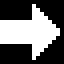

GGGGGGGGGuffffudGGGGGGdGuffuuffuGGGGGGdduffffffuGGGGGGdduuffffuuGGGGGGdduuuuuuuuGGGGGGGduuuuuuuuGGGGGGGduuuuuffuGGGGGGGGduuufffuGGGGGGGGGGuffffuGGGGGGGGGGfffffuGGGGGGGGGGfffffuGGGGGGGGGGfffffGGGGGGGGGGGGffGGdGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG


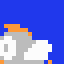

sssssfhssshdhssssssssfhssshdhssssssssfhdhhddhssssssssfhdddddhssssssssfhdddddhssssssssfhdssddhssssssssfhssshdhssssssssfhssshdhssssssssfhssshdhssssssssfhssshdhssssssssfhdhhddhssssssssfhdddddhsssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss


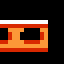

ssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssffffffffffffffffffffffffffffffffssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss


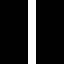

ffGddddGGGGGGGGGGGdddGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG


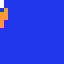

ooiisoooooiisoooooiisdooooiisooooobiddoooobisooodobdddoooobisooofffdddbbbbbbbbbbdeffddiiiiiiiiiieeefdbbbbbbbbbbbeeeffbbiiiiibbbbeeedfiibbbbbbbbbdedefiiiiiiiiiiiedeefiiiiiiiiiiidedffssssssssssseeefddoooobisoooeeffddoooobisoooeefiddoooobisooooofisdoooobisooo


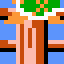

ssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssdsssssssssssssssdssddddsssssssssssdddfsfssssssssssdfssssssssssssesdssdddfsssssssessddddddsssssssfesddddddsssssssfefddddddsssssss


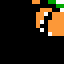

ssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssuuuusssssssssssuffwwusssssssssufwwwwwussssssssuwwwwwwussssssssuwwwwwwussssssssuwwwwwwusssssssssuwwwwusssssssssssuuuussssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss


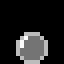

GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGffufufuGGGGGGGGGsfffffffffGGGGGGfufGGGGGGGGGGGGGfuffufufuGGGGGGGsffffffffffGGGGGsfffGGGGGGGGGGGGsfffGGGGGGGGGGGGsffffffffffGGGGGfuffufufuGGGGGGGfufGGGGGGGGGGGGGsfffffffffGGGGGGffufufuGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG


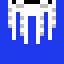

oqqqqqqqqqqqqqqoqllllllllllllllqqlqllllllllllqlqqllljjjjjjjjlllqqljjjjjjjjjjjjlqqjjjlllllllljjjqqjjljjjjjjjjqjjqqjjljjjjjjjjqjjqqjjjqqqqqqqqjjjqqqjjjjjjjjjjjjqqqqqqjjjjjjjjqqqqqlqqqqqqqqqqqqlqqlllqqqqqqqqlllqqlqllllllllllqlqqllllllllllllllqoqqqqqqqqqqqqqqo


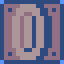

ssssssshshhsssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss


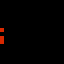

GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGddddddddGGGGGGddddddddddddGGGdddoooooooodddGGddoddddddddsddGGddoddddddddsddGGdddssssssssdddGGsddddddddddddsGGsssddddddddsssGGGssssssssssssGGGGGGssssssssGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG


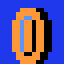

rrrsrrrddddsrrrsrrrsrdddddddrrrsrrrsddhhhddhrrrsrrrddhhhhhdhssssrrdddhhhhhdhfffsrddddhhhhhdfffffddddddhhhddfffffdddddddddddfffffddhhdddddddfffffdhhhhddddddffffdrhhhhddddddffddfrrhhhddddddhfffsrrrhdddhhddhrrrsrrrsdddhhhdhrrrsrrrsrdddhhddrrrsssssrrrddddsrrrs


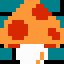

rkkkkkkkkkskkkkrkrrrrrrrrrskrrrskrrrrrrrrrrskrrskrrrrrrrrrrskrrskrrrrrrrrrrrskrskrrrrrrrrrrrskrskrrrrrrrrrrrskrskrrrrrrrrrrrsssrkrrrrrrrrrsskkkkissssssssskkrrrsikkkkrkkkkrrrrrsirrrsskrrrrrrrrsirrrrskrrrrrrrrsirrrrskrrrrrrrrskrrrrskrrrrrrrssrssssrsssssssssr


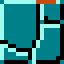

GGGGGGGGGGGGGGdGGGGGGGGGGGGGGGddGGGGGGGGGGGGGGddGGGGGGGGGGGGGGddGGGGGGGGGGGGGGGdGGGGGGGGGGGGGGGdGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG


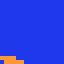

ssshhshsssssssssssshhshhsssssssssshhhhhhhssssssssshhhhhhhssssssssshhhhhhsssssssssshdhhhhsssssssssshdhdhhhsssssssshhhhdhhhsssssssshhhhdhhhsssssssshhdhdhhssssssssshhdddhshsssssssshhdddhhhsssssssshhdddhhsssssssssshhdddhsssssssssshhdddhhsssssssshhdfddhssssssss


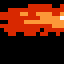

aaaassssssssssssaaaassssssssssssaaaassssssssssssaaaassssssssssssaaaassssssssssssaaaassssssssssssaaaassssssssssssaaaassssssssssssaaaassssssssssssaaaassssssssssssaaaassssssssssssaaaassssssssssssaaaassssssssssssaaaassssssssssssaaaassssssssssssaaaassssssssssss


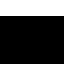

ooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooddoooooooooooddhddhddooooooohdhhhhhhdhooooddhhffhhhhhhddoodhhffhhhhhhhhdoohhhfhhhhhhhhhhoddhhhhhhhhhhhhdoddhhhhhhhhhhhhdoohhhhhhhhhhfhhhoodhhhhhhhhffhhd


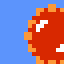

GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGfGGGGGGGGGGGGGGGfGGGGGGGGGGGGGGGfGGGGGGGGGGGGGGGfGGGGGGGGGGGGGGGfGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG


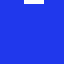

oooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooobbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbboooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


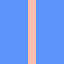

sshhddfdhhsssssshhshhddhhsssssssdhhshhhhssssssssddhsssssssssssssfdhsssssssssssssdhhssssssssssssshhsssssssssssssshsssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss


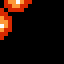

oooooooooooooooodooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooofooooooooooooooofooooooooooooooofooooooooooooooofooooooooooooooofooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


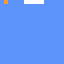

hddooooooooooooohhoooooooooooooohhhooooooooooooohhfooooooooooooohhffoooooooooooohfffooooooooooooffffooooooooooooffffooooooooooooddffooooooooooooddfooooooooooooohdfoooooooooooooodoooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


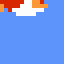

eeeeeeeeeenennsoeeeeeeeeenennnsoeeeeeeeeeenennsseeeeeeeeenennnsneeeeeeeeeensssnneeeeeesssssnnnnnsssssseeeeeeeeeeeeeeeeeeeeeeeeeennnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnneeeeeeeeeeeeeeeennnnnnnnnnnnnnnnnnnnnnnnnnnnnnnn


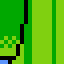

GGGGGfffffuuuuddGGGGGfffffGddddGGGGGGGffGGdddGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG


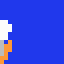

offeeeeeffooooooofeeffeefffoooooofeffeeeefffooooofeeeefeeffffoooofeffeeeefffffooofeeffeefffffffooffeeeeeffffffffffffffffffffffffffffffffffffffffoooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


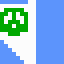

sssssssssssssssssssssssssssssssbsssssssssssssbsbsssssssssssbsbbrsssssssssssbbrirssssssssssrirrrrsssssssssssrrirrssssssssssssssrissssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss


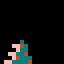

ibbbbbbbbbsbbbbibiiiiiiiiisbiiisbiiiiiiiiiisbiisbiiiiiiiiiisbiisbiiiiiiiiiiisbisbiiiiiiiiiiisbisbiiiiiiiiiiisbisbiiiiiiiiiiisssibiiiiiiiiissbbbbdsssssssssbbiiisdbbbbibbbbiiiiisdiiissbiiiiiiiisdiiiisbiiiiiiiisdiiiisbiiiiiiiisbiiiisbiiiiiiississssisssssssssi


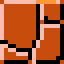

ssssssssssssssssshhhhhhhsssssssshhhhhhhhhhsssssshhdddddhhhhsssssddddddddhhhhssssddfffddhhhssssssdfffffddhhhsssssfffffffdddhhssssfffffffdddhhssssdfffffddhhhsssssddfffddhhhssssssddddddddhhhhsssshhdddddhhhhssssshhhhhhhhhhssssssshhhhhhhssssssssssssssssssssssss


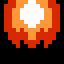

ooooooooooofhdddooooooooooofhdooooooooooooofhoooooooooooooofhoooooooooooooofhoooooooooooooofhoooooooooooooofhdhhooooooooooofhdddooooooooooofhdddooooooooooofhdooooooooooooofhoooooooooooooofhoooooooooooooofhoooooooooooooofhoooooooooooooofhdhhooooooooooofhddd


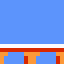

aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaoooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


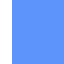

ooffffffhhhhhhhooooffffooohhhhddooooooooooooddddooooooooooooddddooooooooooodddoooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


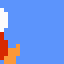

ddddddssssssssssdeddddduuuussssdddddsuffdffuusddfddsuddddddfudddddddddddfffffddddddddffffedeffdddduffeededeeefdussueeeeedeeeeffufffeeedeedeeedfudddffdeeeededefufffdfeeeeeedeefufffffdeeeededffuffffeedeedeeefddfsffeeeddeeeffddsffseedeedeefsddssssssssssssfssd


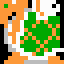

ooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooodddoo


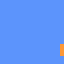

offeeeeeffooooooofeeffeefffoooooofeffeeeefffooooofeeeefeeffffoooofeffeeeefffffooofeeffeefffffffooffeeeeeffffffffdfffffffffffffffddddddddddddddddoooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


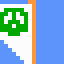

ooooooddddddoooooodddddedddddoooffeeefddddoooodofffffffddoodddddffffffddddddddffoddddddddddffffeooddddddoooeededoooooooooeeeeedeoooooffffeeedeedooofffdddffdeeeeooffddfffdfeeeeeoffdfffffffdeeeeffffffffffeedeedfffffffoffeeeddefffoffoffoeedeedffoooooooooooooo


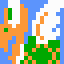

ooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooosbssssssssssssoosbssssssssssssooooibiiiiiiiioooossssssssssssssoosbssssiissssssoosbsssibbssssssoosbsssibbbsssssoosbsssssbbbssssoosbssssbbbbssssoossbssssbbbssssooossssssbbssssoooossssssssssssoo


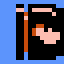

ibbbbbbbbbbbbbbsdibbbbbbbbbbbbssdbibbbbbbbbbbsssdbbibbbbbbbbssssdbbbiiiiiiiissssdbbbiiiiiiiissssbbbbiiiiiiiissssbbbbiiiiiiiissssbbbbiiiiiiiissssbbbbiiiiiiiissssbbbbiiiiiiiissssbbbbiiiiiiiissssdbbsssssssssisssdbsssssssssssissdsssssssssssssisdssssssssssssssi


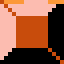

ooofGGfGGGGGGGGGooofGfGGGGGGGGGGoofGGGffGGGGGGGGofGGGGGGGGGGGGGGfGGGGGGGGGGGGGGGofffGGGfGGGGGGGGoooofGGfGGGGGGGGoooofGfGGGGGGGGGooofGGfGGGGGGGGGooofGfGGGGGGGGGGoofGGGffGGGGGGGGofGGGGGGGGGGGGGGfGGGGGGGGGGGGGGGofffGGGfGGGGGGGGoooofGGfGGGGGGGGoooofGfGGGGGGGGG


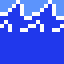

ssssshddfdhhssssssssshhddfdhsssssssssshhhddhshhhsssshssshdhhhhddsssssshshhhshddfssssshshhssshhddssssssssssssshhhssssssssssshssshssssssssssssshshsssssssssssshshhssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss


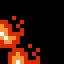

GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGfGGGGGGGGGGGGGGGfGGGGGGGGGGGGGGG


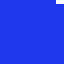

ooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooossssooooooooooosbssssooooooooosbsbssssooooooosbbbssssssooooossssssssssssoooossssssbbsssso


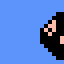

oooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooddoooooooooooddhddhddooooooohdhhhhhhdhooooddhhffhhhhhhdooodhhffhhhhhhhhooohhhfhhhhhhhhhooddhhhhhhhhhhhhooddhhhhhhhhhhhh


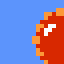

rkkkkkkkkkskkkkrtrrrrrrrrrskrrrstrrrrrrrrrrskrrstrrrrrrrrrrskrrstrrrrrrrrrrrskrstrrrrrrrrrrrskrskrrrrrrrrrrrskrskrrrrrrrrrrrsssrkrrrrrrrrrsskkkksssssssssskkrrrsrkkkkrkkkkrrrrrskrrrsskrrrrrrrrskrrrrskrrrrrrrrskrrrrskrrrrrrrrskrrrrskrrrrrrrssrssssrsssssssssr


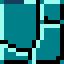

ooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooossssooooo


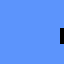

ooooooooooooooooooooooooooooddddooooooooooffeeefooooooooofffffffooooooooooffffffooooooooooodddddooooooooooooddddooooooooooooooooooooooooooooooofooooooooooooofffooooooooooooffddoooooooooooffdffooooooooooffffffooooooooofffffffoooooooooffffoffooooooooooffoooo


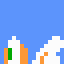

shhhhdhhhsssssssshhdhdhhssssssssshhdddhshsssssssshhdddhhhsssssssshhdddhhsssssssssshhdddhsssssssssshhdddhhsssssssshhdfddhsssssssssshdfdhhsssssssssshdfdhssssssssssssdfdhsssssssssssshhfhsssssssssssshhhssssssssssssssssssssssssssssssssssssssssssssssssssssssssss


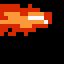

ssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssrisssssssssssrrirrssssssssssrirrrrsssssssssssbbrirsssssssssssbsbbrsssssssssssssbsbsssssssssssssssb


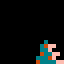

oooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooouuuuooooooooooouffwwuoooooooooufwwwwwuoooooooouwwwwwwuoooooooouwwwwwwuoooooooouwwwwwwuooooooooouwwwwuooooooooooouuuuoooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


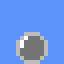

sssssssssssssssfsssssssssssssssfsssssssssssssssfsssssssssssssssfssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss


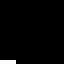

snnnnnnnnnnnnnsosnnnnnnnnnnnnnnssnnnnnnnnnnnnnnssnnnnnnnnnnnnnnssnnnnnnnnnnnnnnssnnnnnnnnnnnnnnssnnnnnnnnnnnnnsosnnnnnnnnnnnnsoosnnnnnnnnnnnnsoosnnnnnnnnnnnnnsosnnnnnnnnnnnnnnssnnnnnnnnnnnnnnssnnnnnnnnnnnnnnsssnnnnnnnnnnnnnsoossnnnnnnnnnnsooooossssssssssoo


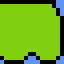

sssdddddsssssssssddwwwwwdsssssssdwwdddddwwdssssssdddddddddsssssssdddddddddssssssssdddddddsssssssssdddddddssssssssiwiiiiiiiwiwiwiswwwwwwwwwwwwwwwssdddddddsssssssssdddddddssssssssddddddddssssssssdddddddddssssssdssdddddssdssssssddsssssddsssssssssdddddssssssss


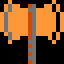

offeeeeeffooooooofeeffeefffoooooofeffeeeefffooooofeeeefeeffffoooofeffeeeefffffooofeeffeefffffffooffeeeeeffffffffnfffffffffffffffnnnnnnnnnnnnnnnnoooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


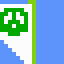

scnnnneennnnnennscnnnneennnnnennscnnnneennnnnennscnnnneennnnnennscnnnneennnnnennscnnnneennnnnennscnnnneennnnnennscnnnneennnnnennscnnnneennnnnennscnnnneennnnnennscnnnneennnnnennscnnnneennnnnennscnnnneennnnnennscnnnneennnnnennscnnnneennnnnennscnnnneennnnnenn


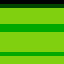

aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaassssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss


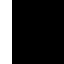

ooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooodddooooooooooooooddddoooooooooooodddddooooooooohhhhddoooooooooohhhhhooooooooooohhhhhhoooooooooohhhhhfoooooooooohhhhhffooooooooohhhhfffooooooooohhhffffooooooooohhhffffooooooooo


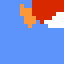

hssshdhssssssssshssshdhssssssssshdhhddhssssssssshdddddhsssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss


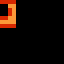

ooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooeeeeoooooooooooo


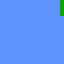

oooooooooooooooaoooooooooooooooaoooooooooooooooaoooooooooooooooaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaoooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


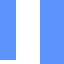

ssssssssssssssssssssssssssssddddssssssssssffhhhfsssssssssfffffffssssssssssffffffsssssssssssdddddssssssssssssddddsssssssssssssssssssssssssssssssfsssssssssssssfffssssssssssssffddsssssssssssffdffssssssssssffffffsssssssssfffffffsssssssssffffsffssssssssssffssss


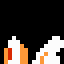

GGGGuffffffffsssGGGGfufffffffssfGGGGGfuufffffsfsGGGGGGffuufffsfsGGGGGGGfffuuffsfGGGGGGGGfffGGGGGGGGGGGGGGffGGGGGGGGGGGGGGGfGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG


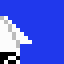

sssssssssssssssssiiiiiiiiiiiiiissisiiiiiiiiiisissiiiiiiiiiiiiiissiiiiiiiiiiiiiissiiiiiiiiiiiiiissiiiiiiiiiiiiiissiiiiiiiiiiiiiissiiiiiiiiiiiiiissiiiiiiiiiiiiiissiiiiiiiiiiiiiissiiiiiiiiiiiiiissiiiiiiiiiiiiiissisiiiiiiiiiisissiiiiiiiiiiiiiisssssssssssssssss


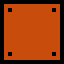

osnnnneennnnnennosnnnneennnnnennssnnnneennnnnennnsnnnneennnnnennnnsssneennnnnennnnnnnsssssnnnenneeeeeeeeeesssssseeeeeeeeeeeeeeeennnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnneeeeeeeeeeeeeeeennnnnnnnnnnnnnnnnnnnnnnnnnnnnnnn


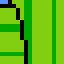

ssseeeeeedeesssdsseeeeeedfeeefddsseeeeeddeefddddssffeeeeddddddeessffdeeeeeeeeeeesffddeeeeeeeeeffsfddeeeeeeeeefffsfsssseeeeeeffffsssssssssfffffeesssssssssffffeeessssssssseeeeeeessssssssseefeeeesssssssssefffeeesssssssssfffdeeessssssssssdddeefssssssssssedeeef


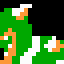

sssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssshssssssssssssssshhssssssssssssssdhhsssssssssssss


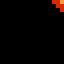

oooooooeedddddddooffeededoooooddfoeeeeeeeoooddedeeedeeedoooddeddeeeeedeeooddeddddeeeeeeooodedddoeededeooodeddoooeeeeoooooddooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


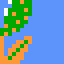

oooooooossssssssoooooossnnnnnnnnooooosnnnnnnnnnnoooosnnnnnnnnnnnooosnnnnnnnnnnnnooosnnnnnnnnnnnnoosnnnnnnnnnnnnnoosnnnnnnnnnnnnnoosnnnnnnnnnnnnnoosnnnnnnnnnnnnnooosnnnnnnnnnnnnooosnnnnnnnnnnnnoooosnnnnnnnnnnnooooosnnnnnnnnnnoooooossnnnnnnnnoooooooossssssss


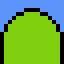

eeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeesssseeeeeeeeeeeesssseeeeeeeeeeeeeeeeeeeeeeeeesssseeeeeeeeeeesssssseeeeeeeeeeesssseeeeeeeeeeeeeeeeeeeeeeeeeee


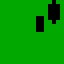

iiisiissssssssssiiisssssssssssssiissssssssssssssisssssssssssssssisssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssisssssssssssssssisssssssssssssssiissssssssssssssiiisssssssssssssssssiissssssssss


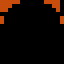

rrrsrrrsrrrsrrrsrrrsrrrsrrrsrrrsrrrsrrrsrrrsrrrsrrrsssssrrrsssssrrrsrrrsrrrsrrrsrrrsrrrsrrrsrrrsrrrsrrrsrrrsrrrsssssrrrsssssrrrsrrrsrrrsrrrsrrrsrrrsrrrsrrrsrrrsrrrsrrrsrrrsrrrsrrrsssssrrrssssstrrsrrrsrrrsrrrstrrsrrrsrrrsrrrstrrsrrrsrrrsrrrsssssrrrsssssrrrs


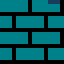

rrrsrrrsrrrsrrrsrrrsrrrsrrrsrrrsrrrsrrrsrrrsrrrsrrrsssssrrrsssssrrrsrrrsrrrsrrrsrrrsrrrsrrrsrrrsrrrsrrrsrrrsrrrsssssrrrsssssrrrsrrrsrrrsrrrsrrrsrrrsrrrsrrrsrrrsrrrsrrrsrrrsrrrsrrrsssssrrrsssssrrrsrrrsrrrsrrrsrrrsrrrsrrrsrrrsrrrsrrrsrrrsrrrsssssrrrsssssrrrs


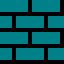

ssssssssssssssaassssssssssssssaassssssssssssssaassssssssssssssaassssssssssssssaassssssssssssssaassssssssssssssaassssssssssssssaassssssssssssssaassssssssssssssaassssssssssssssaassssssssssssssaassssssssssssssaassssssssssssssaassssssssssssssaassssssssssssssaa


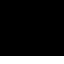

siiiiiiddddiiiiwiddddddddddddddwidwdddhhhddhdwdwiddddhhhhhdhdddwiddddhhhhhdhfffwiddddhhhhhdfffffddddddhhhddfffffdddddddddddfffffddhhdddddddfffffdhhhhddddddffffdihhhhddddddffddfidhhhddddddhfffwiddhdddhhddhdddwidwddddhhhdhdwdwidddddddhhdddddwswwwwwwddddwwwww


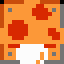

GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGdGhGGGGGGGGGGGGGddhGGGGGGGGGGGGGddhGGGGGGGGGGGGGddhGGGGGGGGGGGGGGdhGGGGGGGGGGGGGGdhGGGGGGGGGGGGGGGdGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG


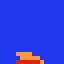

ooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooodddoooooooooooffeeeooooooooooffffffooooooooooofffffooooooooooooddddooooooooooooodddoooooooooooooooo


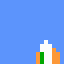

cccccccccccccccscnennnnnnnnnnncscnennnnnnnnnnncccnennnnnnnnnnncccneeeeeeeeeeeecccneeeeeeeeeeeecccnnnnnnnnnnnnncccnnnnnnnnnnnnncccnnnnnnnnnnnnncccnnnnnnnnnnnnncccnnnnnnnnnnnnncccnnnnnnnnnnnnncccneeeeeeeeeeeecccnennnnnnnnnnncccnennnnnnnnnnncccneeeeeeeeeeeecc


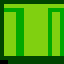

GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGfGGGGGGGGGGGGGGffGGGGGGGGGGGGGfffGGGGGGGGGGGGfffuuffsfGGGGGGffuufffsfsGGGGGfuufffffsfsGGGGfufffffffssfGGGGuffffffffsss


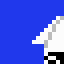

GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGfGGGGGGGGGGGGGGGfGGGGGGGGGGGGGGGfGGGGGGGGGGGGGGGfGGGGGGGGGGGGGGGfGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG


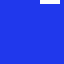

ibbbbbbbbbsbbbbibiiiiiiiiisbiiisbiiiiiiiiiisbiisbiiiiiiiiiisbiisbiiiiiiiiiiisbisbiiiiiiiiiiisbisbiiiiiiiiiiisbisbiiiiiiiiiiisssibiiiiiiiiissbbbbdsssssssssbbiiisdbbbbibbbbiiiiisdiiissbiiiiiiiisdiiiisbiiiiiiiisbiiiisbiiiiiiiisbiiiisbiiiiiiississssisssssssssi


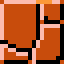

sssssssssfffffeesssssssssffffeeessssssssseeeeeeessssssssseefeeeesssssssssefffeeesssssssssfffdeeessssssssssdddeefssssssssssedeeefssssssssssseeeefsssssssssssffeeesssssssssssffdeesssssssssssfddeessssssssssssseeesssssssssssssffessssssssssssssssssssssssssssssss


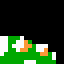

sssrirrririrrribsssrririrrririrbsssrrrirrrrrirrbsssrririrrriribbsssrirbririrrrbissssrrbbrirrrbbisssssrrririrrbsisssssssssssssbssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss


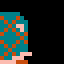

sssssssddddddssssssdddddedddddsssffeeefddddssssdffffffffddssddddsffffffddddddddfssddddddddddffffsssddddddssseedesssssssssseeeeedssssssffffeeedeessssfffdddffdeeesssffddfffdfeeeessffdfffffffdeeesffffffffffeedeeffffffffsffeeeddffffsffsffseedeesffsssssssssssss


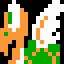

ssssssssssssssssssssssuuuuussssssssssufffffuusssssssufffffffuusssssufffffffffuussssufffffffffuuussufffffffffffuussufffffffffffuussufffffffffffuussufffffffffffuusssufffffffffuuusssufffffffffuuussssufffffffuusssssssufffffuusssssssssuuuuusssssssssssssssssssss


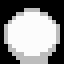

rkkkkkkkkkkkkkkskrkkkkkkkkkkkksskkrkkkkkkkkkkssskkkrkkkkkkkksssskkkkrrrrrrrrsssskkkkrrrrrrrrsssskkkkrrrrrrrrsssskkkkrrrrrrrrsssskkkkrrrrrrrrsssskkkkrrrrrrrrsssskkkkrrrrrrrrsssskkkkrrrrrrrrsssskkksssssssssrssskksssssssssssrssksssssssssssssrssssssssssssssssr


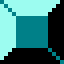

oiiiiiiiiiiiiiisiddddddddddddddsidsddddddddddsdsiddddddddddddddsidddiiiddddddddsiddiiiisdddddddsiddissssdddddddsiddisdddiidiiddsiddisddiiisiisdsiddiiiiisssdssdsidddiiiisddddddsiddddssssddddddsiddddddddddddddsidsddddddddddsdsiddddddddddddddsosssssssssssssss


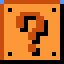

GGGGGGGfffffuuuuGGGGGGGfffffuuuuGGGGGGGfffffGdddGGGGGGGGffGGdddGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG


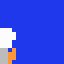

GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGffffGdGGGGGGGGGffhhffdhGGdGGGGGhffffhddhhdfGdGhffhhffhddddfGddhffffffhhdddfGddhhffffhhhhfffGddhhhhhhhhhhfffGGdhhhhhhhhhhhffGGdhhhhhffhhhhhfGGGdhhhfffhhhhhfGGGGGhffffhhhhhh


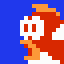

fhhhhuwsffffffwshhddhhwsfuuuuuwshddfdhhsfuuuuuwshhddfdhsfuuuuuwsfhhhddhhhhhuuuwsfuuhdhhhddhhuuwsfhuhhhhddfdhhwwshuhhuuhhddfdhsssfuuuuuwhhhddhfwsfuuuuhwsfhdhhuwswwwwwwwhfhhhuuwssssssshshhuuuuwsffffffwsfuuuuuwsfuuuuuwsfuuuuuwsfuuuuuwswwwwwwwsfuuuuuwsssssssss


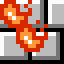

iiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiisssiiiiisssiisssiiiiisssiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiisssiiiiisssiisssiiiiisssiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiii


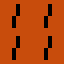

ooooooooddddoooooooooooodddddooofffooohhhhddooooffffhhhhhhhooooofffffhhhhhhhoooofffffhhhhhhfoooohhfffhhhhhhffooohhhhhhhhhhfffooohhhhhhhhhffffooohffffhhhhffffoooffffffhhdddffoooffhhffhddddfoooohffffhddhhdfooooffhhffdhoodooooooffffodooooooooooooooooooooooooo


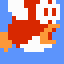

sssssssssssssssssssssssssasssssssssssssssaassssssssssssssaaasssssssssssssaaaasssaaaaaaaaaaaaaassaaaaaaaaaaaaaaasaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaasaaaaaaaaaaaaaassaaaaassssaaaasssaaaaassssaaassssaaaaassssaasssssaaaaassssassssssaaaaasssssssssss


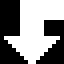

usbssssiissssssofssssssssssssssofffibiiiiiiiiooofsbssssssssssssofsbssssssssssssofffffffffffffuuuffffffffffffffuuffffffffffffffuuffffffffffffffuuffffffffffffffuufffffffffffffuuufffffffffffffuuuffffffffffffuuoofffffffffffuuoooffffffffuuuooooouuuuuuuuoooooooo


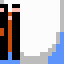

GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGffffGdGGGGGGGGGffuuffduGGdGGGGGuffffudduudf


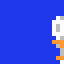

ddddddoooooooooodhdddddoooooooodddddoooodoooooddfddooddddddoodddddddddddfffffddddddddffffhdhffddddooohhdhdhhhfdoooohhhhhdhhhhffofffhhhdhhdhhhdfodddffdhhhhdhdhfofffdfhhhhhhdhhfofffffdhhhhdhdffoffffhhdhhdhhhfddfoffhhhddhhhffddoffohhdhhdhhfoddoooooooooooofood


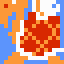

oddddddoooooooooddhdddddoooooooofddddoooodooooodffddooddddddooddfddddddddfffffddddddddffffhdhffddddooohhdhdhhhfdoooohhhhhdhhhhffooohdhhhdhdhhhdfooohhdhdhhhdhdhfooohhhdhhhhhdhhfooohhdhdhhhdhdffooohdhfhdhdhhhfdoooohhffhdhhhffdooooohhhdhdhhfodooooooooooooofoo


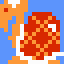

aaaaasssssssssssaaaaasssssssssssaaaaasssssssssssaaaaasssssssssssaaaaasssssssssssaaaaasssssssssssaaaaasssssssssssaaaaasssssssssssaaaaasssssssssssaaaaasssssssssssaaaaasssssssssssaaaaasssssssssssaaaaassssassssssaaaaassssaasssssaaaaassssaaassssaaaaassssaaaasss


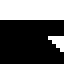

snnnnnnnnnnnnnsesnnnnnnnnnnnnnnssnnnnnnnnnnnnnnssnnnnnnnnnnnnnnssnnnnnnnnnnnnnnssnnnnnnnnnnnnnnssnnnnnnnnnnnnnsesnnnnnnnnnnnnseesnnnnnnnnnnnnnsesnnnnnnnnnnnnnnssnnnnnnnnnnnnnnssnnnnnnnnnnnnnnssnnnnnnnnnnnnnnssnnnnnnnnnnnnnnssnnnnnnnnnnnnnsesnnnnnnnnnnnnsee


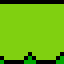

GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGffffGdGGGGGGGGGffhhffdhGGdGGGGGhffffhddhhdfGGGhffhhffhddddfGGGhffffffhhdddffGGhhffffhhhhffffGGhhhhhhhhhhffffGG


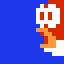

rrrsrrrsrrrsrrrsrrrsrrrsrrrsrrrsrrrsrrrsrrrsrrrsrrrsddddddddssssrrddddddddddddrsrdddiiiiiiiidddsrddiddddddddsddssddiddddddddsddsrdddssssssssdddsrsddddddddddddssrsssddddddddssssrrssssssssssssssrrrsssssssssrrrsrrrsrrrsrrrsrrrsrrrsrrrsrrrsrrrsssssrrrsssssrrrs


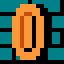

ooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooffffooohoooooooffffffhhhooooooofffffffhhooooooooffffffhhooooooodhhhfffhh


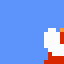

oooooooooooooooooooooooooooooooossssssssssssssssddddddddddddddddddddddddddddddddddddddddddddddddhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddhhhhhhhhhhhhhhhhdddddddddddddddddddddddddddddddd


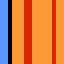

sfhssshdhssssssssfhssshdhssssssssfhdhhddhssssssssfhdddddhssssssssfhdddddhssssssssfhdssddhssssssssfhssshdhssssssssfhssshdhssssssssfhssshdhssssssssfhssshdhssssssssfhdhhddhssssssssfhdddddhsssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss


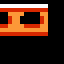

ibbbbbbbbbsbbbbibiiiiiiiiisbiiisbiiiiiiiiiisbiisbiiiiiiiiiisbiisbiiiiiiiiiiisbisbiiiiiiiiiiisbisbiiiiiiiiiiisbisbiiiiiiiiiiisssibiiiiiiiiissbbbbssssssssssbbiiissbbbbibbbbiiiiissiiissbiiiiiiiissiiiisbiiiiiiiisbiiiisbiiiiiiiisbiiiisbiiiiiiisssssssisssssssssi


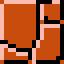

aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaasssssssssssssssasssssssssssssssasssssssssssssssasssssssssssssssasssssssssssssssasssssssssssssssasssssssssssssssasssssssssssssssasssssssssssssssasssssssssssssssasssssssssssssssasssssssssssssssasssssssssssssssa


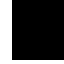

ssssshhddhhsssssssssshddfdhhssssssssshhddfdhsssssssssshhhddhsssssssshssshdhhsssssssssshshhhsssssssssshshhsssssssssshhhhssssssssssshhddhhsssssssssshddfdhhssssssssshhddfdhsssssssssshhhddhsssssssshssshdhhsssssssssshshhhsssssssshhhhhhsssssssssshddhhsssssssssss


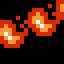

ssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss


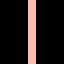

siiiiiisiiibbbbbsiiiiiisbbibbbbsssiiiisssbibbbsssssiisbbbbiibbssssssisiiiiiisssssssssiiiiiiissssssssssiiiiiissssssssssssiiisssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss


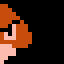

oooossssssssssoooosshhhhhdddddsooshhhhhhhdddddsoshhhhhhhhddddddsshhhhhhhhddddddsshhhhhhhhddddddsshhhhhhhdddddddsshhhhhhddddddddsshhhhddddddddddssdddddddhhhddddssddddddhhhhhdddssdddddhhhhhhhddssdddddhhhhhhhddssdddddhhhhhhhddssddddddhhhhhdddssdddddddhhhdddds


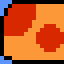

sssssssssssssssfsssssssssssssssfsssssssssssssssfsssssssssssssssfsssssssssssssssfsssssssssssssssfsssssssssssssssfffffffffffffffffffffffffffffffffsssssssssssssssfsssssssssssssssfsssssssssssssssfsssssssssssssssfsssssssssssssssfsssssssssssssssfsssssssssssssssf


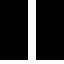

fhdddddhoooooooofhdooddhoooooooofhooohdhoooooooofhooohdhoooooooofhooohdhoooooooofhooohdhoooooooofhdhhddhoooooooofhdddddhoooooooofhdddddhoooooooofhdooddhoooooooofhooohdhoooooooofhooohdhoooooooofhooohdhoooooooofhooohdhoooooooofhdhhddhoooooooofhdddddhoooooooo


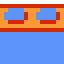

ooosbbbssssssooooooosbsbssssooooooooosbssssooooooooooossssoooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


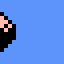

GGGGGGGGfGGGGGGGGGGGGGGffGGGGGGGGGGGGGfffGGGGGGfGGGGGfffuuffsffsGGGGffuufffsfssfGGGfuufffffsfssfGGfufffffffssffsGGuffffffffsssssGGuffffffffsssssGGfufffffffssffsGGGfuufffffsfssfGGGGffuufffsfssfGGGGGfffuuffsffsGGGGGGfffGGGGGGfGGGGGGGffGGGGGGGGGGGGGGGfGGGGGGG


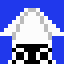

ooooooooioosssoooooooossissssssoooooosssissbsssboooossssiissssbbooossssssiiiiiibooosssssssssssiioosssssssssssssioossssssssssssssoossssssssssssssoosssiissssssssiooossibisssssssiooosssiissssssiioooossssssssssibooooosssssssssiboooooooossssssibooooooooooooooio


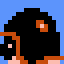

oooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooodddooooooooooooooddddoooooooooooodddddooooooooohhhhddooooooo


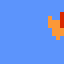

oiiiiiisiiibbbbboiiiiiisbbibbbbsooiiiisssbibbbssoooiisbbbbiibbssssssisiiiiiissssbbbbbiiiiiiibsssbbbbbbiiiiiibbssbbbbbbsbiiibbbsbbbbbbbsbbbbbbbsbbssssbbsbssssbbsbbbbbssbbbbbbssbssssssosssssssosoooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


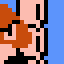

aaaaaaaaaaaaaaaaoaaaaaaaaaaaaaaaooaaaaaaaaaaaaaaoooaaaaoooooooooooooaaaooooooooooooooaaoooooooooooooooaooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


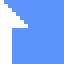

ssssssssssssssssssssssdssssssssssssssddsssssssssddssdddsssssssssffffdddsssssssssedeffddsssssssssdeeefdsssssssssseeeeffssssssssssdeeedfssssssssssededefsssssssssseedeefssssssssssededffssssssssssdeeefddssssssssseeeffddsssssssssdeefsddssssssssssssfssdsssssssss


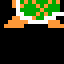

sssssssrriiiiiiisssssssrriiiiiiissbbrririsssssiibsrrrrrrrsssiirirrrirrrisssiiriirrrrrirrssiiriiiirrrrrrsssiriiisrririrsssiriisssrrrrsssssiisssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss


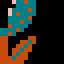

sssssssssssssssasssssssssssssssasssssssssssssssasssssssssssssssasssssssssssssssasssssssssssssssasssssssssssssssasssssssssssssssasssssssssssssssasssssssssssssssasssssssssssssssasssssssssssssssasssssssssssssssasssssssssssssssasssssssssssssssasssssssssssssssa


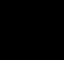

siiiiiiddddiiiisiddddddddddddddsidsdddhhhddhdsdsiddddhhhhhdhdddsiddddhhhhhdhfffsiddddhhhhhdfffffddddddhhhddfffffdddddddddddfffffddhhdddddddfffffdhhhhddddddffffdihhhhddddddffddfidhhhddddddhfffsiddhdddhhddhdddsidsddddhhhdhdsdsidddddddhhdddddssssssssddddsssss


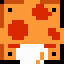

GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGffffGdGGGGGGGGGffuuffduGGdGGGGGuffffudduudfGdGuffuuffuddddfGdduffffffuudddfGdduuffffuuuufff


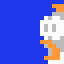

ssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssassssssssssssssaasssssssssssssaaassssssssssssaaaasssssssssssaaaaaaaaaaaaaasaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa


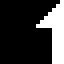

GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGffffGdGGGGGGGGGffuuffduGGdGGGGGuffffudduudfGdGuffuuffuddddfGdduffffffuudddfGdduuffffuuuufffGdduuuuuuuuuufffGGduuuuuuuuuuuffGGduuuuuffuuuuufGGGduuufffuuuuufGGGGGuffffuuuuuuGGGGGfffffuuuuuG


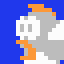

eeEseeesEEEEEEEeeEEEssseessEEeesEEEeeeeesEEeeeesEEeeEEEEEEeeeeesEEeEEEeeeEeeeessEeEEeeeeeEeeeessEeEEeeeeeeEeesssEeEEeeeeeeesssseEeeEeeeeeeeeeEEsEeeesseeeeeesEesEeeeEEssssessEesEeeEEeessssssEesEeEeeeeesssEEeesEeEeeeeesEEeeessssEeeeeeEseessssessEeeesssssssee


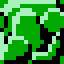

ssssssssssssssssssssssssssssssssssssssssssssssshsssssssssssssshhssssssssssssshhhsssssssssssshhhdsssssssssssshhddsssssssssssshhddsssssssssssshhddsssssssssssshhddsssssssssssshhhdssssssssssssshhhsssssssssssssshhssssssssssssssshssssssssssssssssssssssssssssssss


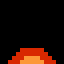

oqqqqqqjjjjqqqqoqlllljjjjjjjlllqqlqljjpppjjplqlqqlljjpppppjplllqqljjjpppppjpgggqqjjjjpppppjgggggjjjjjjpppjjgggggjjjjjjjjjjjgggggjjppjjjjjjjgggggjppppjjjjjjggggjqppppjjjjjjggjjgqlpppjjjjjjpgggqqllpjjjppjjplllqqlqljjjpppjplqlqqlllljjjppjjlllqoqqqqqqjjjjqqqqo


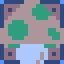

fffffffhhhhhhhoooffffffhhhhhhfoodhhhfffhhhhhhffodhhhhhhhhhhhfffodhhhhhhhhhhffffodhhffffhhhhffffodhffffffhhdddffoohffhhffhddddfoooohffffhddhhdfooooffhhffdhoodooooooffffodooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


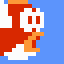

rkkkkkkkkkkkkkkstrkkkkkkkkkkkksstkrkkkkkkkkkkssstkkrkkkkkkkksssstkkkrrrrrrrrsssstkkkrrrrrrrrsssskkkkrrrrrrrrsssskkkkrrrrrrrrsssskkkkrrrrrrrrsssskkkkrrrrrrrrsssskkkkrrrrrrrrsssskkkkrrrrrrrrsssskkksssssssssrssskksssssssssssrssksssssssssssssrssssssssssssssssr


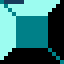

ooooossssssooooooosssffffffsssooosffffffffsfffsosffffffffffffffssffffffffffffffssffffffffffsfffssfffffsssfffsffssfffffffffffsfsosfffffffffffsfsosfffffsssfffsffssffffffffffsfffssffffffffffffffssffffffffffffffsosffffffffsfffsooosssffffffsssooooooossssssooooo


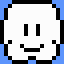

biisiiisiiisiiisbiisiddsiiisiiisbiisidddiiisiiddbiissddddiidddddbiisiddddddddddsbiisddddddddddisbiddddhhhdddddisdddddddddddddiisdddddddddddddiisbiddddhhhdddddisbiisddddddddddisbiissddddddddddsbiisiddddiidddddbiisidddiiisiiddbiisiddsiiisiiisbsssiiisssssiiis


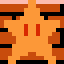

sssssssssssssssssrrrrrrrrrrrrrrssrsrrrrrrrrrrsrssrrrrrrrrrrrrrrssrrrrrrrrrrrrrrssrrrrrrrrrrrrrrssrrrrrrrrrrrrrrssrrrrrrrrrrrrrrssrrrrrrrrrrrrrrssrrrrrrrrrrrrrrssrrrrrrrrrrrrrrssrrrrrrrrrrrrrrssrrrrrrrrrrrrrrssrsrrrrrrrrrrsrssrrrrrrrrrrrrrrsssssssssssssssss


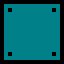

ooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooffffooooooooooofffffooooooooooofffffooooooooooooffffooooooooooodhhhfooooooooooodhhhhooooooooooddhhhhooooooooooddhhffooooooooooddhfffoooooooooodohffhooooooooooooohffoooooooooooooffhooooooooooooooff


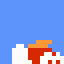

ssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssedssssssssssseedeessssssssssedeeeesssssssssssffedesssssssssssfsffesssssssssssssfsfsssssssssssssssfssssssssssssssss


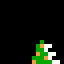

ooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooddoooooooooooddhddhddooooooohdhhhhhhdhoooooohhffhhhhhhddoooohffhhhhhhhhdoooo


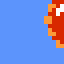

ooooooooooooooooooooooodoooooooodoooooddoooooooodddoodddoooooooofffffdddoooooooofedeffddooooooooedeeefdooooooooodeeeeffoooooooooedeeedfoooooooooeededefoooooooooeeedeefoooooooooeededffoooooooooedeeefddoooooooodeeeffddooooooooedeefoddoooooooooooofoodoooooooo


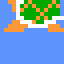

ssssssssiiisssssssssssiiiiiisssssssssiiiiiiissssssssisiiiiiisssssssiisbbbbiibbssssiiiisssbibbbbssiiiiiisbbibbbbbsiiiiiisiiibbbbbsiiiiiisiiibbbbbsiiiiiisbbibbbbsssiiiisssbibbbsssssiisbbbbiibbssssssisiiiiiisssssssssiiiiiiissssssssssiiiiiissssssssssssiiisssss


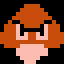

aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaassssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss


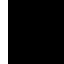

ooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooeoooooooooooooooeoooooooooooooooeooooooooooooooo


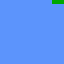

hffhhffhddddfGGGhffffffhhdddffGGhhffffhhhhffffGGhhhhhhhhhhffffGGhhhhhhhhhhhfffGGhhhhhffhhhhhffGGdhhhfffhhhhhfGGGGGhffffhhhhhhGGGGGfffffhhhhhGGGGGGfffffhhhhddGGGGGfffffGddddGGGGGGGffGGdddGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG


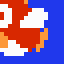

hddhhssssssssssshhhhssssssssssssshssshhhsssssssssshshhdhhsssssssshsshdddhsssssssshhhhdfdhsssssssshhddfdhhssssssssshhddhhssssssssssshhhhssssssssssssssshssssssssssssshssshhhsssssssssshshhdhhsssssssshsshdddhsssssssshhhhdfdhsssssssshhddfdhhssssssssshhddhhsssss


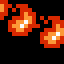

GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGffffGdGGGGGGGGGffuuffduGGdGGGGGuffffudduudfGGGuffuuffuddddfGGGuffffffuudddffGGuuffffuuuuffffGGuuuuuuuuuuffffGGuuuuuuuuuuufffGGuuuuuffuuuuuffGGduuufffuuuuufGGGGGuffffuuuuuuGGGGGfffffuuuuuGGGG


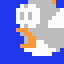

ooooooooioosssoooooooossissssssoooooosssissbsssboooossssiissssbbsssssssssiiiiiibbbbsssssssssssiibbsssssssssssssibbssssssssssssssbbssssssssssssssbssssiissssssssibbbssibisssssssissssssiissssssiioooossssssssssibooooosssssssssiboooooooossssssibooooooooooooooio


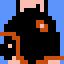

sssssssssssssssfsssssssssssssssfsssssssssssssssfsssssssssssssssfsssssssssssssssfsssssssssssssssfsssssssssssssssfbbbbbbbbbbbbbbbfbbbbbbbbbbbbbbbfsssssssssssssssfsssssssssssssssfsssssssssssssssfsssssssssssssssfsssssssssssssssfsssssssssssssssfsssssssssssssssf


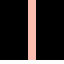

ooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooee


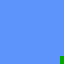

fhGGGhdhGGGGGGGGfhGGGhdhGGGGGGGGfhdhhddhGGGGGGGGfhdddddhGGGGGGGGfhdddddhGGGGGGGGfhdGGddhGGGGGGGGfhGGGhdhGGGGGGGGfhGGGhdhGGGGGGGGfhGGGhdhGGGGGGGGfhGGGhdhGGGGGGGGfhdhhddhGGGGGGGGfhdddddhGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG


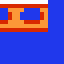

eeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeneneneneneneneneenenenenenenenennenenenenenenenennnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnssssssssssssssssoooooooooooooooooooooooooooooooo


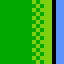

ooooooooooooooooooooooooooooooffooooooooooooofffooooooooooooofffooooooooooooooffooooooooooooodhhooooooooooooodhhooooooooooooddhhooooooooooooddhhooooooooooooddhfoooooooooooodohfooooooooooooooohooooooooooooooofoooooooooooooooooooooooooooooooooooooooooooooooo


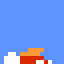

sssssaaaaaassssssssssaaaaaassssssssssaaaaaassssssssssaaaaaassssssssssaaaaaassssssssssaaaaaassssssssssaaaaaassssssssssaaaaaassssssssssaaaaaassssssssssaaaaaassssssssssaaaaaassssssssssaaaaaassssssssssaaaaaassssssssssaaaaaassssssssssaaaaaassssssssssaaaaaasssss


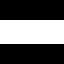

GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGffffGdGGGGGGGGGffuuffdGGGGGGGGGuffffudGGGGGGdGuffuuffuGGGGGGdduffffffuGGGGGGdduuffffuuGGGGGGdduuuuuuuuGGGGGGGduuuuuuuu


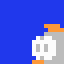

sssssssssssssssssssssssssssssssswwwwwwwwwwwwwwwwffffffffffffffffffffffffffffffffffffffffffffffffuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffuuuuuuuuuuuuuuuuffffffffffffffffffffffffffffffff


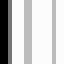

GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGffufufuGGGGGGGGfsfffffffffGGGGGsfufGGGGGGGGGGGGsfuffufufuGGGGGGfsffffffffffGGGGssfffGGGGGGGGGGG


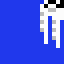

GGfffffuuuuddGGGGGfffffGddddGGGGGGGffGGdddGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG


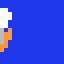

ooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooossooooooooooooosnnsoooooooooooosnnnoooooooooosnnnnnooooooooosnnnnnnoooooooosnnnnnnnoooooooosnnnnnnnoooooooosnnnnnnn


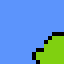

oddddddoooooooooddedddddoooooooofddddoooodooooodffddooddddddooddfddddddddfffffddddddddffffedeffddddoooeededeeefdooooeeeeedeeeeffoooedeeededeeedfoooeededeeededefoooeeedeeeeedeefoooeededeeededffoooedefededeeefdooooeeffedeeeffdoooooeeededeefndoooooooosnnnnfnn


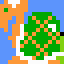

sssssfhssshdhssssssssfhssshdhssssssssfhdhhddhssssssssfhdddddhssssssssfhdddddhssssssssfhdssddhssssssssfhssshdhssssssssfhssshdhssssssssfhssshdhssssssssfhssshdhssssssssfhdhhddhssssssssfhdddddhssssssssfhdddddhssssssssfhdssddhssssssssfhssshdhssssssssfhssshdhsss


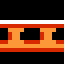

oooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooffffoooooooooooffffffhhoooooooofffffffhoooooooooffffffhoooooooodhhhfffhoooooooodhhhhhhhoooooooddhhhhhhhoooooooddhhffffh


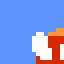

siiiiiisssssssssiiriiiiissssssssbiiiissssisssssibbiissiiiiiissiibiiiiiiiibbbbbiiiiiiiibbbbrirbbiiiisssrririrrrbissssrrrrrirrrrbbsssrirrririrrribsssrririrrririrbsssrrrirrrrrirrbsssrririrrriribbsssrirbririrrrbissssrrbbrirrrbbisssssrrririrrbsisssssssssssssbss


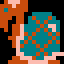

ooooooodddddooooffooohhhhddooooofffhhhhhhhooooooffffhhhhhhhoooooffffhhhhhhfooooohfffhhhhhhffoooohhhhhhhhhfffoooohhhhhhhhffffooooffffhhhhffffoooofffffhhdddffoooofhhffhddddfoooooffffhddhhdfooooofhhffdhoodooooooffffodoooooooooooooooooooooooooooooooooooooooooo


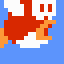

ssssssssiiisssssssssssiiiiiisssssssssiiiiiiissssssssisiiiiiisssssssiisbbbbiibbssbbiiiisssbibbbbsbiiiiiisbbibbbbbbiiiiiisiiibbbbbbiiiiiisiiibbbbbbiiiiiisbbibbbbsbbiiiisssbibbbsssssiisbbbbiibbssssssisiiiiiisssssssssiiiiiiissssssssssiiiiiissssssssssssiiisssss


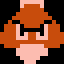

ssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssiiisiiisiiisiiisiiisiiisiiisiiisiiisiiisiiisiiisiiisssssiiisssssiiisiiisiiisiiisiiisiiisiiisiiisiiisiiisiiisiiisssssiiisssssiiis


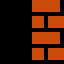

GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGdGGGGGGGGGGGGGGGddGGGGGGGGGGGGGGddGGGGGGGGGGGGGGdd


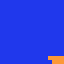

sssssssssssshssssssssssssshssshhssssssssssshshhdsssssssssshsshddsssssssssshhhhdfssssshsssshhddfdssshssshhhshhddhsssshshhdhhshhhhssshsshdddhsssssssshhhhdfdhssssshhhhhddfdhhssssshdhhhhddhhssssssdddhshhhhsssssssdfdhssssssssssssfdhhssssssssssssdhhsssssssssssss


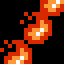

eeeeeeeeiiieeeeeeeeessiiiiiieeeeeeeesiiiiiiieeeeeeeeisiiiiiieessessiisbbbbiibbssssiiiisssbibbbbseiiiiiisbbibbbbbeiiiiiisiiibbbbbeiiiiiisiiibbbbbeiiiiiisbbibbbbseeiiiisssbibbbsseeeiisbbbbiibbsseeeeisiiiiiiessseeeeeiiiiiiiessseeeeeeiiiiiieesseeeeeeeeiiieeeee


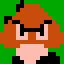

sssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssasssssssssssssssasssssssssssssssasssssssssssssssasssssssssssssssasssssssssssssssasssssssssssssssasssssssssssssssasssssssssssssssasssssssssssssssa


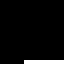

swwwwwwwwhhddfdhwiiiiiiiiihhhddhwiwiiiiihiiihdhhwiiiiiiiiihihhhwwiiiiiihhhhhhiiwwiiiiihhddhhiiiwwiiiiihddfdhhiiwwiiiiihhddfdhiiwwiiiiiihhhddhiiwwiiiihiiihdhhiiwwiiiiiihihhhiiiwwiiiiihihhiiiiiwwiiiiiiiiiiiiiiwwiwiiiiiiiiiiwiwwiiiiiiiiiiiiiiwswwwwwwwwwwwwwws


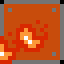

fuuuuuwsffffffwsfuuuuuwsfuuuuuwswwwwwwwsfuuuuuwsssssssssfuuuuuwsffffffwsfuuuuuwsfuuuuuwsfuuuuuwsfuuuuuwswwwwwwwsfuuuuuwsssssssssfuuuuuwsffffffwsfuuuuuwsfuuuuuwswwwwwwwsfuuuuuwsssssssssfuuuuuwsffffffwsfuuuuuwsfuuuuuwsfuuuuuwsfuuuuuwswwwwwwwsfuuuuuhhhhssssss


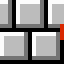

sssedeeededeeedfssseededeeededefssseeedeeeeedeefssseededeeededffsssedefededeeefdsssseeffedeeeffdssssseeededeefsdsssssssssssssfssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss


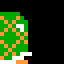

aaaaasssssssssssaaaaasssssssssssaaaaasssssssssssaaaaasssssssssssaaaaasssssssssssaaaaasssssssssssaaaaasssssssssssaaaaasssssssssssaaaaasssssssssssaaaaasssssssssssaaaaasssssssssssaaaaasssssssssssaaaaasssssssssssaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa


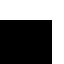

oooooooouuuuuuuuoooooouuffffffffooooouffffffffffooooufffffffffffooouffffffffffffooouffffffffffffooufffffffffffffooufffffffffffffooufffffffffffffooufffffffffffffooouffffffffffffooouffffffffffffooooufffffffffffooooouffffffffffoooooouuffffffffoooooooouuuuuuuu


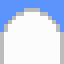

GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGffffGdGGGGGGGGGffuuffd


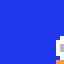

ooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooofohhooooooooooohfhfhoooooofffffhfhhhooooooodddfdhfhhdoooooooddddhhfdd


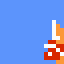

fuuuuuwsffffffwsfuuuuuwsfuuuuuwswwwwwwwsfuuuuuwsssssssssfuuuuuwsffffffwhhhhuuuwsfuuuuuhhddhhuuwsfuuuuuhddfdhhwwsfuuuuuhhddfdhsssfuuuuuwhhhddhfwsfuuuuhwsfhdhhuwswwwwwwwhfhhhuuwssssshhhhhhuuuuwsfffhhddhhuuuuuwsfuuhddfdhhuuuuwsfuuhhddfdhwwwwwsfuuuhhhddhssssss


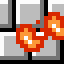

sssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssfsssssssssssssssffssssssssssssssfffsssssssssssssffffssssssssssssfffffsssssssssssffffffssssssssssfffffffsssssssssffffffffsssssss


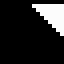

rkkkkkkkkkskkkkrkrrrrrrrrrskrrrskrrrrrrrrrrskrrskrrrrrrrrrrskrrskrrrrrrrrrrrskrskrrrrrrrrrrrskrsrrrrrrrrrrrrskrsrrrrrrrrrrrrsssrrrrrrrrrrrsskkkkrssssssssskkrrrsrkkkkrkkkkrrrrrskrrrsskrrrrrrrrskrrrrskrrrrrrrrskrrrrskrrrrrrrrskrrrrskrrrrrrrsskssssrsssssssssr


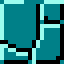

eoooooooooooooooooooooooooooooooooooooooooooooooeoooooooooooooooeoooooooooooooooeoooooooooooooooeooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


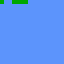

GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGfGGGGGGGGGGGGGGGfGGGGGGGGGGGGGGGfGGGGGGGGGGGGGGGfGGGGGGGGGGGGGGGfGGGGGGGGGGGGGGG


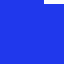

fuhuuuhdhhffffwsfuuuhuhhhuuuuuwswhhhhhhsfuuuuuwshhddhhssfuuuuuwshddfdhhsfuuuuuwshhddfdhsfuuuuuwsfhhhddhswwwwwwwsfuuhdhhsssssssssfhuhhhwsffffffwshuhhuuwsfuuuuuwshhwwwwwsfuuuuuwsdhhsssssfuuuuuwsfdhhffwsfuuuuuwsdfdhuuwsfuuuuuwshddhuuwswwwwwwwshdhhuuwsssssssss


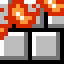

ooooooooooooooofoooooooooooooodhoooooooooooooodhoooooooooooooddhoooooooooooooddhoooooooooooooddhooooooooooooodohoooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


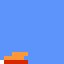

oiiiiiiiiiiiiiisdddddddddddddddsddsddddddddddsdsdddddddddddddddsddddiiiddddddddsdddiiiisdddddddsiddissssdddddddsiddisdddiidiiddsiddisddiiisiisdsiddiiiiisssdssdsidddiiiisddddddsiddddssssddddddsdddddddddddddddsddsddddddddddsdsdddddddddddddddsdsssssssssssssss


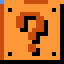

ooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooddoooooooooooooodh


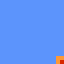

GGGGGGGGGGGGGGGGGffffGdGGGGGGGGGffhhffdhGGdGGGGGhffffhddhhdfGGGGffhhffhddddfGGGGffffffhhdddffGGGhffffhhhhffffGGGhhhhhhhhhffffGGGhhhhhhhhhhfffGGGhhhhffhhhhhffGGGhhhfffhhhhhfGGGGGhffffhhhhhhGGGGGfffffhhhhhGGGGGGfffffhhhhddGGGGGfffffGddddGGGGGGGffGGdddGGGGGGG


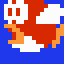

oooooooooddeffffoooooooooddeffffoooooooooddeffeeooooooooodddefffoooooooooddeffeeoooooooooodeffffoooooooooooeffffooooooooooooeeeeoooooooooooooooooooooooooooooooooooooooooooooooodooooooooooooooodooooooooooooooohoooooooooooooooddooooooooooooooddoooooooooooooo


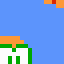

GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGfGdGGGGGGGGGGGGGffduGGdGGGGGGGGGfudduudfGGGGGGGGffuddddfGGGGGGGGffuudddffGGGGGGGfuuuuffffGGGGGGGuuuuuffffGGGGGGGuuuuuufffGGGGGGGffuuuuuffGGGGGGGffuuuuufGGGGGGGGffuuuuuuGGGGGGGGffuuuuuGGGGGGGGGffuuuuddGGGGGGGG


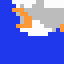

ooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooeeeeooooooooooooffffeeeooooooooofffefffeooooooooffffffffeoooooooffffffffeoooooooffffefffeoooooooeefffeffeooooooofffffefeoooooooofffffefeooooooooeefffeffeoooooooffffefffeoooooooffffffffeooooooo


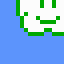

sssssssssssssssssssssssssssssssssssssssssssssssshhssssssssssssssdhhsssssssssssssddhsssssssssssssfdhsssssssssssssdhhssssssssssssshhsssssssssssssshssssssssssssssshssssssssssssssssshhhsssssssssssshhdhhssssssssssshdddhsssssssssshhdfdhssssssssssddfdhhssssssssss


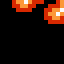

sssssssssssssaaasssssssssssssaaasssssssssssssaaasssssssssssssaaasssssssssssssaaasssssssssssssaaasssssssssssssaaasssssssssssssaaasssssssssssssaaasssssssssaaaaaaassssssssssaaaaaasssssssssssaaaaassssssssssssaaaasssssssssssssaaassssssssssssssaasssssssssssssssa


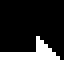

oooooooooooooooaoooooooooooooooaoooooooooooooooaoooooooooooooooaoooooooooooooooaoooooooooooooooaoooooooooooooooaoooooooooooooooaoooooooooooooooaoooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


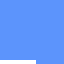

GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGffffGdGGGGGGGGGffuuffduGGGGGGGGuffffudduuGGGdGuffuuffudddGGGdduffffffuuddGGGdduuffffuuuufGGGdduuuuuuuuuufGGGGduuuuuuuuuuuGGGGduuuuuffuuuuGGGGGduuufffuuuuGGGGGGGuffffuuuu


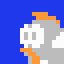

ooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooeeoooooooooooooeeeooooooooooodddddooooooooooddeeee


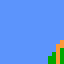

hdddddhssssssssshdssddhssssssssshssshdhssssssssshssshdhssssssssshssshdhssssssssshssshdhssssssssshdhhddhssssssssshdddddhssssssssshdddddhssssssssshdssddhssssssssshssshdhssssssssshssshdhssssssssshssshdhssssssssshssshdhssssssssshdhhddhssssssssshdddddhsssssssss


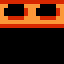

GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGffffGdGGGGGGGGGffuuffduGGdGGGGGuffffudduudfGGGGffuuffuddddfGGGGffffffuudddffGGGuffffuuuuffffGGGuuuuuuuuuffffGGGuuuuuuuuuufffGGGuuuuffuuuuuffGGGuuufffuuuuufGGGGGuffffuuuuuuGGGGGfffffuuuuuGGGGGGfffffuuuuddGGGGGfffffGddddGGGGG


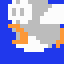

eeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeemdddeeeeeemmmeemmdddemeehmddmemmmmdhhmehhmmmddmmmhhhhmehhmdmddhhhdhhheehhdddddmmhhhhee


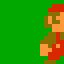

ssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssnneesssssssssssneeeeesssssssssseeeeeesssssssssseeeeeesssssssssseeeeeessssssssssseeeessssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss


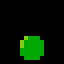

iiisiiisiiisiiisiiisiiisiiisiiisiiisiiisiiisiiisiiisssssiiisssssiiisiiisiiisiiisiiisiiisiiisiiisiiisiiisiiisiiisssssiiisssssiiisssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss


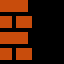

GGGGGfhGGGhdhGGGGGGGGfhGGGhdhGGGGGGGGfhdhhddhGGGGGGGGfhdddddhGGGGGGGGfhdddddhGGGGGGGGfhdGGddhGGGGGGGGfhGGGhdhGGGGGGGGfhGGGhdhGGGGGGGGfhGGGhdhGGGGGGGGfhGGGhdhGGGGGGGGfhdhhddhGGGGGGGGfhdddddhGGGGGGGGfhdddddhGGGGGGGGfhdGGddhGGGGGGGGfhGGGhdhGGGGGGGGfhGGGhdhGGG


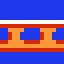

ooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooodddooooooooooooooddddoooooooooooodddddooffffooohhhhddooffffffhhhhhhhooo


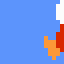

fffffhhhhhhfoooohhfffhhhhhhffooohhhhhhhhhhfffooohhhhhhhhhffffooohffffhhhhffffoooffffffhhdddffoooffhhffhddddfoooohffffhddhhdfooooffhhffdhoodooooooffffodooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


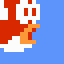

fGGGGGGGGGGGGGGGfGGGGGGGGGGGGGGGfGGGGGGGGGGGGGGGfGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG


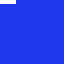

sneeeeeeeeeeeesssneeeeeeeeeeeesssneeeeeeeeeeeesssneeeeeeeeeeeesssneeeeeeeeeeeesssneeeeeeeeeeeesssneeeeeeeeeeeesssneeeeeeeeeeeesssneeeeeeeeeeeesssnenenenenenensssneenenenenenesssnenenenenenensssneenenenenenesssnennnnnnnnnnnsssnennnnnnnnnnnsossssssssssssssso


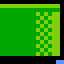

ooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooodooooooooooooooodooooooooooooooodooooooooooooooodoooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


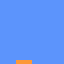

bbbbbbbbbbbbbbbbbsbbssssssssssbsbsbbssssssssssbsossssssssssssssoobsbbsssssbbbbbbobsbbssssbssssssobsbbsssbssbbsssobsbbsssbsbssissobsbbsssbsbssissobsbbsssbssiisssobsbbssssissssssobsbbsssssiiiiiiobsbbssssssssbsobbbbbbbbbbbbbbbbbsbbssssssssssbsbsbbssssssssssbs


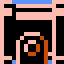

ooooooooooooddddooooooooooooddddoooffffooohhhhddooffffffhhhhhhhooofffffffhhhhhhhoooffffffhhhhhhfoodhhhfffhhhhhhfoodhhhhhhhhhhhffoddhhhhhhhhhhfffoddhhffffhhhhfffoddhffffffhhdddfodohffhhffhddddfoooohffffhddhhdfooooffhhffdhoodooooooffffodooooooooooooooooooooo


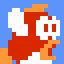

eeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeiiieeeeeeeeeeeiiiiiieeeeeeeeeiiiiiiieeeeeeeeisiiiiiieesseeeiisbbbbiibbsseeiiiisssbibbbbseiiiiiisbbibbbbbeiiiiiisiiibbbbb


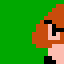

ssssfssfssssffssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss


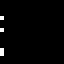

oooooooouuuuuuuuoooodouuffffffffooodduffffffffffoodddfffffffffffffdddfffffffffffeffddfffffffffffeefdffffffffffffeeffffffffffffffeedfffffffffffffedefffffffffffffdeefffffffffffffedffffffffffffffeefddfffffffffffeffdduffffffffffefoddouuffffffffofoodooouuuuuuuu


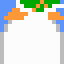

ssssssssssssssssbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbssssssssssssssss


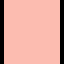

seffdddddhfdddhfoseedddddhddddhfooseeeddhhhddhhfoooseeeeffhhhhffooooseefdddhhhfdooooosfddddhhffdooooofddddhhhfedoooooooseeeehfeeooooooooseeeeeeeoooooooooseeeeeeooooooooooseeeeeoooooooooooseeeeooooooooooooseeeoooooooooooooseeooooooooooooooseooooooooooooooos


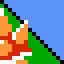

oooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooddddddoooooooooddedddddoooooooofddddoooodooooodffddooddddddooddfddddddddfffffddddddddffffedeffddddoooeededeeefdooooeeeeedeeeeff


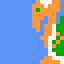

hhhhhhhhhhhfffGGhhhhhffhhhhhffGGdhhhfffhhhhhfGGGGGhffffhhhhhhGGGGGfffffhhhhhGGGGGGfffffhhhhddGGGGGfffffGddddGGGGGGGffGGdddGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG


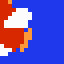

aaaaaaaaaaaaaaasaaaaaaaaaaaaaaasaaaaaaaaaaaaaassaaaaaaaaaaaaasssaaaassssaaaassssaaaassssaaasssssaaaassssaassssssaaaassssasssssssaaaassssssssssssaaaassssssssssssaaaassssssssssssaaaassssssssssssaaaassssssssssssaaaassssssssssssaaaassssssssssssaaaassssssssssss


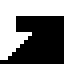

eiiiiiisiiibbbbbeiiiiiisbbibbbbseeiiiisssbibbbsseeeiisbbbbiibbssesssisiiiiiiessssssssiiiiiiiesssesssseiiiiiieesseeeeeeeeiiieeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee


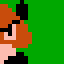

GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGffffGdGGGGGGG


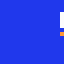

ibbbbbbbbbsbbbbibiiiiiiiiisbiiisbiiiiiiiiiisbiisbiiiiiiiiiisbiisbiiiiiiiiiiisbisbiiiiiiiiiiisbisbiiiiiiiiiiisbisbiiiiiiiiiiisssibiiiiiiiiissbbbbssssssssssbbiiisibbbbibbbbiiiiisbiiissbiiiiiiiisbiiiisbiiiiiiiisdiiiisbiiiiiiiisdiiiisbiiiiiiissdssssisssssssssi


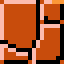

ssssssssssssssssbbbbbbibbbbbbbbbbbbbbbbibbbbbbbbbbbbbbbibbbbbbbbbbbbbbibbbbbbbbbbbbbbibbbbbbbbbbbbbbbbibbbbbbbbbbbbbbbbibbbbbbbbbbbbbbbibbbbbbbbbbbbbbibbbbbbbbbbbbbbibbbbbbbbbbbbbbbbibbbbbbbbbbbbbbbbibbbbbbbbbbbbbbbibbbbbbbbbbbbbbibbbbbbbbbssssssssssssssss


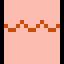

ooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooaooooooooooooooaaoooooooooooooaaaooooooooooooaaaaoooooooooooaaaaaaaaaaaaaaoaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa


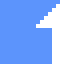

ooooooooooooooosooooooooooooooseoooooooooooooseeooooooooooooseeeoooooooooooseeeeooooooooooseeeeeoooooooooseeeeeeooooooooseeeeeeeoooooooseeeeeeeeooooooseeeeeeeeeoooooseeeeeeeeeeooooseeeeeeeeeeeoooseeeeeeeeeeeeooseeeeeeeeeeeeeoseeeeeeeeeeeeeeseeeeeeeeeeeeeee


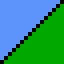

sssssssrriiiiiiissbbrririsssssiibsrrrrrrrsssiirirrrirrrisssiiriirrrrrirrssiiriiiirrrrrrsssiriiisrririrsssiriisssrrrrsssssiisssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss


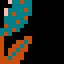

oooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooaoooooooooooooooaoooooooooooooooaoooooooooooooooaoooooooooooooooaoooooooooooooooaoooooooooooooooaoooooooooooooooaoooooooooooooooaoooooooooooooooa


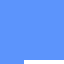

sffeeeeeffsssssssfeeffeefffssssssfeffeeeefffsssssfeeeefeeffffssssfeffeeeefffffsssfeeffeefffffffssffeeeeeffffffffnfffffffffffffffnnnnnnnnnnnnnnnnssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss


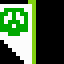

GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGfGGGGGGGGGGGGGGG


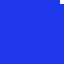

oooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooofooooooooooooooofooooooooooooooofooooooooooooooofooooooooooooooofooooooooooooooooooooooooooooooooooooooooooooooo


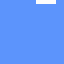

sssssssssssssssssssssssssssssssfsssssssssssssfsfsssssssssssfsffesssssssssssffedessssssssssedeeeessssssssssseedeessssssssssssssedssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss


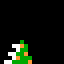

sssssssssssssssasssssssssssssssasssssssssssssssasssssssssssssssasssssssssssssssassssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss


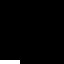

ffffeeeooooooooofffefffeooooooooffffffffeoooooooffffffffeoooooooffffefffeoooooooeefffeffeooooooofffffefeoooooooofffffefeooooooooeefffeffeoooooooffffefffeoooooooffffffffeoooooooffffffffeooooooofffefffeooooooooffffeeeoooooooooeeeeoooooooooooooooooooooooooooo


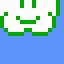

osnnnneennnnnennosnnnneennnnnennosnnnneennnnnennosnnnneennnnnennosnnnneennnnnennosnnnneennnnnennosnnnneennnnnennosnnnneennnnnennosnnnneennnnnennosnnnneennnnnennosnnnneennnnnennosnnnneennnnnennosnnnneennnnnennosnnnneennnnnennosnnnneennnnnennosnnnneennnnnenn


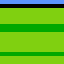

sssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssshssssssssssssssshssssssssssssssshsssssssssssssshhshsssssssssssshhshhsssssssssshhhhhhhssssssssshhhhhhhssssssssshhhhhhssssssss


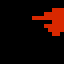

oooooooddhffffffooooooodohffhhffoooooooooohffffhooooooooooffhhffoooooooooooffffooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


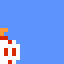

sddddddsssssssssddedddddssssssssfddddssssdsssssdffddssddddddssddfddddddddfffffddddddddffffedeffddddssseededeeefdsssseeeeedeeeeffsssedeeededeeedfssseededeeededefssseeedeeeeedeefssseededeeededffsssedefededeeefdsssseeffedeeeffdssssseeededeefsdsssssssssssssfss


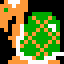

ssshhshhsssssssssshhhhhhhssssssssshhhhhhhssssssssshhhhhhsssssssssshdhhhhsssssssssshdhdhhhsssssssshhhhdhhhsssssssshhhhdhhhsssssssshhdhdhhssssssssshhdddhshsssssssshhdddhhhsssssssshhdddhhsssssssssshhdddhsssssssssshhdddhhsssssssshhdfddhsssssssssshdfdhhssssssss


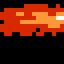

ooooooooooffffoooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


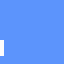

eeeeeeeeiiieeeeeeeeeeeiiiiiieeeeeeeeeiiiiiiieeeeeeeeisiiiiiieesseeeiisbbbbiibbsseeiiiisssbibbbbseiiiiiisbbibbbbbeiiiiiisiiibbbbbeiiiiiisiiibbbbbeiiiiiisbbibbbbseeiiiisssbibbbsseeeiisbbbbiibbssesssisiiiiiiessssssssiiiiiiiesssesssseiiiiiieesseeeeeeeeiiieeeee


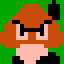

shhhhddddddddddsdhhhhhdddddddddsdhhhhhhddddddddsdhhhhhhddddddddsdhhhhhhddddddddsdhhhhhhddddddddsshhhhhdddddddddsshhhhddddddddddssddddddddddddddssdddddhhhddddddssddddhhhhhdddddssdddhhhhhhhddddsddddhhhhhhhddddsdsddhhhhhhhddddsdossdhhhhhddddssdooossssssssssso


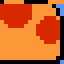

ssssseesssssssssssseedessssssssssseedeessssssssssseedeessssssssssssedeessssssssssssseesssssssssseeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeesssssssssssseesssssssssssssedeessssssssssseedeessssssssssseedeesssssssssssseedesssssssssssssseesssssssssssssssssssssssssssssssss


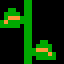

dsssssssssssssssdssddddsssssssssssdddfsfssssssssssdfssssssssssssesdssdddfsssssssessddddddsssssssfesddddddsssssssfefddddddsssssssfdssddddssssssssfddfsdeeeessssfsfdddsfeeeeessffsffddeeeeeeeedffseffeeeeeeeeeeddseeffffffeeeeeddffeeeefffffeeeedffdeeeeeeeffeeedd


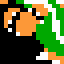

sssssssssssssssssssssssssssssdddsssssssssssffhhhssssssssssffffffsssssssssssfffffssssssssssssddddsssssssssssssdddssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss


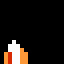

oooooffffffhhhhhoooodhhhfffhhhhhoooodhhhhhhhhhhhoooddhhhhhhhhhhfoooddhhffffhhhhfoooddhffffffhhddooodohffhhffhdddoooooohffffhddhhooooooffhhffdhoooooooooffffodooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


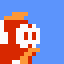

seeeeeeeiiieeeeeoseeeeiiiiiieeeeooseeiiiiiiieeeeooosisiiiiiieessoooiisbbbbiibbssooiiiisssbibbbbsoiiiiiisbbibbbbboiiiiiisiiibbbbboiiiiiisiiibbbbboiiiiiisbbibbbbsooiiiisssbibbbssoooiisbbbbiibbssooooisiiiiiissssoooooiiiiiiiosssooooooiiiiiioossooooooooiiioooos


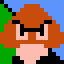

ssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssshssssssssssssssshssssssssssssssshssssssssssssssshssssssssssssssshssssssssssssssshssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss


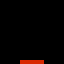

oooooooooooeooddooooooooooefeeddoooooooooefffffdoooooooooeefffddoooooooooeeeeeddoooooooooeeeeeffooooooooooefeeddooooooooooeefeedooooooooooooeeefoooooooooooooooeoooooooooooooooeoooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


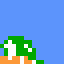

sshdfdhssssssssssssdfdhsssssssssssshhfhsssssssssssshhhssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss


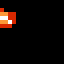

sssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssseeeesssssddssssseededesssdeddsssdeeeeeesssdedddseeeeedeessddedddeeedeeedsssddeddfseeeeeeesssddedssffeededsssssddssssssseeddddddd


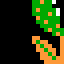

ooooooooooooooooooooooooooooooooooooooossssooooooooooosbssssooooooooosbsbssssooooooosbbbssssssooooossssssssssssoooossssssbbssssooossbssssbbbssssoosbssssbbbbssssoosbsssssbbbssssoosbsssibbbsssssoosbsssibbssssssoosbssssiissssssoossssssssssssssooooibiiiiiiiioo


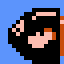

ddddddssssssssssdedddddssssssssdddddssssdsssssddfddssddddddssdddddddddddfffffddddddddffffedeffddddssseededeeefdsssseeeeedeeeeffsfffeeedeedeeedfsdddffdeeeededefsfffdfeeeeeedeefsfffffdeeeededffsffffeedeedeeefddfsffeeeddeeeffddsffseedeedeefsddssssssssssssfssd


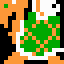

oooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooodddooooooooooooooddddoooooooooooodddddooffffooohhhhddooofffffhhhhhhhooooffffffhhhhhhhoooffffffhhhhhhfooohhhfffhhhhhhffoo


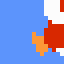

sssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssshdddddhssssssssshdssddhssssssssshssshdhssssssssshssshdhsssssssss


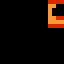

fuuuuuwsffffffwsfuuuuuwsfuuuuuwswwwwwwwsfuuuuuwshhssssssfuuuuuwsdhhfffwsfuuuuuwsddhuuuwsfuuuuuwsfdhuuuwswwwwwwwsdhhuuuwssssssssshhuuuuwsffffffwshuuuuuwsfuuuuuwshwwwwwwsfuuuuuwssshhhsssfuuuuuwsfhhdhhwsfuuuuuwsfhdddhwsfuuuuuwshhdfdhwswwwwwwwsddfdhhwsssssssss


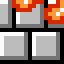

sssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssaaaaaasssss


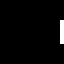

fuuuuuwsffffffwsfuuuuuwsfuuuuuwswwwwwwwsfuuuuuwsssssssssfuuuuuwsffffffwsfuuuuuwsfuuuuuwsfuuuuuwsfuuuuuwswwwwwwwsfuuuuuwsssssssssfuuuuuwsffffffwsfuuuuuwsfuuuuuwswwwwwwwsfuuuuuwsssssssssfuuuuuwsffffffwsfuuuuuwsfuuuuuwsfuuuuuwsfuuuuuwswwwwwwwsfuuuuuwsssssssss


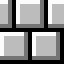

sbbbbbbsoooooooosbbbbbbsoooooooosbiiiibsooooooooosiiiisoooooooooooiiiiooooooooooosiiiisooooooooosbiiiibsoooooooosbbbbbbsoooooooosbbbbbbsoooooooosbbbbbbsoooooooosbiiiibsooooooooosiiiisoooooooooooiiiiooooooooooosiiiisooooooooosbiiiibsoooooooosbbbbbbsoooooooo


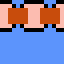

sssssssssssssssssssssssssssssiiisssssssssssbbrrrssssssssssbbbbbbsssssssssssbbbbbssssssssssssiiiisssssssssssssiiissssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss


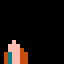

oooooddddddoooooodddddedddddoooofeeefddddoooodooffffffddooddddddfffffddddddddfffddddddddddffffedoddddddoooeededeooooooooeeeeedeeooooffffeeedeedeoofffdddffdeeeedoffddfffdfeeeeeeffdfffffffdeeeedfffffffffeedeedeffffffoffeeeddeeffoffoffoeedeedefooooooooooooooo


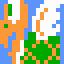

ibbbbbbbbbsbbbbibiiiiiiiiisbiiisbiiiiiiiiiisbiisbiiiiiiiiiisbiisbiiiiiiiiiiisbisbiiiiiiiiiiisbisiiiiiiiiiiiisbisiiiiiiiiiiiisssiiiiiiiiiiissbbbbisssssssssbbiiisibbbbibbbbiiiiisbiiissbiiiiiiiisbiiiisbiiiiiiiisbiiiisbiiiiiiiisbiiiisbiiiiiiissbssssisssssssssi


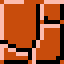

ibbbbbbbbbbbbbbsbibbbbbbbbbbbbssbbibbbbbbbbbbsssbbbibbbbbbbbssssbbbbiiiiiiiissssbbbbiiiiiiiissssbbbbiiiiiiiissssbbbbiiiiiiiissssbbbbiiiiiiiissssdbbbiiiiiiiissssdbbbiiiiiiiissssdbbbiiiiiiiissssdbbsssssssssisssbbsssssssssssissbsssssssssssssissssssssssssssssi


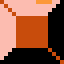

eeeeffdeeeeffddfeeeefddefdeffdddffeeeeeefeeeffddffdeeeeeeeeeffddfddeeeffddeefffdsssfdsffdeeefffsssssfssfssssffssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss


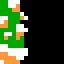

ssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssshssssssssssssssssssssssssssssssshssssssssssssssshsssssssssshsssshsssssssshssshhhsssssssssshshhdhhsssssssshsshdddhsssshssshhhhdfdhsshssshhhhddfdhhssshshhdhhhddhhssshsshdddhhhhhsssshhhhdfdhssssss


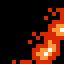

sssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssasssssssssssssssaassssssssssssssaaasssssssssssssaaaasss


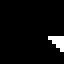

aaaaaoooooooooooaaaaaoooooooooooaaaaaoooooooooooaaaaaoooooooooooaaaaaoooooooooooaaaaaoooooooooooaaaaaoooooooooooaaaaaoooooooooooaaaaaoooooooooooaaaaoooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


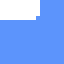

ssssshhhhhhsssssffffwwwwwwwwhhhhffffwwwwwwwwhhhhffffwwwwwwwwhhhhssssshhhhhhsssssffffwwwwwwwwhhhhffffwwwwwwwwhhhhffffwwwwwwwwhhhhssssshhhhhhsssssffffwwwwwwwwhhhhffffwwwwwwwwhhhhffffwwwwwwwwhhhhfsssshhhhhhsssssffffwwwwwwwwhhhhffffwwwwwwwwhhhhdfffwwwwwwwwhhhh


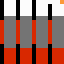

sssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssasssssssssssssssasssssssssssssssasssssssssssssssasssssssssssssssasssssssssssssssassssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss


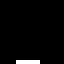

seeeeeeeeeeeeeeeoseeeeeeeeeeeeeeooseeeeeeeeeeeeeoooseeeeeeeeeeeeooooseeeeeeeeeeeoooooseeeeeeeeeeooooooseeeeeeeeeoooooooseeeeeeeeooooooooseeeeeeeoooooooooseeeeeeooooooooooseeeeeoooooooooooseeeeooooooooooooseeeoooooooooooooseeooooooooooooooseooooooooooooooos


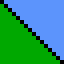

hssssssssssssssshssssssssssssssshssssssssssssssshssssssssssssssshssssssssssssssshssssssssssssssshssssssssssssssshssssssssssssssshssssssssssssssshssssssssssssssshssssssssssssssshsssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss


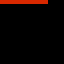

sssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssfsssssssssssssssfsssssssssssssssfsssssssssssssssf


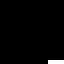

ooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooeeeeeeoooooeeeeeffffffeeeoeeddfffffffefffeeddddfffffffffffeddddfffffffffffeddddfffffffefff


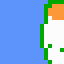

aaasssssssssssssaaasssssssssssssaaasssssssssssssaaasssssssssssssaaasssssssssssssaaasssssssssssssaaasssssssssssssaaasssssssssssssaaasssssssssssssaaaaaaasssssssssaaaaaassssssssssaaaaasssssssssssaaaassssssssssssaaasssssssssssssaassssssssssssssasssssssssssssss


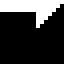

ibbbbbbbbbsbbbbidiiiiiiiiisbiiisdiiiiiiiiiisbiisdiiiiiiiiiisbiisdiiiiiiiiiiisbisdiiiiiiiiiiisbisbiiiiiiiiiiisbisbiiiiiiiiiiisssibiiiiiiiiissbbbbssssssssssbbiiisibbbbibbbbiiiiisbiiissbiiiiiiiisdiiiisbiiiiiiiisdiiiisbiiiiiiiisdiiiisbiiiiiiissdssssisssssssssi


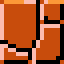

ooooooooooooooofooooooooooooooofooooooooooooooofooooooooooooooofooooooooooooooofooooooooooooooofooooooooooooooofbbbbbbbbbbbbbbbfbbbbbbbbbbbbbbbfooooooooooooooofooooooooooooooofooooooooooooooofooooooooooooooofooooooooooooooofooooooooooooooofooooooooooooooof


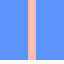

ooooooosnnnnnnnnoooooosnnnnnnnnnooosssnnnnnnnnnnoosnnnnnnnnnnnnnoosnnnnennnnnnnnosnnnnennnnnnnnnsnnnnnennnnnnnnnsnnnnnnnnnnnnnnnsnnnnnnnnnnnnnnnsnnnnennnnnnnnnnosnnnnennnnnnnnnoossnnnnnnnnnnnnoooosnnnnnnnnnnnooosnnnnnnnnnnnnoooosnnnnnnnnnnnooooosssnnnnnnnn


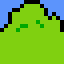

siiiiiiddddiiiiriddddddddddddddridrdddhhhddhdrdriddddhhhhhdhdddriddddhhhhhdhfffriddddhhhhhdfffffddddddhhhddfffffdddddddddddfffffddhhdddddddfffffdhhhhddddddffffdihhhhddddddffddfidhhhddddddhfffriddhdddhhddhdddridrddddhhhdhdrdridddddddhhdddddrsrrrrrrddddrrrrr


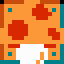

ofhdddddhoooooooofhdooddhoooooooofhooohdhoooooooofhooohdhoooooooofhooohdhoooooooofhooohdhoooooooofhdhhddhoooooooofhdddddhoooooooofhdddddhoooooooofhdooddhoooooooofhooohdhoooooooofhooohdhoooooooofhooohdhoooooooofhooohdhoooooooofhdhhddhoooooooofhdddddhooooooo


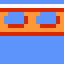

hhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhdhdhdhdhdhdhdhdhhdhdhdhdhdhdhdhddhdhdhdhdhdhdhdhddddddddddddddddddddddddddddddddssssssssssssssssoooooooooooooooooooooooooooooooo


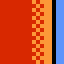

oossbssssbbbssssoosbssssbbbbssssoosbsssssbbbssssoosbsssibbbsssssoosbsssibbssssssoosbssssiissssssoossssssssssssssooooibiiiiiiiioooosbssssssssssssoosbssssssssssssoooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


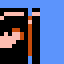

eeeeeeefdddhhhfdeeeessfddddhhffdeeeesfddddhhhfedeeeeeeeeeeeehfeeesssseeeeeeeeeeesssssseeeeeeeeeeesssseeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeefehheeeeeeeeeeehfhfheeeeeefffffhfhhhe


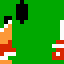

sssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssiiisssssssssssbbrrrssssssssssbbbbbbsssssssssssbbbbbssssssssssssiiiisssssssssssssiiissssssssssssssss


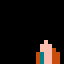

snnnnnnnnnnnnnssdnnnnnnnnnnnnnnsdnnnnnnnnnnnnnnsdnnnnnnnnnnnnnnsdnnnnnnnnnnnnnnsdnnnnnnnnnnnnnnssnnnnnnnnnnnnnsssnnnnnnnnnnnnssssnnnnnnnnnnnnssssnnnnnnnnnnnnnsssnnnnnnnnnnnnnnssnnnnnnnnnnnnnnsdnnnnnnnnnnnnnnsdsnnnnnnnnnnnnnsdsssnnnnnnnnnnssdsssssssssssssss


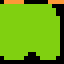

hhhuuuwsffffffwshuuuuuwsfuuuuuwswwwwwwwsfuuuuuwshsssssssfuuuuuwshfffffwsfuuuuuwshuuuuuwsfuuuuuwshuuuuuwswwwwwwwsfuuuuuwsssssssssfuuuuuwsffffffwsfuuuuuwsfuuuuuwswwwwwwwsfuuuuuwsssssssssfuuuuuwsffffffwsfuuuuuwsfuuuuuwsfuuuuuwsfuuuuuwswwwwwwwsfuuuuuwsssssssss


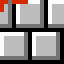

sddddddsssssssssddhdddddssssssssfddddssssdsssssdffddssddddddssddfddddddddfffffddddddddffffhdhffddddssshhdhdhhhfdsssshhhhhdhhhhffssshdhhhdhdhhhdfssshhdhdhhhdhdhfssshhhdhhhhhdhhfssshhdhdhhhdhdffssshdhfhdhdhhhfdsssshhffhdhhhffdssssshhhdhdhhfsdsssssssssssssfss


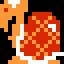

fhhhhhhhooooooooffhhhhhhhoooooooffhhhhhhfoooooooffhhhhhhffoooooohhhhhhhfffoooooohhhhhhffffooooooffhhhhffffoooooofffhhdddffoooooohffhddddfoooooooffhddhhdfooooooohffdhoodooooooooffodoooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


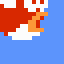

ssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssshssssssssssssssshssssssssssssssshsssssssssssssshhshsssssssssssshhshhsssssssssshhhhhhhssssssssshhhhhhhssssssssshhhhhhsssssssssshdhhhhsssssssssshdhdhhhsssssssshhhhdhhhsssssssshhhhdhhhssssssss


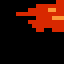

oooooooooooooohhoooooooooooooddhoooooooooooooddhoooooooooooooohhoooooooooooooodhooooooooooooooddoooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


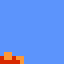

sssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssshssssssssssssssshssssssssssssssshssssssssssssssshsssssssssssssss


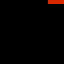

ssiissssiiiissssssiissiiiiiissssssbisiiiiiiissssssbiisiiiiiissssbbbiisbbbbiibbssiiiiiisssbibbbbsbiiiiiisbbibbbbbbiiiiiisiiibbbbbbiiiiiisiiibbbbbiiiiiiisbbibbbbsiiiiiisssbibbbsssssiisbbbbiibbssssbiisiiiiiissssssbisiiiiiiissssssbissiiiiiissssssbissssiiiissss


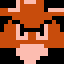

ddoooooooooooooodddoooooooodoooooooodoooooddoooooddddddoodddooooddddfffffdddoooodffffedeffddoooooeededeeefdoooooeeeedeeeeffoooooeedeedeeedfooooofdeeeededefooooofeeeeeedeefooooofdeeeededffoooooeedeedeeefddooooeeeddeeeffddooooeedeedeefoddoooooooooooofoodoooo


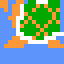

oossssssssssssoooossssssbbssssooossbssssbbbssssoosbssssbbbbssssoosbsssssbbbssssoosbsssibbbsssssoosbsssibbssssssoosbssssiissssssoossssssssssssssooooibiiiiiiiioooosbssssssssssssoosbssssssssssssooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


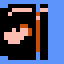

GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGffffGdGGGGGGGGGffuuffduGGdGGGGGuffffudduudfGdGuffuuffuddddfGdduffffffuudddfGdduuffffuuuufffGdduuuuuuuuuufffGGduuuuuuuuuuuffGGduuuuuffuuuuuf


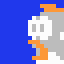

ssssssssrrrsssssssssssrrrrrrsssssssssrrrrrrrssssssssrtrrrrrrssttsssrrtkkkkrrkkttssrrrrtttkrkkkktsrrrrrrtkkrkkkkksrrrrrrtrrrkkkkksrrrrrrtrrrkkkkksrrrrrrtkkrkkkktssrrrrtttkrkkkttsssrrtkkkkrrkkttssssrtrrrrrrstttsssssrrrrrrrstttssssssrrrrrrssttssssssssrrrsssss


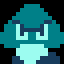

rrrsrrrsrrrsrrrsrrrsrrrsrrrsrrrsrrrsrrrsrrrsrrrsrrrsssssrrrssssstrrsrrrsrrrsrrrstrrsrrrsrrrsrrrstrrsrrrsrrrsrrrsssssrrrsssssrrrsrrrsrrrsrrrsrrrstrrsrrrsrrrsrrrstrrsrrrsrrrsrrrstrrsssssrrrssssstrrsrrrsrrrsrrrstrrsrrrsrrrsrrrsrrrsrrrsrrrsrrrsssssrrrsssssrrrs


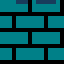

ooooooooooooooooooooooooooooffffooooooooooofffffooooooooooofffffooooooooooooffffooooooooooodhhhfooooooooooodhhhhooooooooooddhhhhooooooooooddhhffooooooooooddhfffoooooooooodohffhooooooooooooohffoooooooooooooffhooooooooooooooffoooooooooooooooooooooooooooooooo


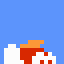

siiiiiiiiiiiiiisiddddddddddddddsidsddddddddddsdsiddddddddddddddsidddiiiddddddddsiddiiiisdddddddsiddissssdddddddsiddisdddiidiiddsiddisddiiisiisdsiddiiiiisssdssdsidddiiiisddddddsiddddssssddddddsiddddddddddddddsidsddddddddddsdsiddddddddddddddsssssssssssssssss


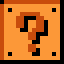

snnnnnnnnnnnnnsodnnnnnnnnnnnnnnsdnnnnnnnnnnnnnnsdnnnnnnnnnnnnnnsdnnnnnnnnnnnnnnsdnnnnnnnnnnnnnnssnnnnnnnnnnnnnsosnnnnnnnnnnnnsoosnnnnnnnnnnnnsoosnnnnnnnnnnnnnsosnnnnnnnnnnnnnnssnnnnnnnnnnnnnnsdnnnnnnnnnnnnnnsdsnnnnnnnnnnnnnsdossnnnnnnnnnnsodooossssssssssoo


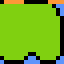

ssssssssssseeeefsssssssssssffeeesssssssssssffdeesssssssssssfddeessssssssssssseeesssssssssssssffessssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss


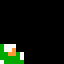

sbbbbbbbbbsbbbbisiiiiiiiiisbiiissiiiiiiiiiisbiissiiiiiiiiiisbiisbiiiiiiiiiiisbisbiiiiiiiiiiisbisbiiiiiiiiiiisbisbiiiiiiiiiiisssibiiiiiiiiissbbbbssssssssssbbiiisibbbbibbbbiiiiisbiiissbiiiiiiiisbiiiisbiiiiiiiisbiiiisbiiiiiiiisbiiiisbiiiiiiississssisssssssssi


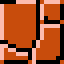

sssssssssssssssshhhhhhsssssssssshhhhhhhhssssssssdddddhhhhsssssssddddddhhhhssssssfffddhhhssssssssffffddhhhsssssssfffffdddhhssssssfffffdddhhssssssffffddhhhsssssssfffddhhhssssssssddddddhhhhssssssdddddhhhhssssssshhhhhhhhsssssssshhhhhhssssssssssssssssssssssssss


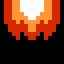

ooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooeeeeoooooddoooooeededeooodeddooodeeeeeeooodedddoeeeeedeeooddedddeeedeeedoooddeddfoeeeeeeeoooddedooffeededoooooddoooooooeeddddddd


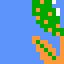

uuuuuuuussssssssffffffffuuussdddfffffffffffffeeeffffffffffffffffffffffffffffffffffffffffffffddddfffffffffffffdddffffffffffffffuuffffffffffffffuuffffffffffffffuufffffffffffffuuufffffffffffffuuuffffffffffffuussfffffffffffuusssffffffffuuusssssuuuuuuuussssssss


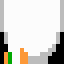

oooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooofdddddddddddddddddddddddddddddddoooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


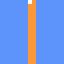

ssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssrisssssssssssrrirrssssssssssrirrrrsssssssssssbbrirsssssssssssbsbbrsssssssssssssbsbsssssssssssssssbssssssssssssssss


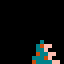

ooohhhhhhhhhhfhhooodhhhhhhhhffhhoooddhhhhhhffhhdooooohdhhhhhhdhoooooooddhddhddoooooooooooddooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


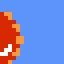

ddddoooooooooooodddddoooooooodooddoooodoooooddoodooddddddoodddooddddddfffffdddoodddffffedeffddoooooeededeeefdooooeeeeedeeeeffooofeeedeedeeedfooodffdeeeededefooofdfeeeeeedeefooofffdeeeededffoooffeedeedeeefddooffeeeddeeeffddoofoeedeedeefoddoooooooooooofoodoo


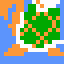

aaaaaaaaaaaaaaaasaaaaaaaaaaaaaaassaaaaaaaaaaaaaasssaaaasssssssssssssaaassssssssssssssaasssssssssssssssasssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss


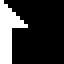

ssssshhhhhhsssssffffwwwwwwwwhhhhffffwwwwwwwwhhhhffffwwwwwwwwhhhhssssshhhhhhsssssffffwwwwwwwwhhhhffffwwwwwwwwhhhhffffwwwwwwwwhhhhssssshhhhhhsssssffffwwwwwwwwhhhhffffwwwwwwwwhhhhffffwwwwwwwwhhhhfsssshhhhhhsssssdfffwwwwwwwwhhhhffffwwwwwwwwhhhhffffwwwwwwwwhhhh


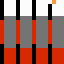

oooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooaoooooooooooooooa


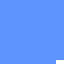

iiisiiisiiisiiisiiisiiisiiisiiisiiisiiisiiisiiisiiisssssiiisssssiiisiiisiiisiiisiiisiiisiiisiiisiiisiiisiiisiiisssssiiisssssiiisiiisiiisiiisiiisiiisiiisiiisiiisiiisiiisiiisiiisiiisssssiiisssssiiisiiisiiisiiisiiisiiisiiisiiisiiisiiisiiisiiisssssiiisssssiiis


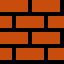

sssssssssssssssshhhhhhhssssssssshhhhhhhhhssssssshdddddhhhhssssssdddddddhhhhsssssdfffddhhhsssssssfffffddhhhssssssffffffdddhhsssssffffffdddhhsssssfffffddhhhssssssdfffddhhhsssssssdddddddhhhhssssshdddddhhhhsssssshhhhhhhhhssssssshhhhhhhsssssssssssssssssssssssss


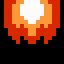

ooofGGfGGGGGGGGGooofGfGGGGGGGGGGoofGGGffGGGGGGGGofGGGGGGGGGGGffffGGGGGGGGGGGffuuofffGGGfGGGGufffoooofGGfGdGuffuuoooofGfGGdduffffooofGGfGGdduufffooofGfGGGdduuuuuoofGGGffGGduuuuuofGGGGGGGGduuuuufGGGGGGGGGGduuufofffGGGfGGGGGuffoooofGGfGGGGGfffoooofGfGGGGGGfff


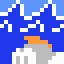

aaasssssssssssssaaasssssssssssssaaasssssssssssssaaasssssssssssssaaasssssssssssssaaasssssssssssssaaasssssssssssssaaasssssssssssssaaasssssssssssssaaasssssssssssssaaasssssssssssssaaasssssssssssssaaasssssssssssssaaasssssssssssssaaasssssssssssssaaasssssssssssss


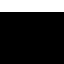

oooeffffeddddfffooooeeeeooddffffoooooooooooeeeffooooooooooooooeeoooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


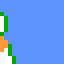

sssssssssssssssssssssssssssssssshssssssssssssssshhssssssssssssssdhhsssssssssssssfdhsssssssssssssddhsssssssssssssdhhshhhhsssssssshhshhddhhsssssssssshddfdhhssssssssshhddfdhsssssssssshhhddhhhhhsssshssshdhhhddhhssssshshhhhddfdhhssshshhsshhddfdhsssssssssshhhddh


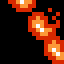

ooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooossssooooooooooosbssssooooooooosbsbssssooooooosbbbssssssooooossssssssssssoooossssssbbssssooossbssssbbbssssoosbssssbbbbssssoosbsssssbbbssssoosbsssibbbsssssoosbsssibbssssssoosbssssiissssss


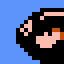

ssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssaaaassssssssssssaaaaasssssssssssaaaaasssssssssss


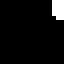

cccccccccccccccccnnnneennnnnennncnnnneennnnnennncnnnneennnnnennncnnnneennnnnennncnnnneennnnnennncnnnneennnnnennncnnnneennnnnennncnnnneennnnnennncnnnneennnnnennncnnnneennnnnennncnnnneennnnnennncnnnneennnnnennncnnnneennnnnennnccccccccccccccccsccccccccccccccc


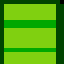

oooooooooooooooooooooooooooooooodooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


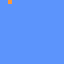

ddeeeeeeeeffedddeeeeffeeeeffeddfeeeeffdeeeeffddfeeeefddefdeffdddffeeeeeefeeeffddffdeeeeeeeeeffddfddeeeffddeefffdsssfdsffdeeefffsssssfssfssssffssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss


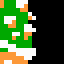

ooooooffffooohhhoooooffffffhhhhhooooofffffffhhhhooooooffffffhhhhooooodhhhfffhhhhooooodhhhhhhhhhhooooddhhhhhhhhhhooooddhhffffhhhhooooddhffffffhhdoooodohffhhffhddooooooohffffhddhoooooooffhhffdhoooooooooffffodoooooooooooooooooooooooooooooooooooooooooooooooooo


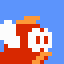

sssssssssfhssshdsssssssssfhssshdsssssssssfhdhhddsssssssssfhdddddsssssssssfhdddddsssssssssfhdssddsssssssssfhssshdsssssssssfhssshdsssssssssfhssshdsssssssssfhssshdsssssssssfhdhhddsssssssssfhdddddssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss


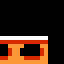

ssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssbbbbbbbbssssssbbbbbbbbbbsssssbbbiiisssssssssbbbiiiiissssssssbbiiisiiisssssssbbiisssiisssssssbbiiisiiisssssssbbsiiiiissssssssbbssiiisssss


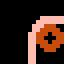

shhsssssssssssssshhsssssssssssssshhssssssssffffsshhsssssssddffddshhssssdddssssssshhfdddsssssssssshhffsssssssssssshhsssssssssssssshhsssssssssssssshhffsssssssssssshhfdddsssssssssshhssssdddssssssshhsssssssddffddshhssssssssffffsshhsssssssssssssshhsssssssssssss


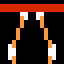

fuuuuuhhhhffffwsfuuuuuwsfuuuuuwswwwwwwwsfuuuuuwsssssssssfuuuuuwsffffffwsfuuuuuwsfuuuuuwsfuuuuuwsfuuuuuwswwwwwwwsfuuuuuwsssssssssfuuuuuwsffffffwsfuuuuuwsfuuuuuwswwwwwwwsfuuuuuwsssssssssfuuuuuwsffffffwsfuuuuuwsfuuuuuwsfuuuuuwsfuuuuuwswwwwwwwsfuuuuuwsssssssss


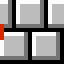

GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGdGuGGGGGGGGGGGGGdduGGGGGGGGGGGGGdduGGGGGGGGGGGGGdduGGGGGGGGGGGGGGduGGGGGGGGGGGGGGduGGGGGGGGGGGGGGGdGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG


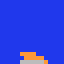

sssssssssssssssssssssssssssssssasssssssssssssssasssssssssssssssasssssssssssssssasssssssssssssssasssssssssssssssasssssssssssssssasssssssssssssssasssssssssssssssasssssssssssssssasssssssssssssssasssssssssssssssasssssssssssssssasssssssssssssssasssssssssssssssa


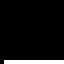

ssssssssssssssfusssssssssssssfsusssssssssssssuussssssssssssfussssssssssssssuussssssssssssfusssssssssssssfsusssssssssssssuussssssssssssfusssssssssssssfsusssssssssssssuussssssssssssfussssssssssssssuussssssssssssfusssssssssssssfsusssssssssssssuussssssssssssss


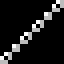

ssssssssssssssshssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss


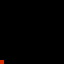

ooddhhhhhhffhhddoooohdhhhhhhdhoooooooddhddhddoooooooooooddoooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


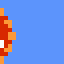

ibbbbbbbbbbbbbbsbibbbbbbbbbbbbssbbibbbbbbbbbbsssbbbibbbbbbbbsssssbbbiiiiiiiisssssbbbiiiiiiiisssssbbbiiiiiiiissssbbbbiiiiiiiissssbbbbiiiiiiiisssssbbbiiiiiiiisssssbbbiiiiiiiisssssbbbiiiiiiiisssssbbsssssssssissssbsssssssssssissbsssssssssssssissssssssssssssssi


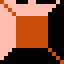

aaaaaaaaaaaaaassaaaaaaaaaaaaaaasaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaasaaaaaaaaaaaaaassaaaaassssaaaasssaaaaassssaaassssaaaaassssaasssssaaaaassssassssssaaaaasssssssssssaaaaasssssssssssaaaaasssssssssssaaaaasssssssssssaaaaasssssssssssaaaaasssssssssss


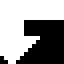

oooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooosooooooooooooooofsooooooooooooooffssooooooooooooHfffsooooooooooofHffsoooooooooooffHfsooooooooooo


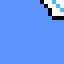

aaaaasssssssssssaaaaasssssssssssaaaassssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss


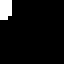

aaaaaoooooooooooaaaaaoooooooooooaaaaaoooooooooooaaaaaoooooooooooaaaaaoooooooooooaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaoooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


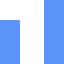

sssssssssssssssasssssssssssssssasssssssssssssssasssssssssssssssasssssssssssssssasssssssssssssssasssssssssssssssasssssssssssssssasssssssssssssssasssssssssssssssasssssssssssssssasssssssssssssssasssssssssssssssaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa


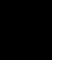

sssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssshssssssssssssssshssssssssssssssshsssssssssssssshhshsssssssss


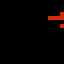

oddddddoooooooooddhdddddoooooooofddddoooodooooodffddoddddddddoddfddddddddfffffddddddddffffhdhffdddddidhhdhdhhhfdooddhhhhhdhhhhffoodhdhhhdhdhhhdfooshhdhdhhhdhdhfooshhhdhhhhhdhhfooohhdhdhhhdhdffooohdhfhdhdhhhfdoooohhffhdhhhffdooooohhhdhdhhfodooooooooooooofoo


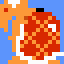

ooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooofhdddddhoooooooofhdooddhoooooooofhooohdhoooooooofhooohdhoooooooofhooohdhoooooooofhooohdhoooooooofhdhhddhoooooooofhdddddhooooooo


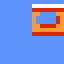

ssssssshshhdhhhhsssssshsshdddhssshsssshhhhdfdhssssshhhhhddfdhhsshshhdhhhhddhhssssshdddhshhhhsssshhhdfdhssssssssshddfdhhssssssssshhddhhssssssssssshhhhsssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss


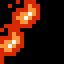

ufuGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG


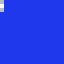

ooooooooooooooooooooooooooooooooooooooooooooooofooooooooooooooffooooooooooooooofooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooofooooooooooooooffooooooooooooooffooooooooooooooof


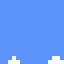

sshdhhhhsssssssssshdhdhhhsssssssshhhhdhhhsssssssshhhhdhhhsssssssshhdhdhhssssssssshhdddhshsssssssshhdddhhhsssssssshhdddhhsssssssssshhdddhsssssssssshhdddhhsssssssshhdfddhsssssssssshdfdhhsssssssssshdfdhssssssssssssdfdhsssssssssssshhfhsssssssssssshhhssssssssss


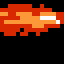

ccccccccccccccccneeeeeeeeeenenncneeeeeeeeenennncneeeeeeeeeenenncneeeeeeeeenennncneeeeeeeeeenenncneeeeeeeeenennncneeeeeeeeeenenncneeeeeeeeenennncneeeeeeeeeenenncneeeeeeeeenennncneeeeeeeeeenenncneeeeeeeeenennncneeeeeeeeeenennccccccccccccccccccccccccccccccccs


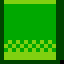

ssssssdddfsssssssssssdsdddffssssssssssddddssssssssssssefdddfssssssssseeffedffsssssssffffeedessssssssfffeeddfsssfssseeeeeedeesssdsseeeeeedfeeefddsseeeeeddeefddddssffeeeeddddddeessffdeeeeeeeeeeesffddeeeeeeeeeffsfddeeeeeeeeefffsfsssseeeeeeffffsssssssssfffffee


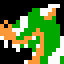

oiiiiiiiiiiiiiisiddddddddddddddsidsddddddddddsdsiddddddddddddddsidddiiiddddddddsiddiiiisdddddddsiddissssdddddddsiddisdddiidiiddsiddisddiiisiisdsdddiiiiisssdssdsddddiiiisddddddsdddddssssddddddsdddddddddddddddsidsddddddddddsdsiddddddddddddddsosssssssssssssss


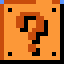

ooooooooiiioooooooooooiiiiiioooooooooiiiiiiiooooooooisiiiiiioosssssiisbbbbiibbssbbiiiisssbibbbbsbiiiiiisbbibbbbbbiiiiiisiiibbbbbbiiiiiisiiibbbbbbiiiiiisbbibbbbsbbiiiisssbibbbsssssiisbbbbiibbssooooisiiiiiiosssoooooiiiiiiiosssooooooiiiiiioossooooooooiiiooooo


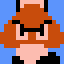

sssssssssssssssfsssssssssssssssfsssssssssssssssfsssssssssssssssfsssssssssssssssfsssssssssssssssfsssssssssssssssfsssssssssssssssfsssssssssssssssfsssssssssssssssfsssssssssssssssfsssssssssssssssfssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss


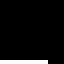

aaaaaoooooooooooaaaaaoooooooooooaaaaoooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


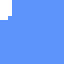

biisiiisiiisiiisbiisiiisiiisiiisbiisiiisiiisiiisbiisssssiiisssssbiisiiisiiisiiisbiisiiisiiisiiisbiisiiisiiisiiisbsssiiisssssiiisbiisiiisiiisiiisdiisiiisiiisiiisdiisiiisiiisiiisdiisssssiiisssssdiisiiisiiisiiisbiisiiisiiisiiisbiisiiisiiisiiisbsssiiisssssiiis


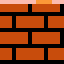

fsssshhhhhhsssssdfffwwwwwwwwhhhhdfffwwwwwwwwhhhhdfffwwwwwwwwhhhhdsssshhhhhhsssssdfffwwwwwwwwhhhhffffwwwwwwwwhhhhffffwwwwwwwwhhhhssssshhhhhhsssssffffwwwwwwwwhhhhffffwwwwwwwwhhhhffffwwwwwwwwhhhhssssshhhhhhsssssffffwwwwwwwwhhhhffffwwwwwwwwhhhhffffwwwwwwwwhhhh


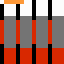

sssssssssssssssosdhdddddddddddsosdhdddddddddddsssdhdddddddddddsssdhhhhhhhhhhhhsssdhhhhhhhhhhhhsssdddddddddddddsssdddddddddddddsssdddddddddddddsssdddddddddddddsssdddddddddddddsssdddddddddddddsssdhhhhhhhhhhhhsssdhdddddddddddsssdhdddddddddddsssdhhhhhhhhhhhhss


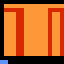

GGffhhffdhGGdGGGGGhffffhddhhdfGGGhffhhffhddddfGGdhffffffhhdddffGdhhffffhhhhffffGdhhhhhhhhhhffffGdhhhhhhhhhhhfffGdhhhhhffhhhhhffGGdhhhfffhhhhhfGGGGGhffffhhhhhhGGGGGfffffhhhhhGGGGGGfffffhhhhddGGGGGfffffGddddGGGGGGGffGGdddGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG


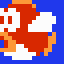

ooooooossssooooooooooosbssssooooooooosbsbssssooooooosbbbssssssooooossssssssssssoooossssssbbssssooossbssssbbbssssoosbssssbbbbssssoosbsssssbbbssssoosbsssibbbsssssoosbsssibbssssssoosbssssiissssssoossssssssssssssooooibiiiiiiiioooosbssssssssssssoosbssssssssssss


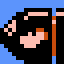

wwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwfwfwfwfwfwfwfwfwwfwfwfwfwfwfwfwffwfwfwfwfwfwfwfwffffffffffffffffffffffffffffffffuuuuuuuuuuuuuuuussssssssssssssssssssssssssssssss


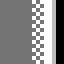

GGGGGfffffGddddGGGGGGGffGGdddGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG


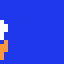

ibbbbbbbbbsbbbbibiiiiiiiiisbiiisbiiiiiiiiiisbiisbiiiiiiiiiisbiisbiiiiiiiiiiisbisbiiiiiiiiiiisbisbiiiiiiiiiiisbisbiiiiiiiiiiisssibiiiiiiiiissbbbbssssssssssbbiiisibbbbibbbbiiiiisbiiissbiiiiiiiisbiiiisbiiiiiiiisbiiiisbiiiiiiiisbiiiisbiiiiiiississssisssssssssi


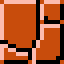

ssssssssiiifffffssssssiiiiiisssssssssiiiiiiissssssssisiiiiiiussssssiisbbbbiibbssssiiiisssbibbbbssiiiiiisbbibbbbbsiiiiiisiiibbbbbsiiiiiisiiibbbbbsiiiiiisbbibbbbsssiiiisssbibbbsssssiisbbbbiibbssssssisiiiiiiussssssssiiiiiiiusssssssssiiiiiissssssssssssiiifffff


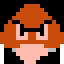

sshdhdhhhsssssssshhhhdhhhsssssssshhhhdhhhsssssssshhdhdhhssssssssshhdddhshsssssssshhdddhhhsssssssshhdddhhsssssssssshhdddhsssssssssshhdddhhsssssssshhdfddhsssssssssshdfdhhsssssssssshdfdhssssssssssssdfdhsssssssssssshhfhsssssssssssshhhssssssssssssssssssssssssss


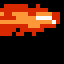

ssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssfsssssssssssssssffssssssssssssssHfffssssssssssssfHffssssssssssssffHfssssssssssss


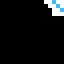

ssssssssoooooooonnnnnnnnsssooooonnnnnnnnnnnssooonnnnnnnnnnnnssoonnnnnnnnnnnnnssonnnnnnnnnnnnnsssnnnnnnnnnnnnnnssnnnnnnnnnnnnnnssnnnnnnnnnnnnnnssnnnnnnnnnnnnnnssnnnnnnnnnnnnnsssnnnnnnnnnnnnnsssnnnnnnnnnnnnssoonnnnnnnnnnnssooonnnnnnnnsssooooossssssssoooooooo


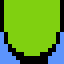

ssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssassssssssssssssaasssssssssssssaaassssssssssssaaaasssssssssssaaaaaaaaaaaaaasaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa


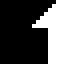

ooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooodooooooooooooooodooooooooooooooodooooooooooooooodoooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


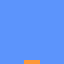

uGGGGGGGGGGGGGGGddGGGGGGGGGGGGGGdGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG


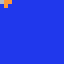

sssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssddddddsssssssssddedddddssssssssfddddssssdsssssdffddssddddddssddfddddddddfffffddddddddffffedeffddddssseededeeefdsssseeeeedeeeeff


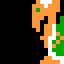

ssssssssffffffffsssssssssussssssssssssssssuussssssssssssssssusssssssssssssssusssssssssssssssusssssssssssssuussssssssssssfuffffffssssssssffffffffsssssssssussssssssssssssssuussssssssssssssssusssssssssssssssusssssssssssssssusssssssssssssuussssssssssssfuffffff


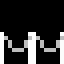

sseeeeeddeefddddssffeeeeddddddeessffdeeeeeeeeeeesffddeeeeeeeeeffsfddeeeeeeeeefffsfsssseeeeeeffffsssssssssfffffeesssssssssffffeeessssssssseeeeeeessssssssseefeeeesssssssssefffeeesssssssssfffdeeessssssssssdddeefssssssssssedeeefssssssssssseeeefsssssssssssffeee


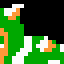

ooooooooooooddddoooooooodddddeddooooooffeeefddddoooooffffffffddoooooooffffffddddooooooodddddddddooooooooddddddoooooooooooooooooeoooooooooooffffeooooooooofffdddfooooooooffddfffdoooooooffdffffffooooooffffffffffoooooffffffffoffoooooffffoffoffoooooooffoooooooo


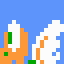

GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGfhdddddhGGGGGGGGfhdGGddhGGGGGGGGfhGGGhdhGGGGGGGGfhGGGhdhGGG


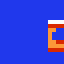

oooooooossffffffoooooooooosfffffooooooooosffffffoooooooosfffffffooooooooosssffffoooooooooooosfffooooooooooosfffsoooooooooooosssooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


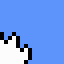

ooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooossooooooooooooosffsoooooooooooosfffoooooooooosfffffooooooooosffffffoooooooosfffffffoooooooosfffffffoooooooosfffffff


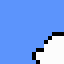

oiiiiiisiiibbbbboiiiiiisbbibbbbsooiiiisssbibbbssoobiisbbbbiibbssbbbbisiiiiiibsssiiiiiiiiiiiiisssbbbbbbiiiiiibbssbbbbbbbiiiiibbbbbiiiiiibbbbbbbbbiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiissssssssssssssssoobisooooobisooooobisooooobisooooobisooooobisooooobisooooobisooo


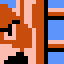

fGGGGGGGGGGGGGGGfGGGGGGGGGGGGGGGfGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG


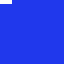

hssshdhssssssssshssshdhssssssssshdhhddhssssssssshdddddhssssssssshdddddhssssssssshdssddhssssssssshssshdhssssssssshssshdhssssssssshssshdhssssssssshssshdhssssssssshdhhddhssssssssshdddddhsssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss


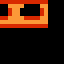

ssssssssssssssssssssssssssssssssuuuuuuuuuuuuuuuuffffffffffffffffffffffffffffffffffffffffffffffffwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffwwwwwwwwwwwwwwwwffffffffffffffffffffffffffffffff


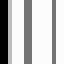

sssffffsssssssssssfdddffsssssssssffffddfdssssssssfffffdfdssssssssfffffffdssssssssffffffddsssssssssdfffddsssssssssssddddssssssssssssffffsssssssssssfdddffsssssssssffffddfdssssssssfffffdfdssssssssfffffffdssssssssffffffddsssssssssdfffddsssssssssssddddsssssssss


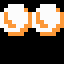

GGGGGhffffhhhhhhGGGGGfffffhhhhhGGGGGGfffffhhhhddGGGGGfffffGddddGGGGGGGffGGdddGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG


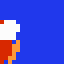

oooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooodooooooooooooooodooooooooooooooooooooooooooooooooooooooooooooooo


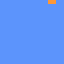

ssssssseedddddddssffeededsssssddfseeeeeeesssddedeeedeeedsssddeddeeeeedeessddeddddeeeeeesssdedddseededesssdeddssseeeesssssddsssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss


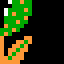

rkkkkkkkkkskkkkrdrrrrrrrrrskrrrsdrrrrrrrrrrskrrsdrrrrrrrrrrskrrsdrrrrrrrrrrrskrsdrrrrrrrrrrrskrskrrrrrrrrrrrskrskrrrrrrrrrrrsssrkrrrrrrrrrsskkkksssssssssskkrrrsrkkkkrkkkkrrrrrskrrrsskrrrrrrrrsdrrrrskrrrrrrrrsdrrrrskrrrrrrrrsdrrrrskrrrrrrrssdssssrsssssssssr


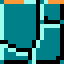

hfoooooooooooooohffooooooooooooofffooooooooooooofffooooooooooooofffooooooooooooodffooooooooooooodfoooooooooooooodfoooooooooooooodooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


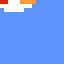

ifhdddddhiiiiiiiifhdiiddhiiiiiiiifhiiihdhiiiiiiiifhisshdhiiisssiifhsiihdhsssiiiiifhiiihdhiiiiiiiifhdhhddhiiiiiiiifhdddddhiiiiiiiifhdddddhiiiiiiiifhdiiddhiiiiiiiifhiiihdhiiiiiiiifhisshdhiiisssiifhsiihdhsssiiiiifhiiihdhiiiiiiiifhdhhddhiiiiiiiifhdddddhiiiiiii


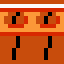

sssssssssssssssfsssssssssssssssfsssssssssssssssfsssssddddddddssfsssddddddddddddfssdddiiiiiiiiddfssddiddddddddsdfssddiddddddddsdfssdddssssssssddfsssddddddddddddfsssssddddddddssfsssssssssssssssfsssssssssssssssfsssssssssssssssfsssssssssssssssfsssssssssssssssf


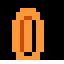

rrrsrrrsrrrsrrrsrrrsrddsrrrsrrrsrrrsrdddrrrsrrddrrrssddddrrdddddrrrsrddddddddddsrrrsddddddddddrsrrddddhhhdddddrsdddddddddddddrrsdddddddddddddrrsrrddddhhhdddddrsrrrsddddddddddrsrrrssddddddddddsrrrsrddddrrdddddrrrsrdddrrrsrrddrrrsrddsrrrsrrrsssssrrrsssssrrrs


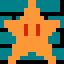

hssshdhssssssssshssshdhssssssssshdhhddhssssssssshdddddhssssssssshdddddhssssssssshdssddhssssssssshssshdhssssssssshssshdhssssssssshssshdhssssssssshssshdhssssssssshdhhddhssssssssshdddddhssssssssshdddddhssssssssshdssddhssssssssshssshdhssssssssshssshdhsssssssss


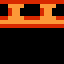

GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGfufufuGGGGGGGGGGfffffffffGGGGGGGufGGGGGGGGGGGGGGuffufufuGGGGGGGGffffffffffGGGGGGfffGGGGGGGGGGGGGfffGGGGGGGGGGGGGffffffffffGGGGGGuffufufuGGGGGGGGufGGGGGGGGGGGGGGfffffffffGGGGGGGfufufuGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG


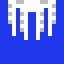

ufwwwwwwwwwwwwuuufwwwwwwwwwwwwuuufwwwwwwwwwwwwuuufwwwwwwwwwwwwuuufwwwwwwwwwwwwuuufwwwwwwwwwwwwuuufwwwwwwwwwwwwuuufwwwwwwwwwwwwuuufwwwwwwwwwwwwuuufwfwfwfwfwfwfuuufwwfwfwfwfwfwuuufwfwfwfwfwfwfuuufwwfwfwfwfwfwuuufwfffffffffffuuufwfffffffffffusuuuuuuuuuuuuuuus


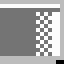

sbbbbbbssssssssssbbbbbbssssssssssbiiiibsssssssssssiiiissssssssssssiiiissssssssssssiiiisssssssssssbiiiibssssssssssbbbbbbssssssssssbbbbbbssssssssssbbbbbbssssssssssbiiiibsssssssssssiiiissssssssssssiiiissssssssssssiiiisssssssssssbiiiibssssssssssbbbbbbsssssssss


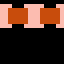

oooooooooooooooaoooooooooooooooaoooooooooooooooaoooooooooooooooaoooooooooooooooaoooooooooooooooaoooooooooooooooaoooooooooooooooaoooooooooooooooaoooooooooooooooaoooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


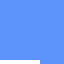

sssssssssssssssssssssffffffsssssssffffffffsfffsssffffffffffffffssffffffffffffffssffffffffffsfffssfffffsssfffsffssfffffffffffsfsssfffffffffffsfsssfffffsssfffsffssffffffffffsfffssffffffffffffffssffffffffffffffsssffffffffsfffsssssssffffffsssssssssssssssssssss


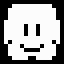

sssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssh


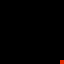

oiiiiiisiiibbbbboiiiiiisbbibbbbsooiiiisssbibbbssoooiisbbbbiibbssooooisiiiiiiosssoooooiiiiiiiosssooooooiiiiiioossooooooooiiiooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


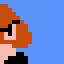

ooooooooooooooooooooooooooooodddoooooooooooffeeeooooooooooffffffooooooooooofffffooooooooooooddddooooooooooooodddoooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


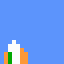

oooffffooooooooooofdddffoooooooooffffddfdoooooooofffffdfdoooooooofffffffdooooooooffffffddooooooooodfffddoooooooooooddddooooooooooooffffooooooooooofdddffoooooooooffffddfdoooooooofffffdfdoooooooofffffffdooooooooffffffddooooooooodfffddoooooooooooddddooooooooo


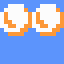

swwwwwwwwwwwwwwswiiiiiiiiiiiiiiwwiwiiiiiiiiiiwiwwiiiiiiiiiiiiiiwwiiiiiihiiiiiiiwwiiiihiiihhhiiiwwiiiiihihhdhhiiwwiiiihiihdddhiiwwiiiihhhhdfdhiiwwiiiihhddfdhhiiwwiiiiihhddhhiiiwwiiiiiihhhhiiiiwwiiiiiiihiiihhhwwiwiiiiiihihhdhhwiiiiiiihiihdddhswwwwwwwhhhhdfdh


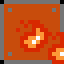

ibbbbbbbbbbbbbbsbibbbbbbbbbbbbssbbibbbbbbbbbbsssbbbibbbbbbbbssssbbbbiiiiiiiissssbbbbiiiiiiiissssbbbbiiiiiiiissssbbbbiiiiiiiissssbbbbiiiiiiiissssbbbbiiiiiiiissssbbbbiiiiiiiissssbbbbiiiiiiiissssbbbsssssssssisssbbsssssssssssissbsssssssssssssissssssssssssssssi


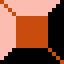

sssssssssssssssssEEEEeeEEEEEeEEEsEEEEeeEEEEEeEEEsEEEEeeEEEEEeEEEsEEEEeeEEEEEeEEEsEEEEeeEEEEEeEEEsEEEEeeEEEEEeEEEsEEEEeeEEEEEeEEEsEEEEeeEEEEEeEEEsEEEEeeEEEEEeEEEsEEEEeeEEEEEeEEEsEEEEeeEEEEEeEEEsEEEEeeEEEEEeEEEsEEEEeeEEEEEeEEEssssssssssssssssosssssssssssssss


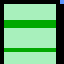

HHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH


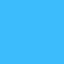

sssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssshssssssssssssshsssssssssssssssshshsssssssssssshsshsssssssssssshhhhsssssssshssshhddsssssshssshhhhhd


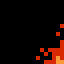

oooooooonnnnnnnnooooooooosoooooooooooooooossoooooooooooooooosooooooooooooooosooooooooooooooosooooooooooooossoooooooooooonsnnnnnnoooooooonnnnnnnnooooooooosoooooooooooooooossoooooooooooooooosooooooooooooooosooooooooooooooosooooooooooooossoooooooooooonsnnnnnn


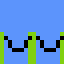

ddddddssssssssssdhdddddssssssssdddddssssdsssssddfddssddddddssdddddddddddfffffddddddddffffhdhffddddssshhdhdhhhfdsssshhhhhdhhhhffsfffhhhdhhdhhhdfsdddffdhhhhdhdhfsfffdfhhhhhhdhhfsfffffdhhhhdhdffsffffhhdhhdhhhfddfsffhhhddhhhffddsffshhdhhdhhfsddssssssssssssfssd


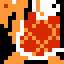

eeeeeeeeeenenncseeeeeeeeenennncseeeeeeeeeenenncseeeeeeeeenennncseeeeeeeeeenenncseeeeeeeeenennncseeeeeeeeeenenncseeeeeeeeenennncseeeeeeeeeenenncseeeeeeeeenennncseeeeeeeeeenenncseeeeeeeeenennncseeeeeeeeeenenncseeeeeeeeenennncseeeeeeeeeenenncseeeeeeeeenennncs


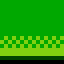

oooodddooooooooooooooddddoooooooooooodddddooooooooohhhhddooooooofhhhhhhhooooooooffhhhhhhhoooooooffhhhhhhfoooooooffhhhhhhffoooooohhhhhhhfffoooooohhhhhhffffooooooffhhhhffffoooooofffhhdddffoooooohffhddddfoooooooffhddhhdfooooooohffdhoodooooooooffodoooooooooooo


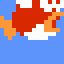

sssssssssssssssssKKKKKKKKKKKKKKssKsKKKKKKKKKKsKssKKKvvvvvvvvKKKssKvvvvvvvvvvvvKssvvvxxxxxxxxvvvssvvxvvvvvvvvsvvssvvxvvvvvvvvsvvssvvvssssssssvvvsssvvvvvvvvvvvvssssssvvvvvvvvsssssKssssssssssssKssKKKssssssssKKKssKsKKKKKKKKKKsKssKKKKKKKKKKKKKKsssssssssssssssss


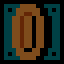

ooooooofhdddddhoooooooofhdooddhoooooooofhooohdhoooooooofhooohdhoooooooofhooohdhoooooooofhooohdhoooooooofhdhhddhoooooooofhdddddhoooooooofhdddddhoooooooofhdooddhoooooooofhooohdhoooooooofhooohdhoooooooofhooohdhoooooooofhooohdhoooooooofhdhhddhoooooooofhdddddho


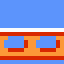

GGGGGGGduuuuuffuGGGGGGGGduuufffuGGGGGGGGGGuffffuGGGGGGGGGGfffffuGGGGGGGGGGfffffuGGGGGGGGGGfffffGGGGGGGGGGGGffGGdGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG


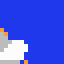

ooooooohhiisiiisooooooohhiisiiisooooooohhiisiiisooooooohhiisssssdddoooohhiisiiisooodddfhhiisiiisoooooffhhiisiiisooooooohhsssiiisooooooohhiisiiisoooooffhhiisiiisooodddfhhiisiiisdddoooohhiisssssooooooohhiisiiisooooooohhiisiiisooooooohhiisiiisooooooohhsssiiis


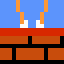

ibbbbbbbbbsbbbbibiiiiiiiiisbiiisbiiiiiiiiiisbiisbiiiiiiiiiisbiisbiiiiiiiiiiisbisbiiiiiiiiiiisbisbiiiiiiiiiiisbisbiiiiiiiiiiisssibiiiiiiiiissbbbbssssssssssbbiiismbbbbibbbbiiiiismiiissbiiiiiiiismiiiisbiiiiiiiismiiiisbiiiiiiiisbiiiisbiiiiiiississssisssssssssi


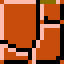

siiiiiiiiiiiiiiriddddddddddddddridrddddddddddrdriddddddddddddddridddiiiddddddddriddiiiirdddddddriddirrrrdddddddriddirdddiidiiddriddirddiiiriirdriddiiiiirrrdrrdridddiiiirddddddriddddrrrrddddddriddddddddddddddridrddddddddddrdriddddddddddddddrsrrrrrrrrrrrrrrr


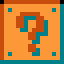

hhhhdfdhsssssssshhddfdhhsssssssshhhddhhsssssssssdhhhhhssssssssssdhsssssssssssssshhsssssssssssssshsssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss


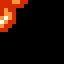

GdduuuuuuuuuufffGGduuuuuuuuuuuffGGduuuuuffuuuuufGGGduuufffuuuuufGGGGGuffffuuuuuuGGGGGfffffuuuuuGGGGGGfffffuuuuddGGGGGfffffGddddGGGGGGGffGGdddGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG


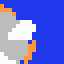

ooooooooooooooooooooooooooooooooooooooooooooooofooooooooooooooffooooooooooooooffooooooooooooooofoooooooooooooodhoooooooooooooodhoooooooooooooddhoooooooooooooddhoooooooooooooddhooooooooooooodohoooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


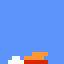

ibbbbbbbbbsbbbbibiiiiiiiiisbiiisbiiiiiiiiiisbiisbiiiiiiiiiisbiisbiiiiiiiiiiisbisbiiiiiiiiiiisbisdiiiiiiiiiiisbisdiiiiiiiiiiisssidiiiiiiiiissbbbbdsssssssssbbiiisibbbbibbbbiiiiisbiiissbiiiiiiiisbiiiisbiiiiiiiisbiiiisbiiiiiiiisbiiiisbiiiiiiississssisssssssssi


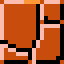

sssfHHfHHHHHHHHHsssfHfHHHHHHHHHHssfHHHffHHHHHHHHsfHHHHHHHHHHHHHHfHHHHHHHHHHHHHHHsfffHHHfHHHHHHHHssssfHHfHHHHHHHHssssfHfHHHHHHHHHsssfHHfHHHHHHHHHsssfHfHHHHHHHHHHssfHHHffHHHHHHHHsfHHHHHHHHHHHHHHfHHHHHHHHHHHHHHHsfffHHHfHHHHHHHHssssfHHfHHHHHHHHssssfHfHHHHHHHHH


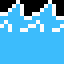

ssssssssssssssssbbbbbbbbbbbbbdddbbbbbbbbbbbffhhhbbbbbbbbbbffffffbbbbbbbbbbbfffffbbbbbbbbbbbbddddbbbbbbbbbbbbbdddbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbssssssssssssssss


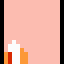

ofhdddddhoooooooofhdooddhoooooooofhooohdhoooooooofhooohdhoooooooofhooohdhoooooooofhooohdhoooooooofhdhhddhoooooooofhdddddhooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


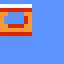

aaaaaaaaaaaaaaaasaaaaaaaaaaaaaaassaaaaaaaaaaaaaasssaaaassssssssassssaaassssssssasssssaassssssssassssssassssssssasssssssssssssssasssssssssssssssasssssssssssssssasssssssssssssssasssssssssssssssasssssssssssssssasssssssssssssssasssssssssssssssasssssssssssssssa


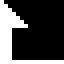

GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGffffGdGGGGGGGGGffuuffduGGdGGGGGuffffudduudfGdGuffuuffuddddfGdduffffffuudddfGdduuffffuuuufffGdduuuuuuuuuufffGGduuuuuuuuuuuffGGduuuuuffuuuuufGGGduuufffuuuuufGGGGGuffffuuuuuuGGGGGfffffuuuuuGGGGGGfffffuuuudd


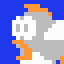

ssssssssuuuuuuuussssssuuffffffffsssssuffffffffffssssufffffffffffsssuffffffffffffsssuffffffffffffssufffffffffffffssufffffffffffffssufffffffffffffssufffffffffffffsssuffffffffffffsssuffffffffffffssssufffffffffffsssssuffffffffffssssssuuffffffffssssssssuuuuuuuu


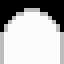

ddfdhhwsffffffwshddfdhwsfuuuuuwshhhddhwsfuuuuuwssshdhhssfuuuuuwshfhhhfwsfuuuuuwsfhhuuuwsfuuuuuwshuuuuuwswwwwwwwshhuuuuwsssssssssdhhuuuwsffffffwsfdhuuuwsfuuuuuwsddhwwwwsfuuuuuwsdhhsssssfuuuuuwshhffffwsfuuuuuwsfuuuuuwsfuuuuuwsfuuuuuwswwwwwwwsfuuuuuwsssssssss


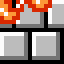

oooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooossssssosssssssosbbbbbssbbbbbbssbbbbbbbbsbbbbbbbsbbbbbbsbbbbbbbsbbbbbbbsbbbbbbbsbbssssbbsbssssbbsbbbbbssbbbbbbssbssssssosssssssosoooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


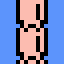

siiiiiiiiiiiiiiwiddddddddddddddwidwddddddddddwdwiddddddddddddddwidddiiiddddddddwiddiiiiwdddddddwiddiwwwwdddddddwiddiwdddiidiiddwiddiwddiiiwiiwdwiddiiiiiwwwdwwdwidddiiiiwddddddwiddddwwwwddddddwiddddddddddddddwidwddddddddddwdwiddddddddddddddwswwwwwwwwwwwwwww


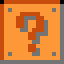

dbbbbbbbbbsbbbbidiiiiiiiiisbiiisdiiiiiiiiiisbiisdiiiiiiiiiisbiisbiiiiiiiiiiisbisbiiiiiiiiiiisbisbiiiiiiiiiiisbisbiiiiiiiiiiisssibiiiiiiiiissbbbbssssssssssbbiiisibbbbibbbbiiiiisbiiissbiiiiiiiisbiiiisbiiiiiiiisbiiiisbiiiiiiiisbiiiisbiiiiiiissdssssisssssssssi


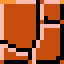

sssssssssffffeeessssssssseeeeeeessssssssseefeeeesssssssssefffeeesssssssssfffdeeessssssssssdddeefssssssssssedeeefssssssssssseeeefsssssssssssffeeesssssssssssffdeesssssssssssfddeessssssssssssseeesssssssssssssffessssssssssssssssssssssssssssssssssssssssssssssss


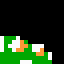

sssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssshsssssssssssssssshsssssssssssssshsssssssssshsssshhssssssshssshhhhhsssssssshshhdhhhssssssshsshdddhsssssssshhhhdfdhssshsssshhddfdhhshssshhhshhddhhssshshhdhhshhhhssshsshdddhssssssss


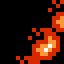

oooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooosooooooooooooooosooooooooooooooosooooooooooooooosooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


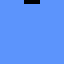

oddddddoooooooooddedddddoooooooofddddoooodooooodffddooddddddooddfddddddddfffffddddddddffffedeffddddbbbeededeeefdbbbbeeeeedeeeeffbbbedeeededeeedfbsseededeeededefbbbeeedeeeeedeefssseededeeededffoooedefededeeefdooooeeffedeeeffdoooooeeededeefodooooooooooooofoo


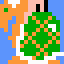

ooooooooooooooosooooooooooooooosooooooooooooooseooooooooooooooseooooooooooooooseoooooooooooooseeoooooooooooooseeoooooooooooooseeoooooooooooooseeoooooooooooooseeoooooooooooooseeooooooooooooooseooooooooooooooseooooooooooooooseooooooooooooooosooooooooooooooos


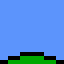

ooooooooooooooofooooooooooooooofooooooooooooooofoooooddddddddoofoooddddddddddddfoodddiiiiiiiiddfooddiddddddddsdfooddiddddddddsdfoodddssssssssddfoosddddddddddddfoosssddddddddssfooossssssssssssfooooossssssssoofooooooooooooooofooooooooooooooofooooooooooooooof


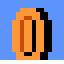

oooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


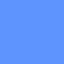

hddhhuwsffffffwshhhhuuwsfuuuuuwswhwwwhhhfuuuuuwssshshhdhhuuuuuwsfhffhdddhuuuuuwsfhhhhdfdhuuuuuwsfhhddfdhhwwwwwwsfuhhddhhssssssssfuuhhhhsffffffwsfuuuuuhsfuuuuuwswwwwhwwshhhuuuwsssssshshhdhhuuwsffffhfwhdddhuuwsfuuuhhhhdfdhuuwsfuuuhhddfdhhwwwsfuuuuhhddhhsssss


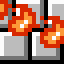

siiiiiisiiibbbbbsiiiiiisbbibbbbsssiiiisssbibbbsssssiisbbbbiibbssssssisiiiiiiussssssssiiiiiiiusssssssssiiiiiissssssssssssiiifffffssssssssffffffffsssssssssussssssssssssssssuussssssssssssssssusssssssssssssssusssssssssssssssusssssssssssssuussssssssssssfuffffff


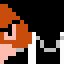

dsssssssssssssssddssssssssssssssddssssssssssssssddssssssssssssssdffsssssssssssssfdseeeeessssssssdeeeddeeeeesssssfffddddeeeeeeddsfefddddffffeeeddeeffddddedffeeddeeeffdddeedfedddeeeededdeedfedddeeedededeeeffdddsefeeededdeefedsssefffedeeeefessssssseedeeesfsss


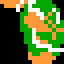

rrrsrrrsrrrsrrrstrrsrrrsrrrsrrrstrrsrrrsrrrsrrrstrrsssssrrrssssstrrsrrrsrrrsrrrstrrsrrrsrrrsrrrsrrrsrrrsrrrsrrrsssssrrrsssssrrrsrrrsrrrsrrrsrrrsrrrsrrrsrrrsrrrsrrrsrrrsrrrsrrrsrrrsssssrrrsssssrrrsrrrsrrrsrrrsrrrsrrrsrrrsrrrsrrrsrrrsrrrsrrrsssssrrrsssssrrrs


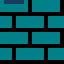

hhdddffooooooooohddddfooooooooooddhhdfoooooooooodhoodooooooooooodooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


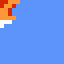

sssssssssfhssshdsssssssssfhssshdsssssssssfhdhhddsssssssssfhdddddsssssssssfhdddddsssssssssfhdssddsssssssssfhssshdsssssssssfhssshdsssssssssfhssshdsssssssssfhssshdsssssssssfhdhhddsssssssssfhdddddsssssssssfhdddddsssssssssfhdssddsssssssssfhssshdsssssssssfhssshd


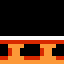

sddddddddddddddsdhhddddddddddddsdhhhdddddddddddsdhhhdddddddddddsdhhhdddddddddddsdhhhdddddddddddsshhhddddhhhhdddsshhhddhhhhhhhhdsshhddhhhhhhhhhhssddddhhhhhhhhhhssddddhhhhhhhhhhssddddhhhhhhhhhhsdddddhhhhhhhhhhsddddddhhhhhhhhdsddddddddhhhhdddsddddddddddddddds


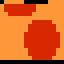

ssssshhhhhhsssssffffwwwwwwwwhhhhffffwwwwwwwwhhhhffffwwwwwwwwhhhhfsssshhhhhhsssssffffwwwwwwwwhhhhffffwwwwwwwwhhhhdfffwwwwwwwwhhhhfsssshhhhhhsssssffffwwwwwwwwhhhhffffwwwwwwwwhhhhdfffwwwwwwwwhhhhdsssshhhhhhsssssdfffwwwwwwwwhhhhdfffwwwwwwwwhhhhdfffwwwwwwwwhhhh


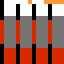

oooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooossssooooooooooosbssssooooooooosbsbssssooooooosbbbssssssooo


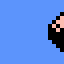

ssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss


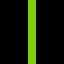

ssssshhhhhhsssssffffwwwwwwwwhhhhffffwwwwwwwwhhhhffffwwwwwwwwhhhhssssshhhhhhsssssffffwwwwwwwwhhhhffffwwwwwwwwhhhhffffwwwwwwwwhhhhssssshhhhhhsssssffffwwwwwwwwhhhhffffwwwwwwwwhhhhffffwwwwwwwwhhhhssssshhhhhhsssssffffwwwwwwwwhhhhffffwwwwwwwwhhhhffffwwwwwwwwhhhh


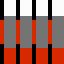

ssssssssssshshhsssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss


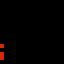

sssssssssssssshsssssssssssshhhhhsssssssssshhddhhsssssssssshddfdhsssssssssshhddfdssssssssssshhhddssssssssshssshdhssssssssssshshhhsssssssssshshhsssssssssshhhhssssssssssshhddhhsssssssssshddfdhhssssssssshhddfdhsssssssssshhhddhsssssssshssshdhhsssssssssshshhhsss


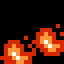

ooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooodoooooooooooooooooooooooooooooooooooooooffffooohhooooooffffffhhhhoooooofffffffhhhoooooooffffffhhhoooooodhhhfffhhhoooooodhhhhhhhhh


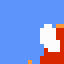

GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGuGGdGGGGGGGGGGGGduudfGGGGGGGGGGGddddfGGGGGGGGGGGudddffGGGGGGGGGGuuffffGGGGGGGGGGuuffffGGGGGGGGGGuuufffGGGGGGGGGG


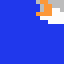

fuuuuhhddhhfffwsfuuuuhddfdhhuuwswwwwwhhddfdhuuwssssssshhhddhuuwsffffhfwshdhhuuwsfuuuuuhshhhuuuwsfuuuuhwhhwwwwwwsfuuhhhhsssssssssfuhhddhhffffffwsfuhddfdhhuuuuuwswwhhddfdhuuuuuwsssshhhddhuuuuuwsfhfffhdhhuuuuuwsfuuhuhhhfuuuuuwshhhhhhwswwwwwwwshddhhuwsssssssss


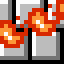

sfhdddddhssssssssfhdssddhssssssssfhssshdhssssssssfhssshdhssssssssfhssshdhssssssssfhssshdhssssssssfhdhhddhssssssssfhdddddhssssssssfhdddddhssssssssfhdssddhssssssssfhssshdhssssssssfhssshdhssssssssfhssshdhssssssssfhssshdhssssssssfhdhhddhssssssssfhdddddhsssssss


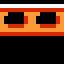

ssssshhhhhhsssssffffwwwwwwwwhhhhffffwwwwwwwwhhhhffffwwwwwwwwhhhhfsssshhhhhhsssssffffwwwwwwwwhhhhdfffwwwwwwwwhhhhffffwwwwwwwwhhhhfsssshhhhhhsssssffffwwwwwwwwhhhhdfffwwwwwwwwhhhhdfffwwwwwwwwhhhhdsssshhhhhhsssssdfffwwwwwwwwhhhhdfffwwwwwwwwhhhhffffwwwwwwwwhhhh


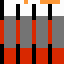

sssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssshhhhssssssssssshhddhhsssss


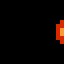

ssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssshssssssssssssssshssssssssssssssshsssssssssssssshhshsssssssssssshhshhsssssssssshhhhhhhssssssssshhhhhhhssssssssshhhhhhsssssssssshdhhhhsssssssssshdhdhhhsssssssshhhhdhhhsssssssshhhhdhhhssssss


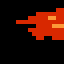

biisiiisiiisiiisdiisiiisiiisiiisdiisiiisiiisiiisdiisssssiiisssssdiisiiisiiisiiisdiisiiisiiisiiisbiisiiisiiisiiisbsssiiisssssiiisbiisiiisiiisiiisbiisiiisiiisiiisbiisiiisiiisiiisbiisssssiiisssssdiisiiisiiisiiisdiisiiisiiisiiisdiisiiisiiisiiisdsssiiisssssiiis


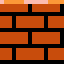

ooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooiiioooooooooooiiiiiioooooooooiiiiiiiooooooooisiiiiiioossoooiisbbbbiibbssooiiiisssbibbbbsoiiiiiisbbibbbbboiiiiiisiiibbbbb


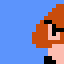

sffeeeeeffsssssssfeeffeefffssssssfeffeeeefffsssssfeeeefeeffffssssfeffeeeefffffsssfeeffeefffffffssffeeeeeffffffffffffffffffffffffffffffffffffffffssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss


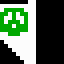

GGGGGGGGGGGGGGGdGGGGGGGGGGGGGGGdGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG


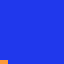

GGGfffGGGGGGffufGGGGffGGGGGGGGGGGGGGGfGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG


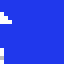

GGGGGGGGGfGGGGGGGGGGGGGGffGGGGGGGGGGGGGfffGGGGGGGGGGGGfffuuffsffGGGGGffuufffsfssGGGGfuufffffsfssGGGfufffffffssffGGGuffffffffssssGGGuffffffffssssGGGfufffffffssffGGGGfuufffffsfssGGGGGffuufffsfssGGGGGGfffuuffsffGGGGGGGfffGGGGGGGGGGGGGGffGGGGGGGGGGGGGGGfGGGGGG


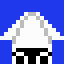

ossssssssssssssosiiiiiiiiiiiiiissisiiiiiiiiiisissiiiiiiiiiiiiiissiiiiiiiiiiiiiissiiiiiiiiiiiiiissiiiiiiiiiiiiiissiiiiiiiiiiiiiissiiiiiiiiiiiiiissiiiiiiiiiiiiiissiiiiiiiiiiiiiissiiiiiiiiiiiiiissiiiiiiiiiiiiiissisiiiiiiiiiisissiiiiiiiiiiiiiisosssssssssssssso


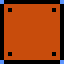

ssssfhssshdhssssssssfhssshdhssssssssfhdhhddhssssssssfhdddddhssssssssfhdddddhssssssssfhdssddhssssssssfhssshdhssssfffffhfffhdhfffffffffhfffhdhffffssssfhssshdhssssssssfhdhhddhssssssssfhdddddhssssssssfhdddddhssssssssfhdssddhssssssssfhssshdhssssssssfhssshdhssss


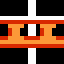

ooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooofooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooofooooooooooooooofoooooooooooooooo


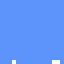

dooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooofooooooooooooooofooooooooooooooofooooooooooooooofooooooooooooooofooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


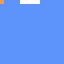

sfhdhhddhssssssssfhdddddhssssssssfhdddddhssssssssfhdssddhssssssssfhssshdhssssssssfhssshdhssssssssfhssshdhssssssssfhssshdhssssssssfhdhhddhssssssssfhdddddhsssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss


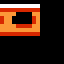

ooiisoooooiisoooooiisoooooiisooooobisooooobisooooobisooooobisooobbbbbbbbbbbbbbbbiiiiiiiiiiiiiiiibbbbbbbbbbbbbbbbbbbbbbbiiiiibbbbbiiiiiibbbbbbbbbiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiissssssssssssssssoobisooooobisooooobisooooobisooooobisooooobisooooobisooooobisooo


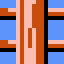

snnnnnnnnnnnnnsssnnnnnnnnnnnnnnssnnnnnnnnnnnnnnssnnnnnnnnnnnnnnssnnnnnnnnnnnnnnssnnnnnnnnnnnnnnssnnnnnnnnnnnnnsssnnnnnnnnnnnnssssnnnnnnnnnnnnssssnnnnnnnnnnnnnsssnnnnnnnnnnnnnnssnnnnnnnnnnnnnnssnnnnnnnnnnnnnnsssnnnnnnnnnnnnnsssssnnnnnnnnnnssssssssssssssssss


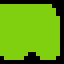

uuuuffGGGGGGGGGGuuuufGGGGGGGGGGGuuuuuGGGGGGGGGGGuuuuGGGGGGGGGGGGuuuddGGGGGGGGGGGddddGGGGGGGGGGGGddGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG


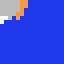

ssseessssssssssssseeesssssssssssseedeessssssssssseedeessssssssssseedeesssssssssssseedsssssssssssssseeeeeeeeeeeeessssseeeeeeeeeeesssssssssssseesssssssssssssedeessssssssssseedeessssssssssseedeesssssssssssseedesssssssssssssseesssssssssssssssssssssssssssssssss


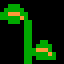

ooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooofooooooooooooooffooooooooooooooff


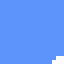

ooiisoooiiiisoooooiisoiiiiiisooooobisiiiiiiisooooobiisiiiiiisossbbbiisbbbbiibbssiiiiiisssbibbbbsbiiiiiisbbibbbbbbiiiiiisiiibbbbbbiiiiiisiiibbbbbiiiiiiisbbibbbbsiiiiiisssbibbbsssssiisbbbbiibbssoobiisiiiiiissssoobisiiiiiiissssoobisoiiiiiisossoobisoooiiiisooo


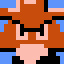

hhhhhhhhhhhfffoohhhhhhhhhhffffoohhffffhhhhffffoohffffffhhdddffoohffhhffhddddfoooohffffhddhhdfooooffhhffdhoodooooooffffodoooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


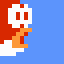

aaaaasssssssssssaaaaasssssssssssaaaaasssssssssssaaaaasssssssssssaaaaasssssssssssaaaaasssssssssssaaaaasssssssssssaaaaasssssssssssaaaaasssssssssssaaaaasssssssssssaaaaasssssssssssaaaaasssssssssssaaaaasssssssssssaaaaasssssssssssaaaaasssssssssssaaaaasssssssssss


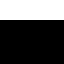

rkkkkkkkkkskkkkrkrrrrrrrrrskrrrskrrrrrrrrrrskrrskrrrrrrrrrrskrrsirrrrrrrrrrrskrsirrrrrrrrrrrskrsirrrrrrrrrrrskrsirrrrrrrrrrrsssrkrrrrrrrrrsskkkksssssssssskkrrrsrkkkkrkkkkrrrrrskrrrsskrrrrrrrrskrrrrskrrrrrrrrskrrrrskrrrrrrrrskrrrrskrrrrrrrssrssssrsssssssssr


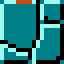

GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGfGGGGGGGGGGGGGGGuGGGGGGGGGGGGGGGuGGGGGGGGGGGGGGGfGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG


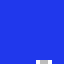

eeeeeeeeeeeeeeeeeeeesssseeeeeeeeeeeesssseeeeeeeeeeeeeeeeeeeeeeeeesssseeeeeeeeeeesssssseeeeeeeeeeesssseeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee


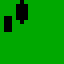

hhssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss


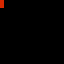

oooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooffffodoooooooooffhhffdhoodooooohffffhddhhdfodohffhhffhddddfoddhffffffhhdddfoddhhffffhhhhfffoddhhhhhhhhhhfffoodhhhhhhhhhhhffoodhhhfffhhhhhhfoooffffffhhhhhhfoofffffffhhhhhhh


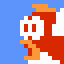

ooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooaaaaooooooooooooaaaaaoooooooooooaaaaaooooooooooo


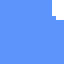

ooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooddoooooooooooooodddoooooooooooooddoooooooooooooohooooooooooooooohhoooooooooooooo


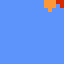

fuuuuuwsffffffwhfuuuuuwsfuuuuuwhwwwwwwwsfuuuuuwsssssssssfuuuuuhsffffffwsfuuuuuwsfuuuuuwsfuuuuuwhfuuuuuwswwwwwhhhfuuuuuwssssshhddfuuuuuwsffffhddffuuuuuwsfuuuhhddwwwwwwwsfuuuuhhhssssssssfuuhuuwhffffffwsfuuuuhwhfuuuuuwsfuhhhhhhfuuuuuwswhhddhhsfuuuuuwsshddfdhh


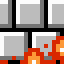

ooiisoooioisssooooiisossissssssooobissssissbsssboobissssiissssbbbbbssssssiiiiiibiiisssssssssssiibbsssssssssssssibbssssssssssssssbissssssssssssssiisssiissssssssiiiissibisssssssissssssiissssssiioobissssssssssiboobissssssssssiboobisooossssssiboobisooooobisoio


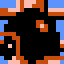

rkkkkkkkkkkkkkkskrkkkkkkkkkkkksskkrkkkkkkkkkkssskkkrkkkkkkkksssskkkkrrrrrrrrsssskkkkrrrrrrrrssssrkkkrrrrrrrrssssrkkkrrrrrrrrssssrkkkrrrrrrrrssssrkkkrrrrrrrrsssskkkkrrrrrrrrsssskkkkrrrrrrrrsssskkksssssssssrssskksssssssssssrssksssssssssssssrskssssssssssssssr


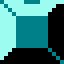

ooooooooooooooooooooooooooooddddooooooooooffhhhfooooooooofffffffooooooooooffffffooooooooooodddddooooooooooooddddooooooooooooooooooooooooooooooofooooooooooooofffooooooooooooffddoooooooooooffdffooooooooooffffffooooooooofffffffoooooooooffffoffooooooooooffoooo


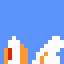

oooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooossssssosssssssosbbbbbssbbbbbbssbbbbbbbbsbbbbbbbsbbbbbbsbbbbbbbsbbbbbbbsbiiibbbsbbssssbiiiiiisbbsbbbbbiiiiiiibssbssssisiiiiiissssoooiisbbbbiibbssooiiiisssbibbbbsoiiiiiisbbibbbbboiiiiiisiiibbbbb


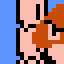

GGGGGfhGGGhdhGGGGGGGGfhGGGhdhGGGGGGGGfhdhhddhGGGGGGGGfhdddddhGGGGGGGGfhdddddhGGGGGGGGfhdGGddhGGGGGGGGfhGGGhdhGGGGGGGGfhGGGhdhGGGGGGGGfhGGGhdhGGGGGGGGfhGGGhdhGGGGGGGGfhdhhddhGGGGGGGGfhdddddhGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG


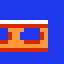

fuuuuuwsfhhddfdhfuuuuuwsfuhhhddhwwwwwwwshuuuhdhhssssssssfuhuhhhsffffffwhhhhhhuwsfuuuuuhhddhhuuwsfuuuuuhddfdhhwwsfuuuuuhhddfdhsssfuuuuuwhhhddhfwsfuuuuhwsfhdhhuwswwwwwwwhfhhhuuwssssssshshhuuuuwsffffffwsfuuuuuwsfuuuuuwsfuuuuuwsfuuuuuwswwwwwwwsfuuuuuwsssssssss


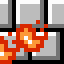

oooooooossnnnnnnoooooooooosnnnnnooooooooosnnnnnnoooooooosnnnnnnnooooooooosssnnnnoooooooooooosnnnooooooooooosnnnsoooooooooooosssooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


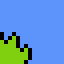

sssssshhhhssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss


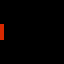

GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG


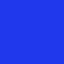

fddfsdeeeessssfsfdddsfeeeeessffsffddeeeeeeeedffseffeeeeeeeeeeddseeffffffeeeeeddffeeeefffffeeeedffdeeeeeeeffeeeddddeeeeeeeeffedddeeeeffeeeeffeddfeeeeffdeeeeffddfeeeefddefdeffdddffeeeeeefeeeffddffdeeeeeeeeeffddfddeeeffddeefffdsssfdsffdeeefffsssssfssfssssffss


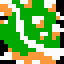

aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaoaaaaaaaaaaaaaaooaaaaaooooaaaaoooaaaaaooooaaaooooaaaaaooooaaoooooaaaaaooooaooooooaaaaaoooooooooooaaaaaoooooooooooaaaaaoooooooooooaaaaaoooooooooooaaaaaoooooooooooaaaaaoooooooooooaaaaaoooooooooooaaaaaoooooooooooaaaaaooooooooooo


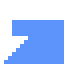

shhhhddddddddddsshhhhhdddddddddsshhhhhhddddddddsshhhhhhddddddddsshhhhhhddddddddsshhhhhhddddddddsshhhhhdddddddddsshhhhddddddddddssddddddddddddddssdddddhhhddddddssddddhhhhhdddddssdddhhhhhhhddddssdddhhhhhhhddddsosddhhhhhhhddddsoossdhhhhhddddssoooossssssssssso


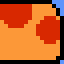

ooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa


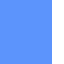

ooiiiisssbibbbssoooiisbbbbiibbssooooisiiiiiiosssoooooiiiiiiiosssssssssiiiiiissssbbbbbssbiiibbssbbbbbbbbsbbbbbbbsbbbbbbsbbbbbbbsbbbbbbbsbbbbbbbsbbssssbbsbssssbbsbbbbbssbbbbbbssbssssssosssssssosoooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


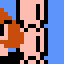

ssssbbssiiisssssssssbbsiiiiissssssssbbiiisiiisssssssbbiisssiisssssssbbiiisiiisssssssbbbiiiiisssssssssbbbiiisssssssssssbbbbbbbbbbssssssssbbbbbbbbssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss


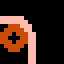

snnnnnnnnnnnnnsednnnnnnnnnnnnnnsdnnnnnnnnnnnnnnsdnnnnnnnnnnnnnnsdnnnnnnnnnnnnnnsdnnnnnnnnnnnnnnssnnnnnnnnnnnnnsesnnnnnnnnnnnnseesnnnnnnnnnnnnnsesnnnnnnnnnnnnnnssnnnnnnnnnnnnnnssnnnnnnnnnnnnnnsdnnnnnnnnnnnnnnsdnnnnnnnnnnnnnnsdnnnnnnnnnnnnnsednnnnnnnnnnnnsee


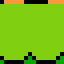

wwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwfwfwfwfwfwfwfwfwwfwfwfwfwfwfwfwffwfwfwfwfwfwfwfwffffffffffffffffffffffffffffffffuuuuuuuuuuuuuuuuoooooooooooooooooooooooooooooooo


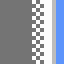

ooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooodddoooooooooooooodddd


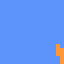

sssssssssssssssssssssssssssssssssssssssssssssshhssssssssssssshhhsssssssssssshhhdssssssssssshhhddssssssssssshhdddssssssssssshhddfssssssssssshhddfssssssssssshhdddssssssssssshhhddsssssssssssshhhdssssssssssssshhhsssssssssssssshhssssssssssssssssssssssssssssssss


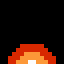

oooedeeededeeedfoooeededeeededefoooeeedeeeeedeefoooeededeeededffsssedefededeeefdbbbbeeffedeeeffdbbbbbeeededeefbdbbbbbbsbbbbbbfsbbbbbbbsbbbbbbbsbbssssbbsbssssbbsbbbbbssbbbbbbssbssssssosssssssosoooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


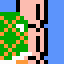

sssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssassssssssssssssaa


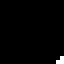

oosbssssssssssssoosbssssssssssssoooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


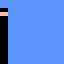

ssssfhssshdhssssssssfhssshdhssssssssfhdhhddhssssssssfhdddddhssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss


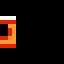

ssssshhhhhhsssssffffwwwwwwwwhhhhffffwwwwwwwwhhhhffffwwwwwwwwhhhhssssshhhhhhsssssffffwwhhddhhhhhhffffwhhdfddhhhhhffffwhdfdhhhhhhhssssshdddhhshhhdffffwhhdhhwhhhdfffffwwhhhwwwhdfdffffwwwwwwhwhdddssssshhhhhhshhdhffffwwwwwwwwhhhhffffwwwwwwwwhhhhffffwwwwwwwwhhhh


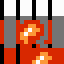

hffffooooooooooohffffooooooooooodddffooooooooooodddfoooooooooooohhdfoooooooooooooodooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


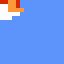

aaaaaooooaooooooaaaaaooooaaoooooaaaaaooooaaaooooaaaaaooooaaaaoooaaaaaaaaaaaaaaooaaaaaaaaaaaaaaaoaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaoaaaaaaaaaaaaaaoooooooooooaaaaooooooooooooaaaoooooooooooooaaooooooooooooooaoooooooooooooooooooooooooooooooooooooo


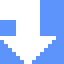

swwwwwwwwwwwwwwswiiiiiiiiiiiiiiwwiwiiiiiiiiiiwiwwiiiiiiiiiiiiiiwwiiiiiiiiiiiiiiwwiiiiiiiiiiiiiiwwiiiiiiiiiiiiiiwwiiiiiiiiiiiiiiwwiiiiiiiiiiiiiiwwiiiiiiiiiiiiiiwwiiiiiiiiiiiiiiwwiiiiiiiiiiiiiiwwiiiiiiiiiiiiiiwwiwiiiiiiiiiiwiwwiiiiiiiiiiiiiiwswwwwwwwwwwwwwws


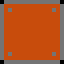

seeeeedddfdhfhhdoseeeeeddddhhfddooseeeeeddhhhhfdoooseeffhhhfdhhfooooffdddhffddhfooffdddddhfdddhfoooodddddhddddhfooooooddhhhddhhfooooooooffhhhhffooooooofdddhhhfdoooooofddddhhffdooooofddddhhhfedoooooooooooohfeeoooooooooooooseeooooooooooooooseooooooooooooooos


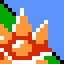

rrrsrrriiiisrrrsrrrsriiiiiiirrrsrrrsiirrriirrrrsrrriirrrrrirssssrriiirrrrrirbbbsriiiirrrrribbbbbiiiiiirrriibbbbbiiiiiiiiiiibbbbbiirriiiiiiibbbbbirrrriiiiiibbbbirrrrriiiiiibbiibrrrrriiiiiirbbbsrrrriiirriirrrrsrrrsiiirrrirrrrsrrrsriiirriirrrsssssrrriiiisrrrs


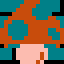

oooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooodooooooooooooooodddoooooooooooooddddoooooooooooo


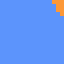

sssshhhssshhdfdhsssssssshsshdddhssssssssssshhdhhsssssssssssshhhsssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss


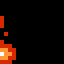

aaaaaoooooooooooaaaaaoooooooooooaaaaaoooooooooooaaaaaoooooooooooaaaaaoooooooooooaaaaaoooooooooooaaaaaoooooooooooaaaaaoooooooooooaaaaaoooooooooooaaaaaoooooooooooaaaaaoooooooooooaaaaaoooooooooooaaaaaoooooooooooaaaaaoooooooooooaaaaaoooooooooooaaaaaooooooooooo


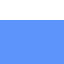

ooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooiiioooooooooooiiiiiioooooooooiiiiiiiooooooooisiiiiiioossoooiisbbbbiibbssooiiiisssbibbbbsoiiiiiisbbibbbbboiiiiiisiiibbbbboiiiiiisiiibbbbboiiiiiisbbibbbbs


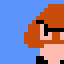

ddfdhhsssssssssshddfdhsssssssssshhhddhsssssssssssshdhhdddddddssshshhhddddddddddsshhddiiiiiiiidddhsddiddddddddwddhhddiddddddddwdddhhddwwwwwwwwdddfdhddddddddddddwddhwwddddddddwwwdhhwwwwwwwwwwwwshhssswwwwwwwwsssssssssssssssssssssssssssssssssssssssssssssssssss


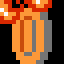

GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGffffGdGGGGGGGGGffhhffdhGGdGGGGGhffffhddhhdfGdGhffhhffhddddfGddhffffffhhdddf


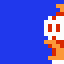

ohhoooooooooooooohhoooooooooooooohhooooooooffffoohhoooooooddffddohhoooodddooooooohhfdddoooooooooohhffoooooooooooohhoooooooooooooohhoooooooooooooohhffoooooooooooohhfdddoooooooooohhoooodddooooooohhoooooooddffddohhooooooooffffoohhoooooooooooooohhooooooooooooo


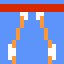

sssssssssssssssosnennnnnnnnnnnsosnennnnnnnnnnnsssnennnnnnnnnnnsssneeeeeeeeeeeesssneeeeeeeeeeeesssnnnnnnnnnnnnnsssnnnnnnnnnnnnnsssnnnnnnnnnnnnnsssnnnnnnnnnnnnnsssnnnnnnnnnnnnnsssnnnnnnnnnnnnnsssneeeeeeeeeeeesssnennnnnnnnnnnsssnennnnnnnnnnnsssneeeeeeeeeeeess


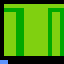

ooooooooooooddddoooffffooohhhhddooffffffhhhhhhhooofffffffhhhhhhhoooffffffhhhhhhfoodhhhfffhhhhhhfoodhhhhhhhhhhhffoddhhhhhhhhhhfffoddhhffffhhhhfffoddhffffffhhdddfodohffhhffhddddfoooohffffhddhhdfooooffhhffdhoodooooooffffodooooooooooooooooooooooooooooooooooooo


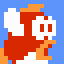

swwwwwwwwwwwwhwswiiiiiiiiiihiiihwiwiiiiiiiiihwhhwiiiiiiiiiihiihdwiiiiiihiiihhhhdwiiiihiiihhhhddfwiiiiihihhdhhhddwiiiihiihdddhhhhwiiiihhhhdfdhiiwwiiiihhddfdhhiiwwiiiiihhddhhiiiwwiiiiiihhhhiiiiwwiiiiiiiiiiiiiiwwiwiiiiiiiiiiwiwwiiiiiiiiiiiiiiwswwwwwwwwwwwwwws


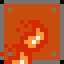

ooooooooooofffffooooooooooofffffooooooooooooffffooooooooooodhhhfooooooooooodhhhhooooooooooddhhhhooooooooooddhhffooooooooooddhfffoooooooooodohffhooooooooooooohffoooooooooooooffhooooooooooooooffoooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


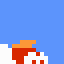

GFFFGGGGGGGGGGGGGGGFFFDGGFFFGGGGGGGGGGFDGGGGFGGGGGFFFFFDGGFFFDGGFFGGGGGFDGFGGFDGGGGGGGGFDGGGGGFDGGGGFFFFFFFFGGFDGGFFFDDDDDDFFFFDFFFDDDGGGGGDDFFFDDDGFDGGGGGGFDDDGGGGFDGGGFFFDDGGGGGGFDGGFGGDGGGGGGGGFDDGGGGDGGGGGGFDDFDGGGGGDGGGGFDGGGFDGGFFDGGGFDGGGGGGGGGGGDGG


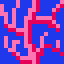

ooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooiiioooooooooooiiiiiioooooooooiiiiiiiooooooooisiiiiiioossoooiisbbbbiibbssooiiiisssbibbbbsoiiiiiisbbibbbbboiiiiiisiiibbbbboiiiiiisiiibbbbb


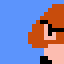

GdGuffuuffuddddfGdduffffffuudddfGdduuffffuuuufffGdduuuuuuuuuufffGGduuuuuuuuuuuffGGduuuuuffuuuuufGGGduuufffuuuuufGGGGGuffffuuuuuuGGGGGfffffuuuuuGGGGGGfffffuuuuddGGGGGfffffGddddGGGGGGGffGGdddGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG


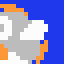

GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGdGGGGGGGGGGGGGGGddGGGGGGGGGGGGGGddGGGGGGGGGGGGGGddGGGGGGGGGGGGGGGdGGGGGGGGGGGGGGGdGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG


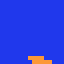

fhGGGhdhGGGGGGGGfhGGGhdhGGGGGGGGfhdhhddhGGGGGGGGfhdddddhGGGGGGGGfhdddddhGGGGGGGGfhdGGddhGGGGGGGGfhGGGhdhGGGGGGGGfhGGGhdhGGGGGGGGfhGGGhdhGGGGGGGGfhGGGhdhGGGGGGGGfhdhhddhGGGGGGGGfhdddddhGGGGGGGGfhdddddhGGGGGGGGfhdGGddhGGGGGGGGfhGGGhdhGGGGGGGGfhGGGhdhGGGGGGGG


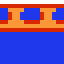

ssiissssssiissssssiissssssiissssssbissssssbissssssbissssssbissssbbbbbbbbbbbbbbbbiiiiiiiiiiiiiiiibbbbbbbbbbbbbbbbbbbbbbbiiiiibbbbbiiiiiibbbbbbbbbiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiissssssssssssssssssbissssssbissssssbissssssbissssssbissssssbissssssbissssssbissss


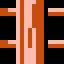

ooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooofoooooooooooooooffoooooooooooooofffoooooooooooooffffoooooooooooofffffoooooooooooffffffoooooooooofffffffoooooooooffffffffooooooo


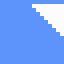

oooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooossssooooooooooosddhhsooooooooosdhhhhhsooooooooshhhhhhsooooooooshhhhhhsooooooooshhhhhhsoooooooooshhhhsooooooooooossssoooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


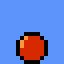

sssssssssssssssssssssssssssssdddsssssssssssffeeessssssssssffffffsssssssssssfffffssssssssssssddddsssssssssssssdddssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss


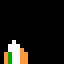

ooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooddddddddddddddddddddddddddddddddoooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


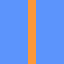

uuuuuuuuuuuuuuuoufwfffffffffffuoufwfffffffffffuuufwfffffffffffuuufwwwwwwwwwwwwuuufwwwwwwwwwwwwuuufffffffffffffuuufffffffffffffuuufffffffffffffuuufffffffffffffuuufffffffffffffuuufffffffffffffuuufwwwwwwwwwwwwuuufwfffffffffffuuufwfffffffffffuuufwwwwwwwwwwwwuu


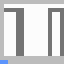

oossssssssssssssooooibiiiiiiiioooosbssssssssssssoosbssssssssssssoooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


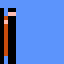

ooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooossssooooooooooosbssssooooooooosbsbssssooooooosbbbssssssooooossssssssssssoooossssssbbssssooossbssssbbbssss


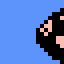

sssssssssssssssssnnnneennnnnennnsnnnneennnnnennnsnnnneennnnnennnsnnnneennnnnennnsnnnneennnnnennnsnnnneennnnnennnsnnnneennnnnennnsnnnneennnnnennnsnnnneennnnnennnsnnnneennnnnennnsnnnneennnnnennnsnnnneennnnnennnsnnnneennnnnennnssssssssssssssssosssssssssssssss


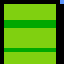

oiiiiiiddddiiiisiddddddddddddddsidsdddhhhddhdsdsiddddhhhhhdhdddsiddddhhhhhdhfffsiddddhhhhhdfffffddddddhhhddfffffdddddddddddfffffddhhdddddddfffffdhhhhddddddffffdihhhhddddddffddfidhhhddddddhfffsiddhdddhhddhdddsidsddddhhhdhdsdsidddddddhhdddddsossssssddddsssss


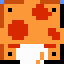

hhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhh


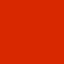

ssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssdsssssssssssssssdssddddsssssssssssdddfsfssssssssssdfssssssssssssesdssdddfsssssssessddddddsssssssfesddddddsssssssfefddddddsssssssfdssddddssssssss


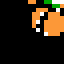

eeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeneneneneneneneneenenenenenenenennenenenenenenenennnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnccccccccccccccccssssssssssssssssssssssssssssssss


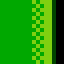

sssssssssssssssssssssssssssssssssssssssssssssssbsssssssssssssbsbsssssssssssbsbbrsssssssssssbbrirssssssssssrirrrrsssssssssssrrirrssssssssssssssrissssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss


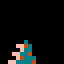

oooooosbssssooooooooosbsbssssooooooosbbbssssssooooossssssssssssoooossssssbbssssooossbssssbbbssssoosbssssbbbbssssoosbsssssbbbssssoosbsssibbbsssssoosbsssibbssssssoosbssssiissssssoossssssssssssssooooibiiiiiiiioooosbssssssssssssoosbssssssssssssoooooooooooooooo


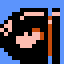

eeeeeeeeeenennsoeeeeeeeeenennnsoeeeeeeeeeenennsoeeeeeeeeenennnsoeeeeeeeeeenennsoeeeeeeeeenennnsoeeeeeeeeeenennsoeeeeeeeeenennnsoeeeeeeeeeenennsoeeeeeeeeenennnsoeeeeeeeeeenennsoeeeeeeeeenennnsoeeeeeeeeeenennsoeeeeeeeeenennnsoeeeeeeeeeenennsoeeeeeeeeenennnso


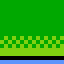

ssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss


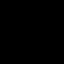

aaaaaaaaaaaaaassaaaaaaaaaaaaaaasaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaasaaaaaaaaaaaaaasssssssssssaaaassssssssssssaaasssssssssssssaassssssssssssssassssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss


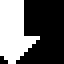

ooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooddooooooooooooooddddoooooooooooodddddooooooooooohhddoooooooooooohhhooooooooooooohhhhoooooooooooohhhfoooooooooooohhhffooooooooooohhfffooooooooooo


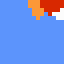

ooooooooooooooddoooooooooodddddeooooooooffeeefddoooooooffffffffdooooooooffffffddooooooooodddddddooooooooooddddddooooooooooooooooooooooooooooofffooooooooooofffddooooooooooffddffoooooooooffdffffooooooooffffffffoooooooffffffffooooooooffffoffofooooooooffoooooo


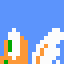

sssssssshhddfdhhssssssssshhddhhssssssssssshhhhssssssssssssshssshsssssssssssshshhssssssssssshsshdssssssssssshhhhdssssssssssshhddfsssssssssssshhddssssssssssssshhhsssssssssssssssssssssssssssssshsssssssssssssssshsssssssssssssshssssssssssssssshhsssssssssssssshh


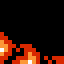

sssssssssssssssfsssssssssssssssfsssssssssssssssfsssssssssssssssfsssssssssssssssfsssssssssssssssfsssssssssssssssfsssssssssssssssfsssssssssssssssfsssssssssssssssfsssssssssssssssfsssssssssssssssfsssssssssssssssfsssssssssssssssfsssssssssssssssfsssssssssssssssf


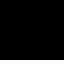

ssssssssssssssssssssssdddfsssssssssssdsdddffssssssssssddddssssssssssssefdddfssssssssseeffedffsssssssffffeedessssssssfffeeddfsssfssseeeeeedeesssdsseeeeeedfeeefddsseeeeeddeefddddssffeeeeddddddeessffdeeeeeeeeeeesffddeeeeeeeeeffsfddeeeeeeeeefffsfsssseeeeeeffff


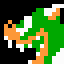

fdssddddssssssssfddfsdeeeessssfsfdddsfeeeeessffsffddeeeeeeeedffseffeeeeeeeeeeddseeffffffeeeeeddffeeeefffffeeeedffdeeeeeeeffeeeddddeeeeeeeeffedddeeeeffeeeeffeddfeeeeffdeeeeffddfeeeefddefdeffdddffeeeeeefeeeffddffdeeeeeeeeeffddfddeeeffddeefffdsssfdsffdeeefffs


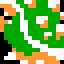

eeeeeeeeeenenncseeeeeeeeenennncseeeeeeeeeenenncceeeeeeeeenennncneeeeeeeeeencccnneeeeeecccccnnnnncccccceeeeeeeeeeeeeeeeeeeeeeeeeennnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnneeeeeeeeeeeeeeeennnnnnnnnnnnnnnnnnnnnnnnnnnnnnnn


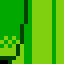

ibbbbbbbbbsbbbbibiiiiiiiiisbiiisbiiiiiiiiiisbiisbiiiiiiiiiisbiisbiiiiiiiiiiisbisbiiiiiiiiiiisbisbiiiiiiiiiiisbisbiiiiiiiiiiisssibiiiiiiiiissbbbbssssssssssbbiiisdbbbbibbbbiiiiisdiiissbiiiiiiiisdiiiisbiiiiiiiisdiiiisbiiiiiiiisbiiiisbiiiiiiississssisssssssssi


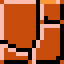

ooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooedoooooooooooeedeeooooooooooedeeeeoooooooooooffedeooooooooooofoffeooooooooooooofofooooooooooooooofoooooooooooooooo


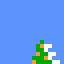

sssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssshssssssssssssssshssssssssssssssshsssssssssss


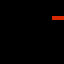

ooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooaaaaooooooooooooaaaaaoooooooooooaaaaaoooooooooooaaaaaoooooooooooaaaaaoooooooooooaaaaaoooooooooooaaaaaoooooooooooaaaaaoooooooooooaaaaaoooooooooooaaaaaoooooooooooaaaaaooooooooooo


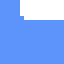

oooooooooooooooooooooouuuuuooooooooooufffffuuoooooooufffffffuuoooooufffffffffuuooooufffffffffuuuooufffffffffffuuooufffffffffffuuooufffffffffffuuooufffffffffffuuoooufffffffffuuuoooufffffffffuuuooooufffffffuuoooooooufffffuuooooooooouuuuuooooooooooooooooooooo


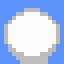

GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGffffGdGGGGGGGGGffhhffdhGGdGGGGGhffffhddhhdfGGG


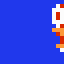

hhhddooooooooooohhhhoooooooooooohhhhhooooooooooohhhhfooooooooooohhhhffoooooooooohhhfffoooooooooohhffffoooooooooohhffffoooooooooohdddffooooooooooddddfooooooooooodhhdfooooooooooohoodoooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


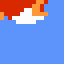

sssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssfhdddddhssssssssfhdssddhssssssssfhssshdhssssssssfhssshdhsssssss


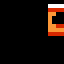

biisiiiddddsiiisbiisidddddddiiisbiisddhhhddhiiisbiiddhhhhhdhssssbidddhhhhhdhfffsbddddhhhhhdfffffddddddhhhddfffffdddddddddddfffffddhhdddddddfffffdhhhhddddddffffdbhhhhddddddffddfbihhhddddddhfffsbiihdddhhddhiiisbiisdddhhhdhiiisbiisidddhhddiiisbsssiiiddddsiiis


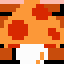

ooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaoooooooooooooooaoooooooooooooooaoooooooooooooooaoooooooooooooooaoooooooooooooooa


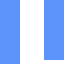

fhhddhhsffffffwsfhddfdhhfuuuuuwswhhddfdhfuuuuuwssshhhddhfuuuuuwshfffhdhhhhhuuuwsfuhuhhhhddhhuuwsfhuhhuhddfdhhwwsfuuuuuhhddfdhsssfuuuuuwhhhddhfwsfuuuuhwsfhdhhuwswwwwwwwhfhhhuuwssssssshshhuuuuwsffffffwsfuuuuuwsfuuuuuwsfuuuuuwsfuuuuuwswwwwwwwsfuuuuuwsssssssss


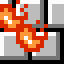

GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGuGGdGGGGGGGGGGGG


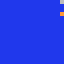

sshhdhdhhssssssssshhdddhshsssssssshhdddhhhsssssssshhdddhhsssssssssshhdddhsssssssssshhdddhhsssssssshhdfddhsssssssssshdfdhhsssssssssshdfdhssssssssssssdfdhsssssssssssshhfhsssssssssssshhhsssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss


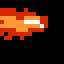

oooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooaoooooooooooooooaaooooooooooooooaaaoooooooooooooaaaaoooaaaaaaaaaaaaaaooaaaaaaaaaaaaaaaoaaaaaaaaaaaaaaaa


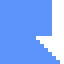

scnnnneennnnnennscnnnneennnnnennccnnnneennnnnennncnnnneennnnnennnncccneennnnnennnnnnncccccnnnenneeeeeeeeeecccccceeeeeeeeeeeeeeeennnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnneeeeeeeeeeeeeeeennnnnnnnnnnnnnnnnnnnnnnnnnnnnnnn


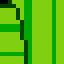

sssssssshssshdhhsssssssssshshhhsssssssssshshhsssssssssssssssssssssssssssssssssssssssssssssssssshssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss


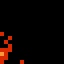

sssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssdddsssssssssssffeeessssssssssffffffsssssssssssfffffssssssssssssddddsssssssssssssdddssssssssssssssss


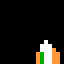

sssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssshssssssssssssssshssssssssssssssshsssssssssssssshhshsssssssssssshhshhsssssssssshhhhhhhssssssssshhhhhhhssssssssshhhhhhsssssssssshdhhhhsssssssssshdhdhhhsssssssshhhhdhhhsssssss


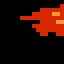

ssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssdddfsssssssssssdsdddffssssssssssddddssssssssssssefdddfssssssssseeffedffsssssssffffeedessssssssfffeeddfsssfssseeeeeedeesssdsseeeeeedfeeefdd


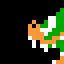

ssssssssssssssssssssssssssssssssccccccccccccccccnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnneeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeennnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnneeeeeeeeeeeeeeeennnnnnnnnnnnnnnnnnnnnnnnnnnnnnnn


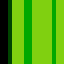

sssfhhfhhhhhhhhhsssfhfhhhhhhhhhhssfhhhffhhhhhhhhsfhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhffhhhfhhhhhhhhhhssfhhfhhhhhhhhshssfhfhhhhhhhhhhssfhhfhhhhhhhhhshsfhfhhhhhhhhhhssfhhhffhhhhhhhhsfhhhhhhhhhhhhhhfhhhhhhhhhhhhhhhsfffhhhfhhhhhhhhssssfhhfhhhhhhhhssssfhfhhhhhhhhh


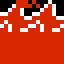

rkkkkkkkkkkkkkkskrkkkkkkkkkkkksskkrkkkkkkkkkkssskkkrkkkkkkkksssskkkkrrrrrrrrsssskkkkrrrrrrrrsssskkkkrrrrrrrrsssskkkkrrrrrrrrsssskkkkrrrrrrrrsssskkkkrrrrrrrrsssskkkkrrrrrrrrsssskkkkrrrrrrrrsssstkksssssssssrssstksssssssssssrsstsssssssssssssrssssssssssssssssr


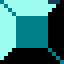

biisiiisiiisiiisbiisiiisiiisiiisbiisiiisiiisiiisbiisddddddddssssbiddddddddddddisbdddiiiiiiiidddsbddiddddddddsddsbddiddddddddsddsbdddssssssssdddsbsddddddddddddssbsssddddddddssssbissssssssssssssbiisssssssssiiisbiisiiisiiisiiisbiisiiisiiisiiisbsssiiisssssiiis


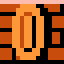

ssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssiiisssssssssssiiiiiisssssssssiiiiiiissssssssisiiiiiisssssssiisbbbbiibbssssiiiisssbibbbbssiiiiiisbbibbbbbsiiiiiisiiibbbbb


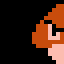

hddfdhhssssssssshhddfdhsssssssssshhhddhsssssssssssshdhhsssssssssshshhhshhhhssssshshhsshhddhhsssssssssshddfdhhssssssssshhddfdhsssssssssshhhddhsssssssshssshdhhhhhssssssshshhhhddhsssssshshhshddfdssssssssssshhddfsssssssssssshhhdsssssssssshssshdsssssssssssshshh


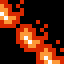

eeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee


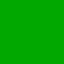

GGGGffffGdGGGGGGGGGffuuffduGGdGGGGGuffffudduudfGdGuffuuffuddddfGdduffffffuudddffdduuffffuuuuffffdduuuuuuuuuuffffGduuuuuuuuuuufffGduuuuuffuuuuuffGGduuufffuuuuufGGGGGuffffuuuuuuGGGGGfffffuuuuuGGGGGGfffffuuuuddGGGGGfffffGddddGGGGGGGffGGdddGGGGGGGGGGGGGGGGGGGG


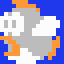

eeddfffeeefffeffeeeffffffffffefeeeeffffffffffefededdfffeeefffeffeddddfffffffefffeddddfffffffffffeddddfffffffffffooddfffffffefffeoooeeeffffffeeeoooooooeeeeeeoooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


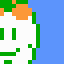

sssssssssssssaaasssssssssssssaaasssssssssssssaaasssssssssssssaaasssssssssssssaaasssssssssssssaaasssssssssssssaaasssssssssssssaaasssssssssssssaaasssssssssssssaaasssssssssssssaaasssssssssssssaaasssssssssssssaaasssssssssssssaaasssssssssssssaaasssssssssssssaaa


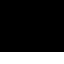

oiiiiiisbbibbbbsooiiiisssbibbbssoooiisbbbbiibbssooooisiiiiiiosssoooooiiiiiiiosssooooooiiiiiioossooooooooiiioooooooooooooooooooooeeeeoooooddoooooeededeooodeddooodeeeeeeooodedddoeeeeedeeooddedddeeedeeedoooddeddfoeeeeeeeoooddedooffeededoooooddoooooooeeddddddd


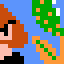

biiiiiisiiisiiisbiiiiiisiiisiiisbiiiiiisiiisiiisbbbbbbbbiiissssssssssssbiiisiiissssssssbiiisiiissssssssbiiisiiissssssssbssssiiissssssssbiiisiiissssssssbiiisiiissssssssbiiisiiisbbbbbbbbiiisssssbiiiiiisiiisiiisbiiiiiisiiisiiisbiiiiiisiiisiiisbiiiiiisssssiiis


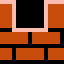

ssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssbbbbbssbbbbbbssbbbbbbbbsbbbbbbbsbbbbbbsbbbbbbbsbbbbbbbsbbbbbbbsbbssssbbsbssssbbsbbbbbssbbbbbbssbssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss


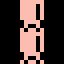

oooooooooooooooooooooooooooooooossssssssssssssssnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnneeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeennnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnneeeeeeeeeeeeeeeennnnnnnnnnnnnnnnnnnnnnnnnnnnnnnn


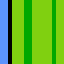

sssssssssssssssssssssssssssssssssssssssssssssssssssssddddddddssssssddddddddddddsssdddiiiiiiiidddssddiddddddddrddssddiddddddddrddssdddrrrrrrrrdddssrddddddddddddrssrrrddddddddrrrsssrrrrrrrrrrrrssssssrrrrrrrrsssssssssssssssssssssssssssssssssssssssssssssssssss


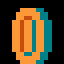

oooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooodddooooooooooooooddddoooooooooooodddddoooooooooohhhddooooooooooohhhhoooooooooooohhhhhooooooooooohhhhfooooooooooohhhhffoooooooooo


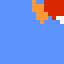

ssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssrrrsssssssssssrrrrrrsssssssssrrrrrrrssssssssrtrrrrrrssttsssrrtkkkkrrkkttssrrrrtttkrkkkktsrrrrrrtkkrkkkkksrrrrrrtrrrkkkkk


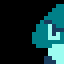

ddhoooooooooooooddhooooooooooooohdhooooooooooooohdhooooooooooooohdhooooooooooooohdhoooooooooooooddhoooooooooooooddhoooooooooooooddhoooooooooooooddhooooooooooooohdhooooooooooooohdhooooooooooooohdhooooooooooooohdhoooooooooooooddhoooooooooooooddhooooooooooooo


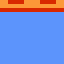

oddddddoooiisoooddedddddooiisooofddddoooodbisoodffddsoddddddsoddfddddddddfffffddddddddffffedeffddddbbbeededeeefdbbbbeeeeedeeeeffbiiedeeededeeedfiiieededeeededefiiieeedeeeeedeefssseededeeededffoobedefededeeefdoobieeffedeeeffdoobiseeededeefodoobisooooobisfoo


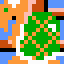

ddfdhhsssssssssshddfdhsssssssssshhhddhsssssssssssshdhhsssssssssshshhhsssssssssssshhssssssssssssshssssssssssssssshhssssssssssssssdhhsssssssssssssfdhsssssssssssssddhsssssssssssssdhhssssssssssssshhssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss


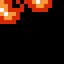

ssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssshsssssssssssssssssssssssssssssssssssssssssssssshhssssssssssssshhdssssssssssssshddssssssssssssshhdsssssssssssssshhsssssssssssshsss


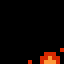

oooooooooooooooooooooooooooooooouuuuuuuuuuuuuuuuffffffffffffffffffffffffffffffffffffffffffffffffwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffwwwwwwwwwwwwwwwwffffffffffffffffffffffffffffffff


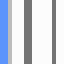

oooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooofnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnoooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


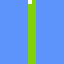

sssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssshssssssssssssssshssssssssssssssshssssssssssssssshsssssssssssssssshhhhssssssssssshhddhhssssssssss


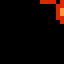

oooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooodddooooooooooooooddddooooo


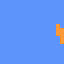

sssssssssssssssssssssssssssssssssssssssssssssssssssssddddddddssssssddddddddddddsssdddiiiiiiiidddssddiddddddddsddssddiddddddddsddssdddssssssssdddsssddddddddddddssssssddddddddsssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss


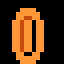

ooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooofooooooooooooooofoooooooooooooooooooooooooooooood


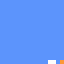

ibbbbbbbbbsbbbbibiiiiiiiiisbiiismiiiiiiiiiisbiismiiiiiiiiiisbiismiiiiiiiiiiisbismiiiiiiiiiiisbisbiiiiiiiiiiisbisbiiiiiiiiiiisssibiiiiiiiiissbbbbssssssssssbbiiisibbbbibbbbiiiiisbiiissbiiiiiiiisbiiiisbiiiiiiiisbiiiisbiiiiiiiisbiiiisbiiiiiiississssisssssssssi


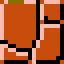

rkkkkkkkkkkkkkkskrkkkkkkkkkkkksskkrkkkkkkkkkkssskkkrkkkkkkkksssstkkkrrrrrrrrsssstkkkrrrrrrrrsssstkkkrrrrrrrrsssskkkkrrrrrrrrsssskkkkrrrrrrrrsssstkkkrrrrrrrrsssstkkkrrrrrrrrsssstkkkrrrrrrrrsssstkksssssssssrssstksssssssssssrssksssssssssssssrssssssssssssssssr


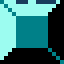

hhhshhhhsssssssssshhhddhhsssssssshhhdfddhhsssssssshdfdhhhhsshhhhhshdddhsshshhddhsshhdhhshshhdfddssshhhssshhdfdhhssssssshsshdddhssssssssssshhdhhsssssssssssshhhssssssssssssssssshssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss


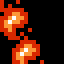

GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGfGGGGGGGGGGGGGGGfGGGGGGGGGGGGGGGfGGGGGGGGGGGGGGGfGGGGGGGGGGGGGGGfGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG


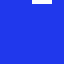

dbbbbbbbbbsbbbbibiiiiiiiiisbiiisbiiiiiiiiiisbiisbiiiiiiiiiisbiisbiiiiiiiiiiisbisbiiiiiiiiiiisbisbiiiiiiiiiiisbisdiiiiiiiiiiisssidiiiiiiiiissbbbbdsssssssssbbiiisdbbbbibbbbiiiiisbiiissbiiiiiiiisbiiiisbiiiiiiiisbiiiisbiiiiiiiisbiiiisbiiiiiiississssisssssssssi


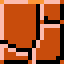

hdddddhooooooooohdooddhooooooooohooohdhooooooooohooohdhooooooooohooohdhooooooooohooohdhooooooooohdhhddhooooooooohdddddhooooooooohdddddhooooooooohdooddhooooooooohooohdhooooooooohooohdhooooooooohooohdhooooooooohooohdhooooooooohdhhddhooooooooohdddddhooooooooo


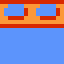

snnnnnnnnnnnnnsosnnnnnnnnnnnnnnssnnnnnnnnnnnnnnssnnnnnnnnnnnnnnssnnnnnnnnnnnnnnssnnnnnnnnnnnnnnssnnnnnnnnnnnnnsosnnnnnnnnnnnnsoosnnnnnnnnnnnnsoosnnnnnnnnnnnnnsosnnnnnnnnnnnnnnssnnnnnnnnnnnnnnssnnnnnnnnnnnnnnsosnnnnnnnnnnnnnsoossnnnnnnnnnnsooooossssssssssoo


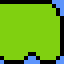

ooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooffffffffffffffffffffffffffffffffoooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


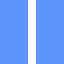

oooooooooooooooooooooosssssoooooooooosnnnnnssooooooosnnnnnnnssooooosnnnnnnnnnssoooosnnnnnnnnnsssoosnnnnnnnnnnnssoosnnnnnnnnnnnssoosnnnnnnnnnnnssoosnnnnnnnnnnnssooosnnnnnnnnnsssooosnnnnnnnnnsssoooosnnnnnnnssooooooosnnnnnssooooooooosssssooooooooooooooooooooo


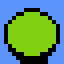

ibbbbbbbbbsbbbbibiiiiiiiiisbiiisbiiiiiiiiiisbiisbiiiiiiiiiisbiisdiiiiiiiiiiisbisdiiiiiiiiiiisbisdiiiiiiiiiiisbisdiiiiiiiiiiisssibiiiiiiiiissbbbbssssssssssbbiiisibbbbibbbbiiiiisbiiissbiiiiiiiisbiiiisbiiiiiiiisbiiiisbiiiiiiiisbiiiisbiiiiiiississssisssssssssi


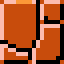

ooooooooooooooooooooooooooooodddoooooooooooffhhhooooooooooffffffooooooooooofffffooooooooooooddddooooooooooooodddoooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


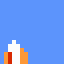

ssssssssssssssssssssnnnnnnnnnnssssnnnnnnnnnnnnnssnnnnnnnnnnnnnnssnnnnnnnnnnnnnnssnnnnnnnnnnnnnnssnnnnnnnnnnnnnsssnnnnnnnnnnnnssssnnnnnnnnnnnnnsssnnnnnnnnnnnnnnssnnnnnnnnnnnnnnssnnnnnnnnnnnnnnssnnnnnnnnnnnnnnssnnnnnnnnnnnnnnssnnnnnnnnnnnnnsssnnnnnnnnnnnnsss


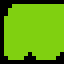

ooooooooiiioooooooooooiiiiiioooooooooiiiiiiiooooooooisiiiiiioossoooiisbbbbiibbssooiiiisssbibbbbsoiiiiiisbbibbbbboiiiiiisiiibbbbboiiiiiisiiibbbbboiiiiiisbbibbbbsooiiiisssbibbbssoooiisbbbbiibbssooooisiiiiiiosssoooooiiiiiiiosssooooooiiiiiioossooooooooiiiooooo


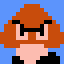

ooooooooffffooohoooooooffffffhhhooooooofffffffhhooooooooffffffhhooooooodhhhfffhhooooooodhhhhhhhhooooooddhhhhhhhhooooooddhhffffhhooooooddhffffffhoooooodohffhhffhooooooooohffffhdoooooooooffhhffdooooooooooffffodoooooooooooooooooooooooooooooooooooooooooooooooo


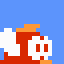

aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaoaaaaaaaaaaaaaaoooooooooooaaaaooooooooooooaaaoooooooooooooaaooooooooooooooaoooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


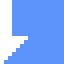

sssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssfhdddddsssssssssfhdssddsssssssssfhssshdsssssssssfhssshd


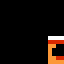

uuuuuuuuuuuuuuusufwfffffffffffusufwfffffffffffuuufwfffffffffffuuufwwwwwwwwwwwwuuufwwwwwwwwwwwwuuufffffffffffffuuufffffffffffffuuufffffffffffffuuufffffffffffffuuufffffffffffffuuufffffffffffffuuufwwwwwwwwwwwwuuufwfffffffffffuuufwfffffffffffuuufwwwwwwwwwwwwuu


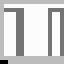

aaaaaaaaaaaaaaaaoaaaaaaaaaaaaaaaooaaaaaaaaaaaaaaoooaaaaooooooooaooooaaaooooooooaoooooaaooooooooaooooooaooooooooaoooooooooooooooaoooooooooooooooaoooooooooooooooaoooooooooooooooaoooooooooooooooaoooooooooooooooaoooooooooooooooaoooooooooooooooaoooooooooooooooa


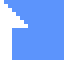

sssssssssssffdeesssssssssssfddeessssssssssssseeesssssssssssssffessssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss


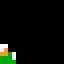

biiiiiisiiisiiisbiiiiiisiiisiiisbiiiiiisiiisiiisbbbbbbbbiiisssssooooooobiiisiiisooooooobiiisiiisooooooobiiisiiisooooooobssssiiisooooooobiiisiiisooooooobiiisiiisooooooobiiisiiisbbbbbbbbiiisssssbiiiiiisiiisiiisbiiiiiisiiisiiisbiiiiiisiiisiiisbiiiiiisssssiiis


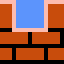

srrrrrrtrrrkkkkksrrrrrrtkkrkkkktssrrrrtttkrkkkttsssrrtkkkkrrkkttssssrtrrrrrrstttsssssrrrrrrrstttssssssrrrrrrssttssssssssrrrsssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss


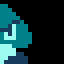

oooobbooiiiooooooooobboiiiiioooooooobbiiisiiiooooooobbiisssiiooooooobbiiisiiiooooooobbbiiiiiooooooooobbbiiiooooooooooobbbbbbbbbboooooooobbbbbbbboooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


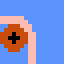

ssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssffffffffffffffffffffffffffffffffsssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssshhhhssssss


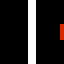

oooooooooeeeeeffooooooeeeeddffffoooooeeeeddddfffooodddddeddddfffooddeeeeeddddfffoddeffffeeddfffeoddeffffeeefffffoddeffeeeeefffffodddefffdeddfffeoddeffeeeddddfffoodeffffeddddfffoooeffffeddddfffooooeeeeooddffffoooooooooooeeeffooooooooooooooeeoooooooooooooooo


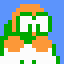

GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGufuGGGGGGGGGGGGGffffffGGGGGGGGGGGGGGGGGGGGGGGGGGufufuGGGGGGGGGGGfffffffGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGfffffffGGGGGGGGGufufuGGGGGGGGGGGGGGGGGGGGGGGGGGGffffffGGGGGGGGGG


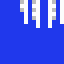

fsssshhhhhhsssssffffwwwwwwwwhhhhffffwwwwwwwwhhhhdfffwwwwwwwwhhhhdsssshhhhhhsssssdfffwwwwwwwwhhhhdfffwwwwwwwwhhhhdfffwwwwwwwwhhhhssssshhhhhhsssssffffwwwwwwwwhhhhffffwwwwwwwwhhhhffffwwwwwwwwhhhhssssshhhhhhsssssffffwwwwwwwwhhhhffffwwwwwwwwhhhhffffwwwwwwwwhhhh


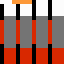

sshdfdhhsssssssssshdfdhssssssssssssdfdhsssssssssssshhfhsssssssssssshhhssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss


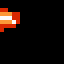

ooooooooddddddoooooodddddedddddoooffeeefddddoooooffffffffddoodddooffffffddddddddoooddddddddddfffooooddddddoooeedoooooooooooeeeeeoooooooffffeeedeooooofffdddffdeeooooffddfffdfeeeoooffdfffffffdeeooffffffffffeedeoffffffffoffeeedoffffoffoffoeedeooffoooooooooooo


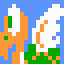

sssssssssssssssssssshhhhhhhssssssshhhhhhhhhhhsssshhhhdddddhhhhsshhhddddddddhhhhshhdddfffddhhhssshdddfffffddhhhsshddfffffffdddhhshddfffffffdddhhshdddfffffddhhhsshhdddfffddhhhssshhhddddddddhhhhsshhhhdddddhhhhsssshhhhhhhhhhhssssssshhhhhhhsssssssssssssssssssss


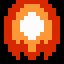

hssssssssssssssshssssssssssssssshssssssssssssssshssssssssssssssshssssssssssssssshssssssssssssssshssssssssssssssshssssssssssssssshssssssssssssssshssssssssssssssshssssssssssssssshssssssssssssssshssssssssssssssshssssssssssssssshssssssssssssssshsssssssssssssss


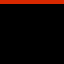

fuuuuuwsffffffwhfuuuuuwsfuuuuuwswwwwwwwsfuuuuuwsssssssssfuuuuuwsffffffwsfuuuuuwsfuuuuuwsfuuuuuwsfuuuuuwswwwwwwwsfuuuuuwsssssssssfuuuuuwsffffffwsfuuuuuwsfuuuuuwswwwwwwwsfuuuuuwsssssssssfuuuuuwsffffffwsfuuuuuwsfuuuuuwsfuuuuuwsfuuuuuwswwwwwwwsfuuuuuwsssssssss


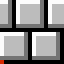

dbbbbbbbbbsbbbbidiiiiiiiiisbiiisdiiiiiiiiiisbiisbiiiiiiiiiisbiisbiiiiiiiiiiisbisbiiiiiiiiiiisbisbiiiiiiiiiiisbisbiiiiiiiiiiisssibiiiiiiiiissbbbbdsssssssssbbiiisdbbbbibbbbiiiiisdiiissbiiiiiiiisdiiiisbiiiiiiiisbiiiisbiiiiiiiisbiiiisbiiiiiiississssisssssssssi


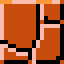

oooooooooooooooaoooooooooooooooaoooooooooooooooaoooooooooooooooaoooooooooooooooaoooooooooooooooaoooooooooooooooaoooooooooooooooaoooooooooooooooaoooooooooooooooaoooooooooooooooaoooooooooooooooaoooooooooooooooaoooooooooooooooaoooooooooooooooaoooooooooooooooa


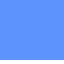

oooooooooooooooooooooooooaoooooooooooooooaaooooooooooooooaaaoooooooooooooaaaaoooaaaaaaaaaaaaaaooaaaaaaaaaaaaaaaoaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaoaaaaaaaaaaaaaaooaaaaaooooaaaaoooaaaaaooooaaaooooaaaaaooooaaoooooaaaaaooooaooooooaaaaaooooooooooo


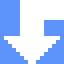

ssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssshsssssssssssssshhsssssssssssssshhsssssssssssssshhsssssssssssssshhsssssssssssssshhsssssssssssssshhssssssssssssssshssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss


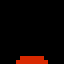

ssssssssffffffffsssssssssussssssssssssssssuussssssssssssssssusssssssssssssssusssssssssssssssusssssssssssssuussssssssssssfuffffffssssssssiiifffffssssssiiiiiisssssssssiiiiiiissssssssisiiiiiiussssssiisbbbbiibbssssiiiisssbibbbbssiiiiiisbbibbbbbsiiiiiisiiibbbbb


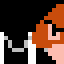

ibbbbbbbbbsbbbbisiiiiiiiiisbiiissiiiiiiiiiisbiissiiiiiiiiiisbiissiiiiiiiiiiisbissiiiiiiiiiiisbisbiiiiiiiiiiisbisbiiiiiiiiiiisssibiiiiiiiiissbbbbssssssssssbbiiisibbbbibbbbiiiiisbiiissbiiiiiiiisbiiiisbiiiiiiiisbiiiisbiiiiiiiisbiiiisbiiiiiiississssisssssssssi


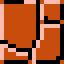

ooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooodddooooooooooooooddddoooooooooooodddddooofffooohhhhddooooffffhhhhhhhooooofffffhhhhhhhoooo


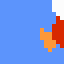

ooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooeeoooooooooeeeeeffooooooeeeeddffffoooooeeeeddddfffooodddddeddddfffooddeeeeeddddfffoddeffffeeddfffeoddeffffeeefffffoddeffeeeeefffffodddefffdeddfffeoddeffeeeddddfffoodeffffeddddfff


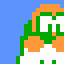

ooofGGfGGGGGGfffooofGfGGGGGGGGffoofGGGffGGGGGGGGofGGGGGGGGGGGGGGfGGGGGGGGGGGGGGGofffGGGfGGGGGGGGoooofGGfGGGGGGGGoooofGfGGGGGGGGGooofGGfGGGGGGGGGooofGfGGGGGGGGGGoofGGGffGGGGGGGGofGGGGGGGGGGGGGGfGGGGGGGGGGGGGGGofffGGGfGGGGGGGGoooofGGfGGGGGGGGoooofGfGGGGGGGGG


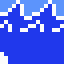

sssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssfhdddddhssssssssfhdssddhssssssssfhssshdhssssssssfhssshdhsss


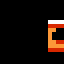

oooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooobbbbbbbboooooobbbbbbbbbbooooobbbiiiooooooooobbbiiiiioooooooobbiiisiiiooooooobbiisssiiooooooobbiiisiiiooooooobboiiiiioooooooobbooiiiooooo


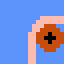

aaaassssssssssssaaaassssssssssssaaaassssssssssssaaaassssssssssssaaaassssssssssssaaaassssssssssssaaaassssssssssssaaaassssssssssssaaaassssssssssssaaasssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss


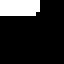

GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGfGGGGGGGGGGGGGGGfGGGGGGGGGGGGGGGfGGGGGGGGGGGGGGGfGGGGGGGGGGGGGGGfGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG


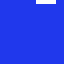

ssssssssssssssaassssssssssssssaassssssssssssssaassssssssssssssaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaassssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss


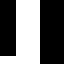

ssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssfnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss


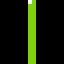

oddddddoooooooooddedddddoooooooofddddoooodooooodffddooddddddooddfddddddddfffffddddddddffffedeffddddoooeededeeefdooooeeeeedeeeeffoooedeeededeeedfoooeededeeededefoooeeedeeeeedeefoooeededeeededffoooedefededeeefdooooeeffedeeeffdoooooeeededeefodooooooooooooofoo


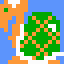

GddhhffffhhhhfffGddhhhhhhhhhhfffGGdhhhhhhhhhhhffGGdhhhhhffhhhhhfGGGdhhhfffhhhhhfGGGGGhffffhhhhhhGGGGGfffffhhhhhGGGGGGfffffhhhhddGGGGGfffffGddddGGGGGGGffGGdddGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG


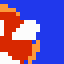

ffffffffeooooooofffefffeooooooooffffeeeoooooooooeeeeoooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


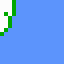

GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGdGGGGGGGGGGGGGGGdfGGGGGGGGGGGGGGdfGGGGGGGGGGGGGGdffGGGGGGGGGGGGGfffGGGGGGGGGGGGGfffGGGGGGGGGGGGGfffGGGGGGGGGGGGGuffGGGGGGGGGGGGGufGGGGGGGGGGGGGGuuGGGGGGGGGGGGGG


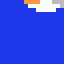

fuuuuuwsffffffwsfuuuuuwsfuuuuuwswwwwwwwsfuuuuuwsssssssssfuuuuuwsffffffwsfuuuuuwsfuuuuuwsfuuuuuwsfuuuuuwswwwwwwwsfuuuuuwsssssssssfuuuuuwsffffffwsfuuuuuwsfuuuuuwshwwwwwwsfuuuuuwshhssssssfuuuuuwsdhffffwsfuuuuuwsdhuuuuwsfuuuuuwshhuuuuwswwwwwwwshuhhhhwsssssssss


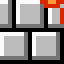

saaaaaaaaaaaaaaassaaaaaaaaaaaaaasssaaaasssssssssssssaaassssssssssssssaasssssssssssssssasssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss


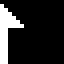

oooooddhhhhhhhhhoooooddhhffffhhhoooooddhffffffhhooooodohffhhffhdoooooooohffffhddooooooooffhhffdhoooooooooffffodooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


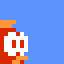

ssssssssssssssssssssssssssssddddssssssssssffeeefsssssssssfffffffssssssssssffffffsssssssssssdddddssssssssssssddddsssssssssssssssssssssssssssssssfsssssssssssssfffssssssssssssffddsssssssssssffdffssssssssssffffffsssssssssfffffffsssssssssffffsffssssssssssffssss


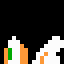

ooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooddooooooooooooooodoooooooooooooood


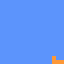

sssssssssssssssasssssssssssssssassssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss


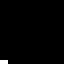

sssshssssssssssssssshssssssssssssssshsssssssssssssshhshsssssssssssshhshhsssssssssshhhhhhhssssssssshhhhhhhssssssssshhhhhhsssssssssshdhhhhsssssssssshdhdhhhsssssssshhhhdhhhsssssssshhhhdhhhsssssssshhdhdhhssssssssshhdddhshsssssssshhdddhhhsssssssshhdddhhssssssss


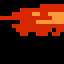

ssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa


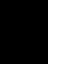

ooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooodoooooooooooooofdhoodoooooooooohddhhdfooooooooofhddddfooooooooofhhdddffoooooooohhhhffffoooooooohhhhffffoooooooohhhhhfffoooooooohhhhhhffoooooooohhhhhhfooooooooohhhhhhhooooooooohhhhhhoooooooooo


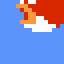

oooedeeededeeedfoooeededeeededefoooeeedeeeeedeefoooeededeeededffoooedefededeeefdooooeeffedeeeffdoooooeeededeefodooooooooooooofoooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


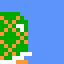

ooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooffff


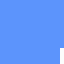

ssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssrrrrsssssiisssssrririrsssiriisssirrrrrrsssiriiisrrrrrirrssiiriiirrrirrrisssiiriibsrrrrrrrsssiirissbbrririsssssiisssssssrriiiiiii


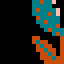

fuuuuuwsffffffwsfuuuuuwsfuuuuuwswwwwwwwsfuuuuuwsssssssssfuuuuuwsffffffwsfuuuuuwsfuuuuuwsfuuuuuwsfuuuuuwswwwwwwwsfuuuuuwsssssssssfuuuuuwsffffffwsfuuuuuwsfuuuuuwswwwwwwwsfuuuuuwsssssssssfuuuuuwsffffffwsfuuuuuwsfuuuuuwsfuuuuuwsfuuuuuwswwwwwwwsfuuuuuwssssssssh


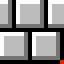

ssssssssrsstttssssssssttrttttttsssssstttrttktttkssssttttrrttttkksssttttttrrrrrrkssstttttttttttrrsstttttttttttttrssttttttttttttttssttttttttttttttsstttrrttttttttrsssttrkrtttttttrssstttrrttttttrrssssttttttttttrkssssstttttttttrkssssssssttttttrkssssssssssssssrs


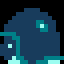

ooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooodddoooooo


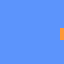

ssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssbbbbbssbbbbbbssbbbbbbbbsbbbbbbbsbbbbbbsbbbbbbbsbbbbbbbsbiiibbbsbbssssbiiiiiisbbsbbbbbiiiiiiibssbssssisiiiiiisssssssiisbbbbiibbssssiiiisssbibbbbssiiiiiisbbibbbbbsiiiiiisiiibbbbb


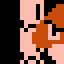

eeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeefehheeeeesssseehfhfheeeeesfffffhfhhheeeeeeedddfdhfhhdesssseeddddhhfddsssssseeddhhhhfdesssseffhhhfdhhfeeeeffdddhffddhf


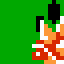

hhdhdhhssssssssshhdddhshsssssssshhdddhhhsssssssshhdddhhsssssssssshhdddhsssssssssshhdddhhsssssssshhdfddhsssssssssshdfdhhsssssssssshdfdhssssssssssssdfdhsssssssssssshhfhsssssssssssshhhsssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss


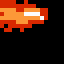

ooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooffffoooooooooooffhhfooooooooooohffffoooooooodohffhhfooooooooddhfffffooooooooddhhffffooooooooddhhhhhhooooooooodhhhhhhooooooooodhhhfffooooooooooffffffooooooooofffffffoooooooooffffffh


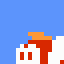

hssshdhssssssssshssshdhssssssssshdhhddhssssssssshdddddhssssssssshdddddhssssssssshdssddhssssssssshssshdhssssssssshfffhdhfffffffffhfffhdhfffffffffhssshdhssssssssshdhhddhssssssssshdddddhssssssssshdddddhssssssssshdssddhssssssssshssshdhssssssssshssshdhsssssssss


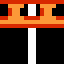

biiiiiisiiisiiisbiiiiiisiiisiiisbiiiiiisiiisiiisbbbbbbbbiiisssssiiisiiibiiisiiisiiisiiibiiisiiisiiisiiibiiisiiisssssiiibssssiiisiiisiiibiiisiiisiiisiiibiiisiiisiiisiiibiiisiiisbbbbbbbbiiisssssbiiiiiisiiisiiisbiiiiiisiiisiiisbiiiiiisiiisiiisbiiiiiisssssiiis


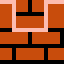

ssssssssssssssshssssssssssssssshsssssssssssssssssssssssssssssshsssssssssssssssssssssssssssssssshssssssssssssshhhsssssssssssshhddsssssssssssshddfsssssssssssshhddssssssssssssshhhssssssssssshssshssssssssssssshshsssssssssshhhhhhssssssssshhddhhsssssssssshddfdhh


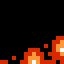

sfhdddddhssssssssfhdssddhssssssssfhssshdhssssssssfhssshdhssssssssfhssshdhssssssssfhssshdhssssssssfhdhhddhssssssssfhdddddhsssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss


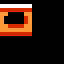

wwwwwwwwwwwwwwwswfufffffffffffwswfufffffffffffwwwfufffffffffffwwwfuuuuuuuuuuuuwwwfuuuuuuuuuuuuwwwfffffffffffffwwwfffffffffffffwwwfffffffffffffwwwfffffffffffffwwwfffffffffffffwwwfffffffffffffwwwfuuuuuuuuuuuuwwwfufffffffffffwwwfufffffffffffwwwfuuuuuuuuuuuuww


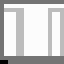

oooooooooooooooooooooooooooooooooooooooooooooooooooooddddddddooooooddddddddddddooodddiiiiiiiidddooddiddddddddsddooddiddddddddsddoodddssssssssdddoosddddddddddddsoosssddddddddsssooossssssssssssoooooossssssssooooooooooooooooooooooooooooooooooooooooooooooooooo


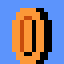

ssssssssssssssssssssssssssssssshssssssssssssshhhsssssssssssshhhhssssssssssshhhddsssssssssshhhdddsssssssssshhdddfsssssssssshhddffsssssssssshhddffsssssssssshhdddfsssssssssshhhdddssssssssssshhhddsssssssssssshhhhssssssssssssshhhssssssssssssssshssssssssssssssss


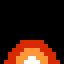

ssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssshssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss


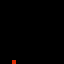

duudfGGGGGGGGGGGddddfGGGGGGGGGGGudddffGGGGGGGGGGuuffffGGGGGGGGGGuuffffGGGGGGGGGGuuufffGGGGGGGGGGuuuuffGGGGGGGGGGuuuufGGGGGGGGGGGuuuuuGGGGGGGGGGGuuuuGGGGGGGGGGGGuuuddGGGGGGGGGGGddddGGGGGGGGGGGGddGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG


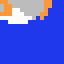

ibbbbbbbbbsbbbbibiiiiiiiiisbiiisbiiiiiiiiiisbiisbiiiiiiiiiisbiisbiiiiiiiiiiisbisbiiiiiiiiiiisbisbiiiiiiiiiiisbisbiiiiiiiiiiisssibiiiiiiiiissbbbbssssssssssbbiiisibbbbibbbbiiiiisbiiissbiiiiiiiissiiiisbiiiiiiiissiiiisbiiiiiiiissiiiisbiiiiiiississssisssssssssi


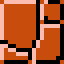

ssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssdsssssssssssssssdssddddsssssssss


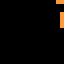

uuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuufufufufufufufufuufufufufufufufuffufufufufufufufuffffffffffffffffffffffffffffffffwwwwwwwwwwwwwwwwssssssssssssssssssssssssssssssss


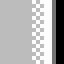

sssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssfhdddddhssssssssfhdssddhssssssssfhssshdhssssssssfhssshdhssssssssfhssshdhssssssssfhssshdhssssssssfhdhhddhssssssssfhdddddhsssssss


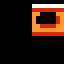

seeeeeeeeeeeeeeeoseeeeeeeeeeeeeeooseeeeeeeeeeeeeoooseeeeeeeeeeeeooooseeeeeeeeeeeoooooseeeeeeeeeeooooooseeeeeeeeeoooooooseeeeeeeeooooooooiiieeeeeooooooiiiiiieeeeoooooiiiiiiieeeeooooisiiiiiieessoooiisbbbbiibbssooiiiisssbibbbbsoiiiiiisbbibbbbboiiiiiisiiibbbbb


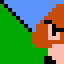

oooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooodddooooooooooooooddddooooooo


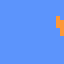

rkkkkkkkkkskkkkrkrrrrrrrrrskrrrskrrrrrrrrrrskrrskrrrrrrrrrrskrrstrrrrrrrrrrrskrstrrrrrrrrrrrskrstrrrrrrrrrrrskrskrrrrrrrrrrrsssrkrrrrrrrrrsskkkktssssssssskkrrrstkkkkrkkkkrrrrrstrrrsskrrrrrrrrstrrrrskrrrrrrrrstrrrrskrrrrrrrrskrrrrskrrrrrrrssrssssrsssssssssr


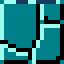

ssssbbssssssssssssssbbssssssssssssssbbssssssssssssssbbssssssssssssssbbssssssssssssssbbssssssssssssssbbssssssssssssssbbssssssssssssssbbssssssssssssssbbssssssssssssssbbssssssssssssssbbssssssssssssssbbssssssssssssssbbssssssssssssssbbssssssssssssssbbssssssssss


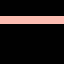

rkkkkkkkkkskkkkrirrrrrrrrrskrrrsirrrrrrrrrrskrrsirrrrrrrrrrskrrsirrrrrrrrrrrskrsirrrrrrrrrrrskrskrrrrrrrrrrrskrskrrrrrrrrrrrsssrkrrrrrrrrrsskkkksssssssssskkrrrsrkkkkrkkkkrrrrrskrrrsskrrrrrrrrsirrrrskrrrrrrrrsirrrrskrrrrrrrrsirrrrskrrrrrrrssissssrsssssssssr


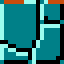

sshhdddhsssssssssshhdddhhsssssssshhdfddhsssssssssshdfdhhsssssssssshdfdhssssssssssssdfdhsssssssssssshhfhsssssssssssshhhssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss


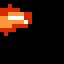

GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGfGGGGGGGGGGGGGGffGGGGGGGGGGGGGfffGGGGGGffufGGfffuuffsffsfffGffuufffsfssfufGfuufffffsfssfuffufffffffssffsfffffffffffsssssfffffffffffsssssfffufffffffssffsffffuufffffsfssfuffGffuufffsfssfufGGGfffuuffsffsfff


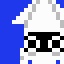

oosbssssbbbbssssoosbsssssbbbssssoosbsssibbbsssssoosbsssibbssssssoosbssssiissssssoossssssssssssssooooibiiiiiiiioooosbssssssssssssoosbssssssssssssoooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


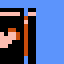

ooooooooooooooodooooooooooooooddooooooooooooooddooooooooooooooddoooooooooooooodooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


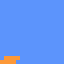

uuuuuuuuooooooooffffffffuuuooooofffffffffffuuoooffffffffffffuuoofffffffffffffuuofffffffffffffuuuffffffffffffffuuffffffffffffffuuffffffffffffffuuffffffffffffffuufffffffffffffuuufffffffffffffuuuffffffffffffuuoofffffffffffuuoooffffffffuuuooooouuuuuuuuoooooooo


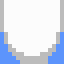

sssssssssssssssssssssssssssssssssssssssssssssssssssssddddddddssssssddddddddddddsssdddiiiiiiiidddssddiddddddddwddssddiddddddddwddssdddwwwwwwwwdddsswddddddddddddwsswwwddddddddwwwssswwwwwwwwwwwwsssssswwwwwwwwsssssssssssssssssssssssssssssssssssssssssssssssssss


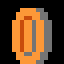

ssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssrrrrsssssiisssssrririrsssiriisssirrrrrrsssiriiisrrrrrirrssiiriiirrrirrrisssiiriibsrrrrrrrsssiirissbbrririsssssii


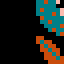

oooooooooooooooaoooooooooooooooaoooooooooooooooaoooooooooooooooaoooooooooooooooaoooooooooooooooaoooooooooooooooaoooooooooooooooaoooooooooooooooaoooooooooooooooaoooooooooooooooaoooooooooooooooaoooooooooooooooaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa


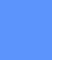

sddddddsssiissssddedddddssiissssfddddssssdbisssdffddssddddddssddfddddddddfffffddddddddffffedeffddddbbbeededeeefdbbbbeeeeedeeeeffbiiedeeededeeedfiiieededeeededefiiieeedeeeeedeefssseededeeededffssbedefededeeefdssbieeffedeeeffdssbiseeededeefsdssbissssssbisfss


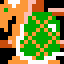

ssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssasssssssssssssssaassssssssssssssaaasssssssssssssaaaassssaaaaaaaaaaaaasssaaaaaaaaaaaaaass


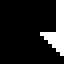

oooeeoooooooooooooeeeooooooooooooeedeeoooooooooooeedeeoooooooooooeedeeooooooooooooeedooooooooooooooeeeeeeeeeeeeeoooooeeeeeeeeeeeooooooooooooeeoooooooooooooedeeoooooooooooeedeeoooooooooooeedeeooooooooooooeedeooooooooooooooeeooooooooooooooooooooooooooooooooo


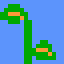

ddddddssssssssssdedddddssssssssdddddssssdsssssddfddssddddddssdddddddddddfffffddddddddffffedeffddddbbbeededeeefdsbbbeeeeedeeeeffbfffeeedeedeeedfbdddffdeeeededefsfffdfeeeeeedeefbfffffdeeeededffsffffeedeedeeefddfsffeeeddeeeffddsffseedeedeefsddssssssssssssfssd


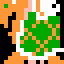

sddddddsssssssssddhdddddbbbbbbbbfddddbbbbdbbbbbdffddbbddddddbbddfddddddddfffffddddddddffffhdhffddddbbbhhdhdhhhfdbbbbhhhhhdhhhhffbbbhdhhhdhdhhhdfbbbhhdhdhhhdhdhfbbbhhhdhhhhhdhhfbbbhhdhdhhhdhdffbbbhdhfhdhdhhhfdbbbbhhffhdhhhffdbbbbbhhhdhdhhfbdsssssssssssssfss


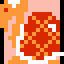

ooooooooooooooofooooooooooooooofooooooooooooooofooooooooooooooofooooooooooooooofooooooooooooooofooooooooooooooofooooooooooooooofooooooooooooooofooooooooooooooofooooooooooooooofooooooooooooooofooooooooooooooofooooooooooooooofooooooooooooooofooooooooooooooof


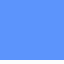

oooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooossssooooooooooosnneesooooooooosneeeeesooooooooseeeeeesooooooooseeeeeesooooooooseeeeeesoooooooooseeeesooooooooooossssoooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


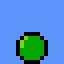

offffooohhhhddooffffffhhhhhhhooofffffffhhhhhhhoooffffffhhhhhhfoodhhhfffhhhhhhffodhhhhhhhhhhhfffodhhhhhhhhhhffffodhhffffhhhhffffodhffffffhhdddffoohffhhffhddddfoooohffffhddhhdfooooffhhffdhoodooooooffffodooooooooooooooooooooooooooooooooooooooooooooooooooooooo


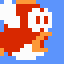

ssssssssssssssssssshhhhhhhssssssshhhhhhhhhhhsssshhhhdddddhhhhssshhddddddddhhhhsshdddfffddhhhssssdddfffffddhhhsssddfffffffdddhhssddfffffffdddhhssdddfffffddhhhssshdddfffddhhhsssshhddddddddhhhhsshhhhdddddhhhhsssshhhhhhhhhhhssssssshhhhhhhssssssssssssssssssssss


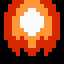

ooooooooddhhhhfdooooooffhhhfdhhfooooffdddhffddhfooffdddddhfdddhfoooodddddhddddhfooooooddhhhddhhfooooooooffhhhhffooooooofdddhhhfdoooooofddddhhffdooooofddddhhhfodoooooooooooohfoooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


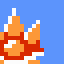

oooobboooooooooooooobboooooooooooooobboooooooooooooobboooooooooooooobboooooooooooooobboooooooooooooobboooooooooooooobboooooooooooooobboooooooooooooobboooooooooooooobboooooooooooooobboooooooooooooobboooooooooooooobboooooooooooooobboooooooooooooobboooooooooo


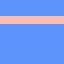

ooosssssssssssooosssnnnnnnnnnnsossnnnnnnnnnnnnnssnnnnnnnnnnnnnnssnnnnnnnnnnnnnnssnnnnnnnnnnnnnnssnnnnnnnnnnnnnsosnnnnnnnnnnnnsoosnnnnnnnnnnnnnsosnnnnnnnnnnnnnnssnnnnnnnnnnnnnnssnnnnnnnnnnnnnnssnnnnnnnnnnnnnnssnnnnnnnnnnnnnnssnnnnnnnnnnnnnsosnnnnnnnnnnnnsoo


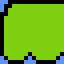

ohhhhddoooooooooooodddddoooooooooooddddooooooooooodddooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


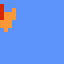

ssssssssssssssssneeeeeeeeeenennsneeeeeeeeenennnsneeeeeeeeeenennsneeeeeeeeenennnsneeeeeeeeeenennsneeeeeeeeenennnsneeeeeeeeeenennsneeeeeeeeenennnsneeeeeeeeeenennsneeeeeeeeenennnsneeeeeeeeeenennsneeeeeeeeenennnsneeeeeeeeeenennsssssssssssssssssssssssssssssssso


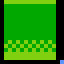

doooooooooooooooddooooooooooooooddooooooooooooooddoooooooooooooodffooooooooooooofdoeeeeeoooooooodeeeddeeeeeooooofffddddeeeeeeddofefddddffffeeeddeeffddddedffeeddeeeffdddeedfedddeeeededdeedfedddeeedededeeeffdddoefeeededdeefedoooefffedeeeefeoooooooeedeeeofooo


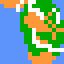

In [16]:
def show_blocks(blocks):
    for b in blocks:
        # create blocks of symbols
        block = []
        for i in range(block_size):
            i_ = i * block_size
            block.append(b[i_:i_+block_size])
        
        size = 4
        color_block = np.zeros((block_size * size, block_size * size), dtype=object)
        for i, row in enumerate(block):
            for t, col in enumerate(row):                
                # get the color based on the pixel symbol
                color = list(colors.keys())[list(colors.values()).index(col)]
                
                for i_ in range(i * size, i * size + size):
                    for t_ in range(t * size, t * size + size):
                        color_block[t_, i_] = color
                
        print(b)
        img = Image.fromarray(np.array(color_block.tolist(), dtype=np.uint8))
        display(img)
        
show_blocks(new_blocks)